In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append('..')
from common.layers import SigmoidWithLoss
import collections
from negative_sampling_layer import UnigramSampler

In [3]:
W = np.arange(21).reshape(7,3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [4]:
### 특정 행 추출하기
W[2], W[5]

(array([6, 7, 8]), array([15, 16, 17]))

In [5]:
### 여러 행 추출하기
idx = np.array([1,0,3,0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [6]:
### Embedding 계층 구현하기
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        
        np.add.at(dW, self.idx, dout)

        return None

In [7]:
W = np.arange(21).reshape(3,7)
W[:, 1]

array([ 1,  8, 15])

In [8]:
### Embedding 계층과 dot 계층을 하나로 합쳐서 구현
class EmbeddingDot:
    def __init__(self, W):
        self.embd = Embedding(W)
        self.params = self.embd.params
        self.grads = self.embd.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embd.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0],1)
        
        dtarget_W = dout * h
        self.embd.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [9]:
W = np.arange(21).reshape(7,3)
idx = np.array([0,3,1])
h = np.arange(9).reshape(3,3)

embed = Embedding(W)
target_W = embed.forward(idx)
out = np.sum(target_W*h, axis=1)
out

array([  5, 122,  86])

In [10]:
target_W

array([[ 0,  1,  2],
       [ 9, 10, 11],
       [ 3,  4,  5]])

In [11]:
### 네거티브 샘플링의 샘플링 기법
np.random.choice(10)
np.random.choice(10)

words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

# 5개 무작위 추출, 중복 있음
np.random.choice(words, size=5)

# 5개 무작위 추출, 중복 없음
np.random.choice(words, size=5, replace=False)

# 확률 분포에 따라 샘플링
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'I'

In [12]:
np.sum(p)

1.0000000000000002

In [13]:
### 기본 확률분포에 0.75 제곱하는 이유 : 확률이 낮은 단어를 버리지 않기 위해서
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
new_p

array([0.64196878, 0.33150408, 0.02652714])

In [14]:
from common.np import *

In [22]:
### UnigramSampler 구현하기
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
            
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i,:] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
                
        else:
                negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size), replace=True, p=self.word_p)

        return negative_sample

In [23]:
### UnigramSampler 사용하기
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
negative_sample

array([[3, 2],
       [2, 0],
       [3, 2]], dtype=int32)

In [ ]:
target.shape

In [ ]:
counts = collections.Counter()
for word_id in corpus:
    counts[word_id] += 1
print(counts)
counts[2]

In [ ]:
vocab_size = len(counts)

word_p = np.zeros(vocab_size)
for i in range(vocab_size):
    word_p[i] = counts[i]
print(word_p)

In [ ]:
word_p = np.power(word_p, 0.75)
word_p /= np.sum(word_p)
word_p

In [ ]:
batch_size = target.shape[0]
negative_sample = np.zeros((batch_size, sample_size))

for i in range(batch_size):
    p = word_p.copy()
    target_idx = target[i]
    p[target_idx] = 0
    p /= p.sum()
    negative_sample[i, :] = np.random.choice(5, 2, replace=False, p=p)
    
negative_sample

In [ ]:
negative_sample = np.zeros((3, sample_size))
p = word_p.copy()
target_idx = target[0]
p[target_idx] = 0
p /= p.sum()
negative_sample[0, :] = np.random.choice(5, 2, replace=False, p=p)

In [ ]:
negative_sample

In [24]:
### 네거티브 샘플링 구현
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍적적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[i+1].forward(h, negative_target)
            loss += self.loss_layers[i+1].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
            
        return dh

In [ ]:
negative_target = negative_sample[:, 0]
embed

In [ ]:
words = ['apple', 'banana', 'pineapple']
nums = [100, 200, 300]

for w, n in zip(words, nums):
    print(w, n)

In [25]:
### 개선된 CBOW 모델 구현
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        self.in_layers = []
        for i in range(2*window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
            
        return None

In [29]:
from common import config
import pickle
from common.trainer import Trainer
from common.optimizer import *
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

In [30]:
plt.rcParams['font.family'] = 'AppleGothic'

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 2[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 2[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 3[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 3[s] | 손실 3.78
| 에폭 1 |  반복 141 / 9295 | 시간 4[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 5[s] | 손실 3.49
| 에폭 1 |  반복 181 / 9295 | 시간 5[s] | 손실 3.35
| 에폭 1 |  반복 201 / 9295 | 시간 6[s] | 손실 3.24
| 에폭 1 |  반복 221 / 9295 | 시간 6[s] | 손실 3.18
| 에폭 1 |  반복 241 / 9295 | 시간 7[s] | 손실 3.10
| 에폭 1 |  반복 261 / 9295 | 시간 8[s] | 손실 3.04
| 에폭 1 |  반복 281 / 9295 | 시간 8[s] | 손실 2.98
| 에폭 1 |  반복 301 / 9295 | 시간 9[s] | 손실 2.91
| 에폭 1 |  반복 321 / 9295 | 시간 10[s] | 손실 2.88
| 에폭 1 |  반복 341 / 9295 | 시간 10[s] | 손실 2.85
| 에폭 1 |  반복 361 / 9295 | 시간 11[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 11[s] | 손실 2.78
| 에폭 1 |  반복 401 / 9295 | 시간 12[s] | 손실 2.76
| 에폭 1 |  반복 421 / 9295 | 시간 13[s] | 손실 2.75
| 에폭 1 |  반복 441 / 9295 | 시간 13[

| 에폭 1 |  반복 3601 / 9295 | 시간 111[s] | 손실 2.44
| 에폭 1 |  반복 3621 / 9295 | 시간 111[s] | 손실 2.39
| 에폭 1 |  반복 3641 / 9295 | 시간 112[s] | 손실 2.40
| 에폭 1 |  반복 3661 / 9295 | 시간 113[s] | 손실 2.42
| 에폭 1 |  반복 3681 / 9295 | 시간 113[s] | 손실 2.45
| 에폭 1 |  반복 3701 / 9295 | 시간 114[s] | 손실 2.42
| 에폭 1 |  반복 3721 / 9295 | 시간 115[s] | 손실 2.43
| 에폭 1 |  반복 3741 / 9295 | 시간 115[s] | 손실 2.40
| 에폭 1 |  반복 3761 / 9295 | 시간 116[s] | 손실 2.43
| 에폭 1 |  반복 3781 / 9295 | 시간 116[s] | 손실 2.40
| 에폭 1 |  반복 3801 / 9295 | 시간 117[s] | 손실 2.43
| 에폭 1 |  반복 3821 / 9295 | 시간 118[s] | 손실 2.40
| 에폭 1 |  반복 3841 / 9295 | 시간 118[s] | 손실 2.40
| 에폭 1 |  반복 3861 / 9295 | 시간 119[s] | 손실 2.43
| 에폭 1 |  반복 3881 / 9295 | 시간 119[s] | 손실 2.40
| 에폭 1 |  반복 3901 / 9295 | 시간 120[s] | 손실 2.40
| 에폭 1 |  반복 3921 / 9295 | 시간 121[s] | 손실 2.39
| 에폭 1 |  반복 3941 / 9295 | 시간 121[s] | 손실 2.45
| 에폭 1 |  반복 3961 / 9295 | 시간 122[s] | 손실 2.41
| 에폭 1 |  반복 3981 / 9295 | 시간 122[s] | 손실 2.41
| 에폭 1 |  반복 4001 / 9295 | 시간 123[s] | 손실 2.39
| 에폭 1 |  반복 

| 에폭 1 |  반복 7101 / 9295 | 시간 218[s] | 손실 2.29
| 에폭 1 |  반복 7121 / 9295 | 시간 219[s] | 손실 2.29
| 에폭 1 |  반복 7141 / 9295 | 시간 220[s] | 손실 2.26
| 에폭 1 |  반복 7161 / 9295 | 시간 220[s] | 손실 2.31
| 에폭 1 |  반복 7181 / 9295 | 시간 221[s] | 손실 2.27
| 에폭 1 |  반복 7201 / 9295 | 시간 221[s] | 손실 2.27
| 에폭 1 |  반복 7221 / 9295 | 시간 222[s] | 손실 2.26
| 에폭 1 |  반복 7241 / 9295 | 시간 223[s] | 손실 2.31
| 에폭 1 |  반복 7261 / 9295 | 시간 223[s] | 손실 2.27
| 에폭 1 |  반복 7281 / 9295 | 시간 224[s] | 손실 2.22
| 에폭 1 |  반복 7301 / 9295 | 시간 224[s] | 손실 2.31
| 에폭 1 |  반복 7321 / 9295 | 시간 225[s] | 손실 2.30
| 에폭 1 |  반복 7341 / 9295 | 시간 226[s] | 손실 2.30
| 에폭 1 |  반복 7361 / 9295 | 시간 226[s] | 손실 2.23
| 에폭 1 |  반복 7381 / 9295 | 시간 227[s] | 손실 2.24
| 에폭 1 |  반복 7401 / 9295 | 시간 228[s] | 손실 2.26
| 에폭 1 |  반복 7421 / 9295 | 시간 228[s] | 손실 2.31
| 에폭 1 |  반복 7441 / 9295 | 시간 229[s] | 손실 2.25
| 에폭 1 |  반복 7461 / 9295 | 시간 229[s] | 손실 2.30
| 에폭 1 |  반복 7481 / 9295 | 시간 230[s] | 손실 2.29
| 에폭 1 |  반복 7501 / 9295 | 시간 231[s] | 손실 2.30
| 에폭 1 |  반복 

| 에폭 2 |  반복 1321 / 9295 | 시간 327[s] | 손실 2.19
| 에폭 2 |  반복 1341 / 9295 | 시간 327[s] | 손실 2.15
| 에폭 2 |  반복 1361 / 9295 | 시간 328[s] | 손실 2.16
| 에폭 2 |  반복 1381 / 9295 | 시간 328[s] | 손실 2.17
| 에폭 2 |  반복 1401 / 9295 | 시간 329[s] | 손실 2.16
| 에폭 2 |  반복 1421 / 9295 | 시간 330[s] | 손실 2.19
| 에폭 2 |  반복 1441 / 9295 | 시간 330[s] | 손실 2.16
| 에폭 2 |  반복 1461 / 9295 | 시간 331[s] | 손실 2.14
| 에폭 2 |  반복 1481 / 9295 | 시간 332[s] | 손실 2.15
| 에폭 2 |  반복 1501 / 9295 | 시간 332[s] | 손실 2.14
| 에폭 2 |  반복 1521 / 9295 | 시간 333[s] | 손실 2.17
| 에폭 2 |  반복 1541 / 9295 | 시간 333[s] | 손실 2.15
| 에폭 2 |  반복 1561 / 9295 | 시간 334[s] | 손실 2.16
| 에폭 2 |  반복 1581 / 9295 | 시간 335[s] | 손실 2.13
| 에폭 2 |  반복 1601 / 9295 | 시간 335[s] | 손실 2.15
| 에폭 2 |  반복 1621 / 9295 | 시간 336[s] | 손실 2.15
| 에폭 2 |  반복 1641 / 9295 | 시간 337[s] | 손실 2.14
| 에폭 2 |  반복 1661 / 9295 | 시간 337[s] | 손실 2.16
| 에폭 2 |  반복 1681 / 9295 | 시간 338[s] | 손실 2.11
| 에폭 2 |  반복 1701 / 9295 | 시간 338[s] | 손실 2.15
| 에폭 2 |  반복 1721 / 9295 | 시간 339[s] | 손실 2.12
| 에폭 2 |  반복 

| 에폭 2 |  반복 4821 / 9295 | 시간 435[s] | 손실 2.11
| 에폭 2 |  반복 4841 / 9295 | 시간 436[s] | 손실 2.08
| 에폭 2 |  반복 4861 / 9295 | 시간 436[s] | 손실 2.10
| 에폭 2 |  반복 4881 / 9295 | 시간 437[s] | 손실 2.10
| 에폭 2 |  반복 4901 / 9295 | 시간 437[s] | 손실 2.07
| 에폭 2 |  반복 4921 / 9295 | 시간 438[s] | 손실 2.04
| 에폭 2 |  반복 4941 / 9295 | 시간 439[s] | 손실 2.07
| 에폭 2 |  반복 4961 / 9295 | 시간 439[s] | 손실 2.09
| 에폭 2 |  반복 4981 / 9295 | 시간 440[s] | 손실 2.06
| 에폭 2 |  반복 5001 / 9295 | 시간 440[s] | 손실 2.11
| 에폭 2 |  반복 5021 / 9295 | 시간 441[s] | 손실 2.07
| 에폭 2 |  반복 5041 / 9295 | 시간 442[s] | 손실 2.07
| 에폭 2 |  반복 5061 / 9295 | 시간 442[s] | 손실 2.09
| 에폭 2 |  반복 5081 / 9295 | 시간 443[s] | 손실 2.11
| 에폭 2 |  반복 5101 / 9295 | 시간 444[s] | 손실 2.05
| 에폭 2 |  반복 5121 / 9295 | 시간 444[s] | 손실 2.09
| 에폭 2 |  반복 5141 / 9295 | 시간 445[s] | 손실 2.07
| 에폭 2 |  반복 5161 / 9295 | 시간 445[s] | 손실 2.08
| 에폭 2 |  반복 5181 / 9295 | 시간 446[s] | 손실 2.08
| 에폭 2 |  반복 5201 / 9295 | 시간 447[s] | 손실 2.05
| 에폭 2 |  반복 5221 / 9295 | 시간 447[s] | 손실 2.06
| 에폭 2 |  반복 

| 에폭 2 |  반복 8321 / 9295 | 시간 544[s] | 손실 2.05
| 에폭 2 |  반복 8341 / 9295 | 시간 544[s] | 손실 1.99
| 에폭 2 |  반복 8361 / 9295 | 시간 545[s] | 손실 1.96
| 에폭 2 |  반복 8381 / 9295 | 시간 546[s] | 손실 2.02
| 에폭 2 |  반복 8401 / 9295 | 시간 546[s] | 손실 2.01
| 에폭 2 |  반복 8421 / 9295 | 시간 547[s] | 손실 2.05
| 에폭 2 |  반복 8441 / 9295 | 시간 547[s] | 손실 2.02
| 에폭 2 |  반복 8461 / 9295 | 시간 548[s] | 손실 2.00
| 에폭 2 |  반복 8481 / 9295 | 시간 549[s] | 손실 2.02
| 에폭 2 |  반복 8501 / 9295 | 시간 549[s] | 손실 2.04
| 에폭 2 |  반복 8521 / 9295 | 시간 550[s] | 손실 2.03
| 에폭 2 |  반복 8541 / 9295 | 시간 551[s] | 손실 2.08
| 에폭 2 |  반복 8561 / 9295 | 시간 551[s] | 손실 2.01
| 에폭 2 |  반복 8581 / 9295 | 시간 552[s] | 손실 2.03
| 에폭 2 |  반복 8601 / 9295 | 시간 552[s] | 손실 2.03
| 에폭 2 |  반복 8621 / 9295 | 시간 553[s] | 손실 2.04
| 에폭 2 |  반복 8641 / 9295 | 시간 554[s] | 손실 2.02
| 에폭 2 |  반복 8661 / 9295 | 시간 554[s] | 손실 2.04
| 에폭 2 |  반복 8681 / 9295 | 시간 555[s] | 손실 2.00
| 에폭 2 |  반복 8701 / 9295 | 시간 556[s] | 손실 2.03
| 에폭 2 |  반복 8721 / 9295 | 시간 556[s] | 손실 2.01
| 에폭 2 |  반복 

| 에폭 3 |  반복 2541 / 9295 | 시간 654[s] | 손실 1.93
| 에폭 3 |  반복 2561 / 9295 | 시간 654[s] | 손실 1.91
| 에폭 3 |  반복 2581 / 9295 | 시간 655[s] | 손실 1.93
| 에폭 3 |  반복 2601 / 9295 | 시간 656[s] | 손실 1.92
| 에폭 3 |  반복 2621 / 9295 | 시간 656[s] | 손실 1.92
| 에폭 3 |  반복 2641 / 9295 | 시간 657[s] | 손실 1.90
| 에폭 3 |  반복 2661 / 9295 | 시간 658[s] | 손실 1.92
| 에폭 3 |  반복 2681 / 9295 | 시간 658[s] | 손실 1.93
| 에폭 3 |  반복 2701 / 9295 | 시간 659[s] | 손실 1.93
| 에폭 3 |  반복 2721 / 9295 | 시간 659[s] | 손실 1.96
| 에폭 3 |  반복 2741 / 9295 | 시간 660[s] | 손실 1.95
| 에폭 3 |  반복 2761 / 9295 | 시간 661[s] | 손실 1.98
| 에폭 3 |  반복 2781 / 9295 | 시간 661[s] | 손실 1.95
| 에폭 3 |  반복 2801 / 9295 | 시간 662[s] | 손실 1.93
| 에폭 3 |  반복 2821 / 9295 | 시간 663[s] | 손실 1.91
| 에폭 3 |  반복 2841 / 9295 | 시간 663[s] | 손실 1.94
| 에폭 3 |  반복 2861 / 9295 | 시간 664[s] | 손실 1.96
| 에폭 3 |  반복 2881 / 9295 | 시간 665[s] | 손실 1.94
| 에폭 3 |  반복 2901 / 9295 | 시간 665[s] | 손실 1.93
| 에폭 3 |  반복 2921 / 9295 | 시간 666[s] | 손실 1.96
| 에폭 3 |  반복 2941 / 9295 | 시간 666[s] | 손실 1.95
| 에폭 3 |  반복 

| 에폭 3 |  반복 6041 / 9295 | 시간 765[s] | 손실 1.90
| 에폭 3 |  반복 6061 / 9295 | 시간 765[s] | 손실 1.95
| 에폭 3 |  반복 6081 / 9295 | 시간 766[s] | 손실 1.89
| 에폭 3 |  반복 6101 / 9295 | 시간 766[s] | 손실 1.93
| 에폭 3 |  반복 6121 / 9295 | 시간 767[s] | 손실 1.92
| 에폭 3 |  반복 6141 / 9295 | 시간 768[s] | 손실 1.93
| 에폭 3 |  반복 6161 / 9295 | 시간 768[s] | 손실 1.88
| 에폭 3 |  반복 6181 / 9295 | 시간 769[s] | 손실 1.89
| 에폭 3 |  반복 6201 / 9295 | 시간 770[s] | 손실 1.93
| 에폭 3 |  반복 6221 / 9295 | 시간 770[s] | 손실 1.89
| 에폭 3 |  반복 6241 / 9295 | 시간 771[s] | 손실 1.95
| 에폭 3 |  반복 6261 / 9295 | 시간 772[s] | 손실 1.90
| 에폭 3 |  반복 6281 / 9295 | 시간 772[s] | 손실 1.94
| 에폭 3 |  반복 6301 / 9295 | 시간 773[s] | 손실 1.92
| 에폭 3 |  반복 6321 / 9295 | 시간 773[s] | 손실 1.90
| 에폭 3 |  반복 6341 / 9295 | 시간 774[s] | 손실 1.89
| 에폭 3 |  반복 6361 / 9295 | 시간 775[s] | 손실 1.91
| 에폭 3 |  반복 6381 / 9295 | 시간 775[s] | 손실 1.97
| 에폭 3 |  반복 6401 / 9295 | 시간 776[s] | 손실 1.93
| 에폭 3 |  반복 6421 / 9295 | 시간 777[s] | 손실 1.91
| 에폭 3 |  반복 6441 / 9295 | 시간 777[s] | 손실 1.94
| 에폭 3 |  반복 

| 에폭 4 |  반복 241 / 9295 | 시간 875[s] | 손실 1.81
| 에폭 4 |  반복 261 / 9295 | 시간 875[s] | 손실 1.83
| 에폭 4 |  반복 281 / 9295 | 시간 876[s] | 손실 1.79
| 에폭 4 |  반복 301 / 9295 | 시간 877[s] | 손실 1.82
| 에폭 4 |  반복 321 / 9295 | 시간 877[s] | 손실 1.81
| 에폭 4 |  반복 341 / 9295 | 시간 878[s] | 손실 1.80
| 에폭 4 |  반복 361 / 9295 | 시간 879[s] | 손실 1.82
| 에폭 4 |  반복 381 / 9295 | 시간 879[s] | 손실 1.83
| 에폭 4 |  반복 401 / 9295 | 시간 880[s] | 손실 1.77
| 에폭 4 |  반복 421 / 9295 | 시간 880[s] | 손실 1.80
| 에폭 4 |  반복 441 / 9295 | 시간 881[s] | 손실 1.83
| 에폭 4 |  반복 461 / 9295 | 시간 882[s] | 손실 1.81
| 에폭 4 |  반복 481 / 9295 | 시간 882[s] | 손실 1.84
| 에폭 4 |  반복 501 / 9295 | 시간 883[s] | 손실 1.80
| 에폭 4 |  반복 521 / 9295 | 시간 884[s] | 손실 1.84
| 에폭 4 |  반복 541 / 9295 | 시간 884[s] | 손실 1.80
| 에폭 4 |  반복 561 / 9295 | 시간 885[s] | 손실 1.85
| 에폭 4 |  반복 581 / 9295 | 시간 886[s] | 손실 1.84
| 에폭 4 |  반복 601 / 9295 | 시간 886[s] | 손실 1.84
| 에폭 4 |  반복 621 / 9295 | 시간 887[s] | 손실 1.82
| 에폭 4 |  반복 641 / 9295 | 시간 887[s] | 손실 1.80
| 에폭 4 |  반복 661 / 9295 | 시간 888[s

| 에폭 4 |  반복 3761 / 9295 | 시간 985[s] | 손실 1.81
| 에폭 4 |  반복 3781 / 9295 | 시간 986[s] | 손실 1.82
| 에폭 4 |  반복 3801 / 9295 | 시간 987[s] | 손실 1.82
| 에폭 4 |  반복 3821 / 9295 | 시간 987[s] | 손실 1.81
| 에폭 4 |  반복 3841 / 9295 | 시간 988[s] | 손실 1.82
| 에폭 4 |  반복 3861 / 9295 | 시간 988[s] | 손실 1.82
| 에폭 4 |  반복 3881 / 9295 | 시간 989[s] | 손실 1.85
| 에폭 4 |  반복 3901 / 9295 | 시간 990[s] | 손실 1.81
| 에폭 4 |  반복 3921 / 9295 | 시간 990[s] | 손실 1.78
| 에폭 4 |  반복 3941 / 9295 | 시간 991[s] | 손실 1.81
| 에폭 4 |  반복 3961 / 9295 | 시간 992[s] | 손실 1.84
| 에폭 4 |  반복 3981 / 9295 | 시간 992[s] | 손실 1.82
| 에폭 4 |  반복 4001 / 9295 | 시간 993[s] | 손실 1.85
| 에폭 4 |  반복 4021 / 9295 | 시간 993[s] | 손실 1.79
| 에폭 4 |  반복 4041 / 9295 | 시간 994[s] | 손실 1.77
| 에폭 4 |  반복 4061 / 9295 | 시간 995[s] | 손실 1.82
| 에폭 4 |  반복 4081 / 9295 | 시간 995[s] | 손실 1.82
| 에폭 4 |  반복 4101 / 9295 | 시간 996[s] | 손실 1.78
| 에폭 4 |  반복 4121 / 9295 | 시간 997[s] | 손실 1.84
| 에폭 4 |  반복 4141 / 9295 | 시간 997[s] | 손실 1.81
| 에폭 4 |  반복 4161 / 9295 | 시간 998[s] | 손실 1.78
| 에폭 4 |  반복 

| 에폭 4 |  반복 7201 / 9295 | 시간 1092[s] | 손실 1.82
| 에폭 4 |  반복 7221 / 9295 | 시간 1093[s] | 손실 1.80
| 에폭 4 |  반복 7241 / 9295 | 시간 1093[s] | 손실 1.80
| 에폭 4 |  반복 7261 / 9295 | 시간 1094[s] | 손실 1.78
| 에폭 4 |  반복 7281 / 9295 | 시간 1095[s] | 손실 1.75
| 에폭 4 |  반복 7301 / 9295 | 시간 1095[s] | 손실 1.78
| 에폭 4 |  반복 7321 / 9295 | 시간 1096[s] | 손실 1.81
| 에폭 4 |  반복 7341 / 9295 | 시간 1096[s] | 손실 1.81
| 에폭 4 |  반복 7361 / 9295 | 시간 1097[s] | 손실 1.79
| 에폭 4 |  반복 7381 / 9295 | 시간 1098[s] | 손실 1.78
| 에폭 4 |  반복 7401 / 9295 | 시간 1098[s] | 손실 1.81
| 에폭 4 |  반복 7421 / 9295 | 시간 1099[s] | 손실 1.77
| 에폭 4 |  반복 7441 / 9295 | 시간 1100[s] | 손실 1.83
| 에폭 4 |  반복 7461 / 9295 | 시간 1100[s] | 손실 1.81
| 에폭 4 |  반복 7481 / 9295 | 시간 1101[s] | 손실 1.79
| 에폭 4 |  반복 7501 / 9295 | 시간 1101[s] | 손실 1.79
| 에폭 4 |  반복 7521 / 9295 | 시간 1102[s] | 손실 1.78
| 에폭 4 |  반복 7541 / 9295 | 시간 1103[s] | 손실 1.80
| 에폭 4 |  반복 7561 / 9295 | 시간 1103[s] | 손실 1.80
| 에폭 4 |  반복 7581 / 9295 | 시간 1104[s] | 손실 1.81
| 에폭 4 |  반복 7601 / 9295 | 시간 1104[s] | 

| 에폭 5 |  반복 1341 / 9295 | 시간 1199[s] | 손실 1.76
| 에폭 5 |  반복 1361 / 9295 | 시간 1199[s] | 손실 1.73
| 에폭 5 |  반복 1381 / 9295 | 시간 1200[s] | 손실 1.74
| 에폭 5 |  반복 1401 / 9295 | 시간 1200[s] | 손실 1.71
| 에폭 5 |  반복 1421 / 9295 | 시간 1201[s] | 손실 1.74
| 에폭 5 |  반복 1441 / 9295 | 시간 1202[s] | 손실 1.70
| 에폭 5 |  반복 1461 / 9295 | 시간 1202[s] | 손실 1.71
| 에폭 5 |  반복 1481 / 9295 | 시간 1203[s] | 손실 1.70
| 에폭 5 |  반복 1501 / 9295 | 시간 1204[s] | 손실 1.72
| 에폭 5 |  반복 1521 / 9295 | 시간 1204[s] | 손실 1.71
| 에폭 5 |  반복 1541 / 9295 | 시간 1205[s] | 손실 1.70
| 에폭 5 |  반복 1561 / 9295 | 시간 1205[s] | 손실 1.74
| 에폭 5 |  반복 1581 / 9295 | 시간 1206[s] | 손실 1.75
| 에폭 5 |  반복 1601 / 9295 | 시간 1207[s] | 손실 1.73
| 에폭 5 |  반복 1621 / 9295 | 시간 1207[s] | 손실 1.75
| 에폭 5 |  반복 1641 / 9295 | 시간 1208[s] | 손실 1.74
| 에폭 5 |  반복 1661 / 9295 | 시간 1208[s] | 손실 1.68
| 에폭 5 |  반복 1681 / 9295 | 시간 1209[s] | 손실 1.72
| 에폭 5 |  반복 1701 / 9295 | 시간 1210[s] | 손실 1.73
| 에폭 5 |  반복 1721 / 9295 | 시간 1210[s] | 손실 1.75
| 에폭 5 |  반복 1741 / 9295 | 시간 1211[s] | 

| 에폭 5 |  반복 4761 / 9295 | 시간 1304[s] | 손실 1.75
| 에폭 5 |  반복 4781 / 9295 | 시간 1305[s] | 손실 1.74
| 에폭 5 |  반복 4801 / 9295 | 시간 1305[s] | 손실 1.73
| 에폭 5 |  반복 4821 / 9295 | 시간 1306[s] | 손실 1.71
| 에폭 5 |  반복 4841 / 9295 | 시간 1307[s] | 손실 1.74
| 에폭 5 |  반복 4861 / 9295 | 시간 1307[s] | 손실 1.73
| 에폭 5 |  반복 4881 / 9295 | 시간 1308[s] | 손실 1.70
| 에폭 5 |  반복 4901 / 9295 | 시간 1308[s] | 손실 1.75
| 에폭 5 |  반복 4921 / 9295 | 시간 1309[s] | 손실 1.70
| 에폭 5 |  반복 4941 / 9295 | 시간 1310[s] | 손실 1.69
| 에폭 5 |  반복 4961 / 9295 | 시간 1310[s] | 손실 1.73
| 에폭 5 |  반복 4981 / 9295 | 시간 1311[s] | 손실 1.74
| 에폭 5 |  반복 5001 / 9295 | 시간 1311[s] | 손실 1.72
| 에폭 5 |  반복 5021 / 9295 | 시간 1312[s] | 손실 1.74
| 에폭 5 |  반복 5041 / 9295 | 시간 1313[s] | 손실 1.73
| 에폭 5 |  반복 5061 / 9295 | 시간 1313[s] | 손실 1.73
| 에폭 5 |  반복 5081 / 9295 | 시간 1314[s] | 손실 1.72
| 에폭 5 |  반복 5101 / 9295 | 시간 1315[s] | 손실 1.71
| 에폭 5 |  반복 5121 / 9295 | 시간 1315[s] | 손실 1.68
| 에폭 5 |  반복 5141 / 9295 | 시간 1316[s] | 손실 1.72
| 에폭 5 |  반복 5161 / 9295 | 시간 1316[s] | 

| 에폭 5 |  반복 8181 / 9295 | 시간 1410[s] | 손실 1.73
| 에폭 5 |  반복 8201 / 9295 | 시간 1411[s] | 손실 1.69
| 에폭 5 |  반복 8221 / 9295 | 시간 1412[s] | 손실 1.71
| 에폭 5 |  반복 8241 / 9295 | 시간 1412[s] | 손실 1.75
| 에폭 5 |  반복 8261 / 9295 | 시간 1413[s] | 손실 1.72
| 에폭 5 |  반복 8281 / 9295 | 시간 1413[s] | 손실 1.74
| 에폭 5 |  반복 8301 / 9295 | 시간 1414[s] | 손실 1.72
| 에폭 5 |  반복 8321 / 9295 | 시간 1415[s] | 손실 1.71
| 에폭 5 |  반복 8341 / 9295 | 시간 1415[s] | 손실 1.72
| 에폭 5 |  반복 8361 / 9295 | 시간 1416[s] | 손실 1.70
| 에폭 5 |  반복 8381 / 9295 | 시간 1417[s] | 손실 1.71
| 에폭 5 |  반복 8401 / 9295 | 시간 1417[s] | 손실 1.71
| 에폭 5 |  반복 8421 / 9295 | 시간 1418[s] | 손실 1.68
| 에폭 5 |  반복 8441 / 9295 | 시간 1418[s] | 손실 1.70
| 에폭 5 |  반복 8461 / 9295 | 시간 1419[s] | 손실 1.72
| 에폭 5 |  반복 8481 / 9295 | 시간 1420[s] | 손실 1.74
| 에폭 5 |  반복 8501 / 9295 | 시간 1420[s] | 손실 1.69
| 에폭 5 |  반복 8521 / 9295 | 시간 1421[s] | 손실 1.68
| 에폭 5 |  반복 8541 / 9295 | 시간 1421[s] | 손실 1.70
| 에폭 5 |  반복 8561 / 9295 | 시간 1422[s] | 손실 1.72
| 에폭 5 |  반복 8581 / 9295 | 시간 1423[s] | 

| 에폭 6 |  반복 2321 / 9295 | 시간 1517[s] | 손실 1.65
| 에폭 6 |  반복 2341 / 9295 | 시간 1517[s] | 손실 1.64
| 에폭 6 |  반복 2361 / 9295 | 시간 1518[s] | 손실 1.69
| 에폭 6 |  반복 2381 / 9295 | 시간 1519[s] | 손실 1.66
| 에폭 6 |  반복 2401 / 9295 | 시간 1519[s] | 손실 1.63
| 에폭 6 |  반복 2421 / 9295 | 시간 1520[s] | 손실 1.67
| 에폭 6 |  반복 2441 / 9295 | 시간 1520[s] | 손실 1.63
| 에폭 6 |  반복 2461 / 9295 | 시간 1521[s] | 손실 1.65
| 에폭 6 |  반복 2481 / 9295 | 시간 1522[s] | 손실 1.68
| 에폭 6 |  반복 2501 / 9295 | 시간 1522[s] | 손실 1.65
| 에폭 6 |  반복 2521 / 9295 | 시간 1523[s] | 손실 1.62
| 에폭 6 |  반복 2541 / 9295 | 시간 1524[s] | 손실 1.66
| 에폭 6 |  반복 2561 / 9295 | 시간 1524[s] | 손실 1.64
| 에폭 6 |  반복 2581 / 9295 | 시간 1525[s] | 손실 1.68
| 에폭 6 |  반복 2601 / 9295 | 시간 1525[s] | 손실 1.67
| 에폭 6 |  반복 2621 / 9295 | 시간 1526[s] | 손실 1.64
| 에폭 6 |  반복 2641 / 9295 | 시간 1527[s] | 손실 1.62
| 에폭 6 |  반복 2661 / 9295 | 시간 1527[s] | 손실 1.63
| 에폭 6 |  반복 2681 / 9295 | 시간 1528[s] | 손실 1.64
| 에폭 6 |  반복 2701 / 9295 | 시간 1529[s] | 손실 1.66
| 에폭 6 |  반복 2721 / 9295 | 시간 1529[s] | 

| 에폭 6 |  반복 5741 / 9295 | 시간 1622[s] | 손실 1.64
| 에폭 6 |  반복 5761 / 9295 | 시간 1623[s] | 손실 1.65
| 에폭 6 |  반복 5781 / 9295 | 시간 1623[s] | 손실 1.66
| 에폭 6 |  반복 5801 / 9295 | 시간 1624[s] | 손실 1.62
| 에폭 6 |  반복 5821 / 9295 | 시간 1625[s] | 손실 1.64
| 에폭 6 |  반복 5841 / 9295 | 시간 1625[s] | 손실 1.67
| 에폭 6 |  반복 5861 / 9295 | 시간 1626[s] | 손실 1.66
| 에폭 6 |  반복 5881 / 9295 | 시간 1627[s] | 손실 1.63
| 에폭 6 |  반복 5901 / 9295 | 시간 1627[s] | 손실 1.64
| 에폭 6 |  반복 5921 / 9295 | 시간 1628[s] | 손실 1.67
| 에폭 6 |  반복 5941 / 9295 | 시간 1628[s] | 손실 1.66
| 에폭 6 |  반복 5961 / 9295 | 시간 1629[s] | 손실 1.62
| 에폭 6 |  반복 5981 / 9295 | 시간 1630[s] | 손실 1.66
| 에폭 6 |  반복 6001 / 9295 | 시간 1630[s] | 손실 1.63
| 에폭 6 |  반복 6021 / 9295 | 시간 1631[s] | 손실 1.70
| 에폭 6 |  반복 6041 / 9295 | 시간 1631[s] | 손실 1.63
| 에폭 6 |  반복 6061 / 9295 | 시간 1632[s] | 손실 1.65
| 에폭 6 |  반복 6081 / 9295 | 시간 1633[s] | 손실 1.63
| 에폭 6 |  반복 6101 / 9295 | 시간 1633[s] | 손실 1.64
| 에폭 6 |  반복 6121 / 9295 | 시간 1634[s] | 손실 1.66
| 에폭 6 |  반복 6141 / 9295 | 시간 1635[s] | 

| 에폭 6 |  반복 9161 / 9295 | 시간 1727[s] | 손실 1.64
| 에폭 6 |  반복 9181 / 9295 | 시간 1728[s] | 손실 1.64
| 에폭 6 |  반복 9201 / 9295 | 시간 1729[s] | 손실 1.65
| 에폭 6 |  반복 9221 / 9295 | 시간 1729[s] | 손실 1.59
| 에폭 6 |  반복 9241 / 9295 | 시간 1730[s] | 손실 1.62
| 에폭 6 |  반복 9261 / 9295 | 시간 1730[s] | 손실 1.63
| 에폭 6 |  반복 9281 / 9295 | 시간 1731[s] | 손실 1.61
| 에폭 7 |  반복 1 / 9295 | 시간 1732[s] | 손실 1.60
| 에폭 7 |  반복 21 / 9295 | 시간 1732[s] | 손실 1.60
| 에폭 7 |  반복 41 / 9295 | 시간 1733[s] | 손실 1.56
| 에폭 7 |  반복 61 / 9295 | 시간 1733[s] | 손실 1.57
| 에폭 7 |  반복 81 / 9295 | 시간 1734[s] | 손실 1.60
| 에폭 7 |  반복 101 / 9295 | 시간 1735[s] | 손실 1.64
| 에폭 7 |  반복 121 / 9295 | 시간 1735[s] | 손실 1.55
| 에폭 7 |  반복 141 / 9295 | 시간 1736[s] | 손실 1.57
| 에폭 7 |  반복 161 / 9295 | 시간 1737[s] | 손실 1.56
| 에폭 7 |  반복 181 / 9295 | 시간 1737[s] | 손실 1.57
| 에폭 7 |  반복 201 / 9295 | 시간 1738[s] | 손실 1.55
| 에폭 7 |  반복 221 / 9295 | 시간 1738[s] | 손실 1.62
| 에폭 7 |  반복 241 / 9295 | 시간 1739[s] | 손실 1.56
| 에폭 7 |  반복 261 / 9295 | 시간 1740[s] | 손실 1.54
| 에폭 7 |  반복

| 에폭 7 |  반복 3301 / 9295 | 시간 1833[s] | 손실 1.56
| 에폭 7 |  반복 3321 / 9295 | 시간 1834[s] | 손실 1.61
| 에폭 7 |  반복 3341 / 9295 | 시간 1834[s] | 손실 1.63
| 에폭 7 |  반복 3361 / 9295 | 시간 1835[s] | 손실 1.57
| 에폭 7 |  반복 3381 / 9295 | 시간 1836[s] | 손실 1.59
| 에폭 7 |  반복 3401 / 9295 | 시간 1836[s] | 손실 1.57
| 에폭 7 |  반복 3421 / 9295 | 시간 1837[s] | 손실 1.58
| 에폭 7 |  반복 3441 / 9295 | 시간 1837[s] | 손실 1.54
| 에폭 7 |  반복 3461 / 9295 | 시간 1838[s] | 손실 1.54
| 에폭 7 |  반복 3481 / 9295 | 시간 1839[s] | 손실 1.61
| 에폭 7 |  반복 3501 / 9295 | 시간 1839[s] | 손실 1.58
| 에폭 7 |  반복 3521 / 9295 | 시간 1840[s] | 손실 1.54
| 에폭 7 |  반복 3541 / 9295 | 시간 1841[s] | 손실 1.59
| 에폭 7 |  반복 3561 / 9295 | 시간 1841[s] | 손실 1.58
| 에폭 7 |  반복 3581 / 9295 | 시간 1842[s] | 손실 1.59
| 에폭 7 |  반복 3601 / 9295 | 시간 1842[s] | 손실 1.56
| 에폭 7 |  반복 3621 / 9295 | 시간 1843[s] | 손실 1.62
| 에폭 7 |  반복 3641 / 9295 | 시간 1844[s] | 손실 1.59
| 에폭 7 |  반복 3661 / 9295 | 시간 1844[s] | 손실 1.57
| 에폭 7 |  반복 3681 / 9295 | 시간 1845[s] | 손실 1.60
| 에폭 7 |  반복 3701 / 9295 | 시간 1845[s] | 

| 에폭 7 |  반복 6721 / 9295 | 시간 1939[s] | 손실 1.61
| 에폭 7 |  반복 6741 / 9295 | 시간 1940[s] | 손실 1.56
| 에폭 7 |  반복 6761 / 9295 | 시간 1941[s] | 손실 1.61
| 에폭 7 |  반복 6781 / 9295 | 시간 1941[s] | 손실 1.60
| 에폭 7 |  반복 6801 / 9295 | 시간 1942[s] | 손실 1.60
| 에폭 7 |  반복 6821 / 9295 | 시간 1943[s] | 손실 1.58
| 에폭 7 |  반복 6841 / 9295 | 시간 1943[s] | 손실 1.60
| 에폭 7 |  반복 6861 / 9295 | 시간 1944[s] | 손실 1.59
| 에폭 7 |  반복 6881 / 9295 | 시간 1944[s] | 손실 1.64
| 에폭 7 |  반복 6901 / 9295 | 시간 1945[s] | 손실 1.63
| 에폭 7 |  반복 6921 / 9295 | 시간 1946[s] | 손실 1.61
| 에폭 7 |  반복 6941 / 9295 | 시간 1946[s] | 손실 1.58
| 에폭 7 |  반복 6961 / 9295 | 시간 1947[s] | 손실 1.58
| 에폭 7 |  반복 6981 / 9295 | 시간 1948[s] | 손실 1.60
| 에폭 7 |  반복 7001 / 9295 | 시간 1948[s] | 손실 1.63
| 에폭 7 |  반복 7021 / 9295 | 시간 1949[s] | 손실 1.59
| 에폭 7 |  반복 7041 / 9295 | 시간 1949[s] | 손실 1.59
| 에폭 7 |  반복 7061 / 9295 | 시간 1950[s] | 손실 1.56
| 에폭 7 |  반복 7081 / 9295 | 시간 1951[s] | 손실 1.58
| 에폭 7 |  반복 7101 / 9295 | 시간 1951[s] | 손실 1.60
| 에폭 7 |  반복 7121 / 9295 | 시간 1952[s] | 

| 에폭 8 |  반복 861 / 9295 | 시간 2046[s] | 손실 1.52
| 에폭 8 |  반복 881 / 9295 | 시간 2047[s] | 손실 1.52
| 에폭 8 |  반복 901 / 9295 | 시간 2048[s] | 손실 1.50
| 에폭 8 |  반복 921 / 9295 | 시간 2048[s] | 손실 1.51
| 에폭 8 |  반복 941 / 9295 | 시간 2049[s] | 손실 1.57
| 에폭 8 |  반복 961 / 9295 | 시간 2050[s] | 손실 1.52
| 에폭 8 |  반복 981 / 9295 | 시간 2050[s] | 손실 1.53
| 에폭 8 |  반복 1001 / 9295 | 시간 2051[s] | 손실 1.56
| 에폭 8 |  반복 1021 / 9295 | 시간 2051[s] | 손실 1.50
| 에폭 8 |  반복 1041 / 9295 | 시간 2052[s] | 손실 1.46
| 에폭 8 |  반복 1061 / 9295 | 시간 2053[s] | 손실 1.56
| 에폭 8 |  반복 1081 / 9295 | 시간 2053[s] | 손실 1.51
| 에폭 8 |  반복 1101 / 9295 | 시간 2054[s] | 손실 1.56
| 에폭 8 |  반복 1121 / 9295 | 시간 2055[s] | 손실 1.53
| 에폭 8 |  반복 1141 / 9295 | 시간 2055[s] | 손실 1.53
| 에폭 8 |  반복 1161 / 9295 | 시간 2056[s] | 손실 1.53
| 에폭 8 |  반복 1181 / 9295 | 시간 2057[s] | 손실 1.56
| 에폭 8 |  반복 1201 / 9295 | 시간 2057[s] | 손실 1.51
| 에폭 8 |  반복 1221 / 9295 | 시간 2058[s] | 손실 1.55
| 에폭 8 |  반복 1241 / 9295 | 시간 2058[s] | 손실 1.54
| 에폭 8 |  반복 1261 / 9295 | 시간 2059[s] | 손실 1.52

| 에폭 8 |  반복 4281 / 9295 | 시간 2153[s] | 손실 1.53
| 에폭 8 |  반복 4301 / 9295 | 시간 2153[s] | 손실 1.55
| 에폭 8 |  반복 4321 / 9295 | 시간 2154[s] | 손실 1.52
| 에폭 8 |  반복 4341 / 9295 | 시간 2155[s] | 손실 1.53
| 에폭 8 |  반복 4361 / 9295 | 시간 2155[s] | 손실 1.54
| 에폭 8 |  반복 4381 / 9295 | 시간 2156[s] | 손실 1.53
| 에폭 8 |  반복 4401 / 9295 | 시간 2157[s] | 손실 1.53
| 에폭 8 |  반복 4421 / 9295 | 시간 2157[s] | 손실 1.55
| 에폭 8 |  반복 4441 / 9295 | 시간 2158[s] | 손실 1.52
| 에폭 8 |  반복 4461 / 9295 | 시간 2158[s] | 손실 1.55
| 에폭 8 |  반복 4481 / 9295 | 시간 2159[s] | 손실 1.51
| 에폭 8 |  반복 4501 / 9295 | 시간 2160[s] | 손실 1.54
| 에폭 8 |  반복 4521 / 9295 | 시간 2160[s] | 손실 1.51
| 에폭 8 |  반복 4541 / 9295 | 시간 2161[s] | 손실 1.53
| 에폭 8 |  반복 4561 / 9295 | 시간 2162[s] | 손실 1.53
| 에폭 8 |  반복 4581 / 9295 | 시간 2162[s] | 손실 1.56
| 에폭 8 |  반복 4601 / 9295 | 시간 2163[s] | 손실 1.56
| 에폭 8 |  반복 4621 / 9295 | 시간 2163[s] | 손실 1.51
| 에폭 8 |  반복 4641 / 9295 | 시간 2164[s] | 손실 1.55
| 에폭 8 |  반복 4661 / 9295 | 시간 2165[s] | 손실 1.53
| 에폭 8 |  반복 4681 / 9295 | 시간 2165[s] | 

| 에폭 8 |  반복 7701 / 9295 | 시간 2259[s] | 손실 1.54
| 에폭 8 |  반복 7721 / 9295 | 시간 2259[s] | 손실 1.59
| 에폭 8 |  반복 7741 / 9295 | 시간 2260[s] | 손실 1.53
| 에폭 8 |  반복 7761 / 9295 | 시간 2261[s] | 손실 1.54
| 에폭 8 |  반복 7781 / 9295 | 시간 2261[s] | 손실 1.56
| 에폭 8 |  반복 7801 / 9295 | 시간 2262[s] | 손실 1.55
| 에폭 8 |  반복 7821 / 9295 | 시간 2263[s] | 손실 1.55
| 에폭 8 |  반복 7841 / 9295 | 시간 2263[s] | 손실 1.54
| 에폭 8 |  반복 7861 / 9295 | 시간 2264[s] | 손실 1.55
| 에폭 8 |  반복 7881 / 9295 | 시간 2264[s] | 손실 1.55
| 에폭 8 |  반복 7901 / 9295 | 시간 2265[s] | 손실 1.55
| 에폭 8 |  반복 7921 / 9295 | 시간 2266[s] | 손실 1.56
| 에폭 8 |  반복 7941 / 9295 | 시간 2266[s] | 손실 1.54
| 에폭 8 |  반복 7961 / 9295 | 시간 2267[s] | 손실 1.61
| 에폭 8 |  반복 7981 / 9295 | 시간 2268[s] | 손실 1.57
| 에폭 8 |  반복 8001 / 9295 | 시간 2268[s] | 손실 1.52
| 에폭 8 |  반복 8021 / 9295 | 시간 2269[s] | 손실 1.56
| 에폭 8 |  반복 8041 / 9295 | 시간 2269[s] | 손실 1.56
| 에폭 8 |  반복 8061 / 9295 | 시간 2270[s] | 손실 1.57
| 에폭 8 |  반복 8081 / 9295 | 시간 2271[s] | 손실 1.52
| 에폭 8 |  반복 8101 / 9295 | 시간 2271[s] | 

| 에폭 9 |  반복 1841 / 9295 | 시간 2366[s] | 손실 1.50
| 에폭 9 |  반복 1861 / 9295 | 시간 2366[s] | 손실 1.49
| 에폭 9 |  반복 1881 / 9295 | 시간 2367[s] | 손실 1.48
| 에폭 9 |  반복 1901 / 9295 | 시간 2368[s] | 손실 1.49
| 에폭 9 |  반복 1921 / 9295 | 시간 2368[s] | 손실 1.49
| 에폭 9 |  반복 1941 / 9295 | 시간 2369[s] | 손실 1.50
| 에폭 9 |  반복 1961 / 9295 | 시간 2369[s] | 손실 1.45
| 에폭 9 |  반복 1981 / 9295 | 시간 2370[s] | 손실 1.48
| 에폭 9 |  반복 2001 / 9295 | 시간 2371[s] | 손실 1.49
| 에폭 9 |  반복 2021 / 9295 | 시간 2371[s] | 손실 1.48
| 에폭 9 |  반복 2041 / 9295 | 시간 2372[s] | 손실 1.47
| 에폭 9 |  반복 2061 / 9295 | 시간 2372[s] | 손실 1.50
| 에폭 9 |  반복 2081 / 9295 | 시간 2373[s] | 손실 1.46
| 에폭 9 |  반복 2101 / 9295 | 시간 2374[s] | 손실 1.47
| 에폭 9 |  반복 2121 / 9295 | 시간 2374[s] | 손실 1.49
| 에폭 9 |  반복 2141 / 9295 | 시간 2375[s] | 손실 1.50
| 에폭 9 |  반복 2161 / 9295 | 시간 2376[s] | 손실 1.46
| 에폭 9 |  반복 2181 / 9295 | 시간 2376[s] | 손실 1.51
| 에폭 9 |  반복 2201 / 9295 | 시간 2377[s] | 손실 1.50
| 에폭 9 |  반복 2221 / 9295 | 시간 2377[s] | 손실 1.45
| 에폭 9 |  반복 2241 / 9295 | 시간 2378[s] | 

| 에폭 9 |  반복 5261 / 9295 | 시간 2471[s] | 손실 1.46
| 에폭 9 |  반복 5281 / 9295 | 시간 2472[s] | 손실 1.51
| 에폭 9 |  반복 5301 / 9295 | 시간 2472[s] | 손실 1.54
| 에폭 9 |  반복 5321 / 9295 | 시간 2473[s] | 손실 1.54
| 에폭 9 |  반복 5341 / 9295 | 시간 2474[s] | 손실 1.50
| 에폭 9 |  반복 5361 / 9295 | 시간 2474[s] | 손실 1.47
| 에폭 9 |  반복 5381 / 9295 | 시간 2475[s] | 손실 1.49
| 에폭 9 |  반복 5401 / 9295 | 시간 2475[s] | 손실 1.46
| 에폭 9 |  반복 5421 / 9295 | 시간 2476[s] | 손실 1.53
| 에폭 9 |  반복 5441 / 9295 | 시간 2477[s] | 손실 1.53
| 에폭 9 |  반복 5461 / 9295 | 시간 2477[s] | 손실 1.53
| 에폭 9 |  반복 5481 / 9295 | 시간 2478[s] | 손실 1.46
| 에폭 9 |  반복 5501 / 9295 | 시간 2479[s] | 손실 1.48
| 에폭 9 |  반복 5521 / 9295 | 시간 2479[s] | 손실 1.48
| 에폭 9 |  반복 5541 / 9295 | 시간 2480[s] | 손실 1.48
| 에폭 9 |  반복 5561 / 9295 | 시간 2480[s] | 손실 1.48
| 에폭 9 |  반복 5581 / 9295 | 시간 2481[s] | 손실 1.50
| 에폭 9 |  반복 5601 / 9295 | 시간 2482[s] | 손실 1.48
| 에폭 9 |  반복 5621 / 9295 | 시간 2482[s] | 손실 1.49
| 에폭 9 |  반복 5641 / 9295 | 시간 2483[s] | 손실 1.50
| 에폭 9 |  반복 5661 / 9295 | 시간 2484[s] | 

| 에폭 9 |  반복 8681 / 9295 | 시간 2577[s] | 손실 1.51
| 에폭 9 |  반복 8701 / 9295 | 시간 2578[s] | 손실 1.51
| 에폭 9 |  반복 8721 / 9295 | 시간 2579[s] | 손실 1.51
| 에폭 9 |  반복 8741 / 9295 | 시간 2579[s] | 손실 1.52
| 에폭 9 |  반복 8761 / 9295 | 시간 2580[s] | 손실 1.50
| 에폭 9 |  반복 8781 / 9295 | 시간 2581[s] | 손실 1.52
| 에폭 9 |  반복 8801 / 9295 | 시간 2581[s] | 손실 1.50
| 에폭 9 |  반복 8821 / 9295 | 시간 2582[s] | 손실 1.53
| 에폭 9 |  반복 8841 / 9295 | 시간 2582[s] | 손실 1.48
| 에폭 9 |  반복 8861 / 9295 | 시간 2583[s] | 손실 1.51
| 에폭 9 |  반복 8881 / 9295 | 시간 2584[s] | 손실 1.51
| 에폭 9 |  반복 8901 / 9295 | 시간 2584[s] | 손실 1.51
| 에폭 9 |  반복 8921 / 9295 | 시간 2585[s] | 손실 1.50
| 에폭 9 |  반복 8941 / 9295 | 시간 2586[s] | 손실 1.49
| 에폭 9 |  반복 8961 / 9295 | 시간 2586[s] | 손실 1.49
| 에폭 9 |  반복 8981 / 9295 | 시간 2587[s] | 손실 1.50
| 에폭 9 |  반복 9001 / 9295 | 시간 2587[s] | 손실 1.49
| 에폭 9 |  반복 9021 / 9295 | 시간 2588[s] | 손실 1.50
| 에폭 9 |  반복 9041 / 9295 | 시간 2589[s] | 손실 1.47
| 에폭 9 |  반복 9061 / 9295 | 시간 2589[s] | 손실 1.47
| 에폭 9 |  반복 9081 / 9295 | 시간 2590[s] | 

| 에폭 10 |  반복 2761 / 9295 | 시간 2682[s] | 손실 1.42
| 에폭 10 |  반복 2781 / 9295 | 시간 2683[s] | 손실 1.40
| 에폭 10 |  반복 2801 / 9295 | 시간 2683[s] | 손실 1.43
| 에폭 10 |  반복 2821 / 9295 | 시간 2684[s] | 손실 1.43
| 에폭 10 |  반복 2841 / 9295 | 시간 2684[s] | 손실 1.43
| 에폭 10 |  반복 2861 / 9295 | 시간 2685[s] | 손실 1.41
| 에폭 10 |  반복 2881 / 9295 | 시간 2686[s] | 손실 1.43
| 에폭 10 |  반복 2901 / 9295 | 시간 2686[s] | 손실 1.42
| 에폭 10 |  반복 2921 / 9295 | 시간 2687[s] | 손실 1.44
| 에폭 10 |  반복 2941 / 9295 | 시간 2688[s] | 손실 1.45
| 에폭 10 |  반복 2961 / 9295 | 시간 2688[s] | 손실 1.43
| 에폭 10 |  반복 2981 / 9295 | 시간 2689[s] | 손실 1.47
| 에폭 10 |  반복 3001 / 9295 | 시간 2689[s] | 손실 1.44
| 에폭 10 |  반복 3021 / 9295 | 시간 2690[s] | 손실 1.43
| 에폭 10 |  반복 3041 / 9295 | 시간 2691[s] | 손실 1.46
| 에폭 10 |  반복 3061 / 9295 | 시간 2691[s] | 손실 1.44
| 에폭 10 |  반복 3081 / 9295 | 시간 2692[s] | 손실 1.44
| 에폭 10 |  반복 3101 / 9295 | 시간 2692[s] | 손실 1.44
| 에폭 10 |  반복 3121 / 9295 | 시간 2693[s] | 손실 1.36
| 에폭 10 |  반복 3141 / 9295 | 시간 2694[s] | 손실 1.40
| 에폭 10 |  반복 3161 /

| 에폭 10 |  반복 6121 / 9295 | 시간 2787[s] | 손실 1.44
| 에폭 10 |  반복 6141 / 9295 | 시간 2787[s] | 손실 1.42
| 에폭 10 |  반복 6161 / 9295 | 시간 2788[s] | 손실 1.47
| 에폭 10 |  반복 6181 / 9295 | 시간 2789[s] | 손실 1.46
| 에폭 10 |  반복 6201 / 9295 | 시간 2789[s] | 손실 1.46
| 에폭 10 |  반복 6221 / 9295 | 시간 2790[s] | 손실 1.43
| 에폭 10 |  반복 6241 / 9295 | 시간 2790[s] | 손실 1.43
| 에폭 10 |  반복 6261 / 9295 | 시간 2791[s] | 손실 1.45
| 에폭 10 |  반복 6281 / 9295 | 시간 2792[s] | 손실 1.50
| 에폭 10 |  반복 6301 / 9295 | 시간 2792[s] | 손실 1.44
| 에폭 10 |  반복 6321 / 9295 | 시간 2793[s] | 손실 1.46
| 에폭 10 |  반복 6341 / 9295 | 시간 2794[s] | 손실 1.46
| 에폭 10 |  반복 6361 / 9295 | 시간 2794[s] | 손실 1.43
| 에폭 10 |  반복 6381 / 9295 | 시간 2795[s] | 손실 1.47
| 에폭 10 |  반복 6401 / 9295 | 시간 2795[s] | 손실 1.44
| 에폭 10 |  반복 6421 / 9295 | 시간 2796[s] | 손실 1.46
| 에폭 10 |  반복 6441 / 9295 | 시간 2797[s] | 손실 1.46
| 에폭 10 |  반복 6461 / 9295 | 시간 2797[s] | 손실 1.42
| 에폭 10 |  반복 6481 / 9295 | 시간 2798[s] | 손실 1.46
| 에폭 10 |  반복 6501 / 9295 | 시간 2799[s] | 손실 1.44
| 에폭 10 |  반복 6521 /

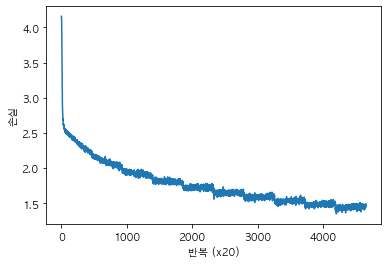

In [31]:
### 개선된 CBOW 모델 학습 코드
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 61 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 81 / 9295 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 101 / 9295 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 121 / 9295 | 시간 3[s] | 손실 4.16
| 에폭 1 |  반복 141 / 9295 | 시간 4[s] | 손실 4.16
| 에폭 1 |  반복 161 / 9295 | 시간 4[s] | 손실 4.16
| 에폭 1 |  반복 181 / 9295 | 시간 5[s] | 손실 4.16
| 에폭 1 |  반복 201 / 9295 | 시간 5[s] | 손실 4.16
| 에폭 1 |  반복 221 / 9295 | 시간 6[s] | 손실 4.16
| 에폭 1 |  반복 241 / 9295 | 시간 6[s] | 손실 4.16
| 에폭 1 |  반복 261 / 9295 | 시간 7[s] | 손실 4.16
| 에폭 1 |  반복 281 / 9295 | 시간 8[s] | 손실 4.16
| 에폭 1 |  반복 301 / 9295 | 시간 8[s] | 손실 4.16
| 에폭 1 |  반복 321 / 9295 | 시간 9[s] | 손실 4.16
| 에폭 1 |  반복 341 / 9295 | 시간 9[s] | 손실 4.16
| 에폭 1 |  반복 361 / 9295 | 시간 10[s] | 손실 4.16
| 에폭 1 |  반복 381 / 9295 | 시간 10[s] | 손실 4.16
| 에폭 1 |  반복 401 / 9295 | 시간 11[s] | 손실 4.16
| 에폭 1 |  반복 421 / 9295 | 시간 12[s] | 손실 4.16
| 에폭 1 |  반복 441 / 9295 | 시간 12[s]

| 에폭 1 |  반복 3601 / 9295 | 시간 102[s] | 손실 4.16
| 에폭 1 |  반복 3621 / 9295 | 시간 102[s] | 손실 4.16
| 에폭 1 |  반복 3641 / 9295 | 시간 103[s] | 손실 4.16
| 에폭 1 |  반복 3661 / 9295 | 시간 103[s] | 손실 4.16
| 에폭 1 |  반복 3681 / 9295 | 시간 104[s] | 손실 4.16
| 에폭 1 |  반복 3701 / 9295 | 시간 104[s] | 손실 4.16
| 에폭 1 |  반복 3721 / 9295 | 시간 105[s] | 손실 4.16
| 에폭 1 |  반복 3741 / 9295 | 시간 106[s] | 손실 4.16
| 에폭 1 |  반복 3761 / 9295 | 시간 106[s] | 손실 4.16
| 에폭 1 |  반복 3781 / 9295 | 시간 107[s] | 손실 4.16
| 에폭 1 |  반복 3801 / 9295 | 시간 107[s] | 손실 4.16
| 에폭 1 |  반복 3821 / 9295 | 시간 108[s] | 손실 4.16
| 에폭 1 |  반복 3841 / 9295 | 시간 108[s] | 손실 4.16
| 에폭 1 |  반복 3861 / 9295 | 시간 109[s] | 손실 4.16
| 에폭 1 |  반복 3881 / 9295 | 시간 110[s] | 손실 4.16
| 에폭 1 |  반복 3901 / 9295 | 시간 110[s] | 손실 4.16
| 에폭 1 |  반복 3921 / 9295 | 시간 111[s] | 손실 4.16
| 에폭 1 |  반복 3941 / 9295 | 시간 111[s] | 손실 4.16
| 에폭 1 |  반복 3961 / 9295 | 시간 112[s] | 손실 4.16
| 에폭 1 |  반복 3981 / 9295 | 시간 112[s] | 손실 4.16
| 에폭 1 |  반복 4001 / 9295 | 시간 113[s] | 손실 4.16
| 에폭 1 |  반복 

| 에폭 1 |  반복 7101 / 9295 | 시간 201[s] | 손실 4.16
| 에폭 1 |  반복 7121 / 9295 | 시간 202[s] | 손실 4.16
| 에폭 1 |  반복 7141 / 9295 | 시간 202[s] | 손실 4.16
| 에폭 1 |  반복 7161 / 9295 | 시간 203[s] | 손실 4.16
| 에폭 1 |  반복 7181 / 9295 | 시간 204[s] | 손실 4.16
| 에폭 1 |  반복 7201 / 9295 | 시간 204[s] | 손실 4.16
| 에폭 1 |  반복 7221 / 9295 | 시간 205[s] | 손실 4.16
| 에폭 1 |  반복 7241 / 9295 | 시간 205[s] | 손실 4.16
| 에폭 1 |  반복 7261 / 9295 | 시간 206[s] | 손실 4.16
| 에폭 1 |  반복 7281 / 9295 | 시간 206[s] | 손실 4.16
| 에폭 1 |  반복 7301 / 9295 | 시간 207[s] | 손실 4.16
| 에폭 1 |  반복 7321 / 9295 | 시간 208[s] | 손실 4.16
| 에폭 1 |  반복 7341 / 9295 | 시간 208[s] | 손실 4.16
| 에폭 1 |  반복 7361 / 9295 | 시간 209[s] | 손실 4.16
| 에폭 1 |  반복 7381 / 9295 | 시간 209[s] | 손실 4.16
| 에폭 1 |  반복 7401 / 9295 | 시간 210[s] | 손실 4.16
| 에폭 1 |  반복 7421 / 9295 | 시간 210[s] | 손실 4.16
| 에폭 1 |  반복 7441 / 9295 | 시간 211[s] | 손실 4.16
| 에폭 1 |  반복 7461 / 9295 | 시간 212[s] | 손실 4.16
| 에폭 1 |  반복 7481 / 9295 | 시간 212[s] | 손실 4.16
| 에폭 1 |  반복 7501 / 9295 | 시간 213[s] | 손실 4.16
| 에폭 1 |  반복 

| 에폭 2 |  반복 1321 / 9295 | 시간 302[s] | 손실 4.16
| 에폭 2 |  반복 1341 / 9295 | 시간 303[s] | 손실 4.16
| 에폭 2 |  반복 1361 / 9295 | 시간 304[s] | 손실 4.16
| 에폭 2 |  반복 1381 / 9295 | 시간 304[s] | 손실 4.16
| 에폭 2 |  반복 1401 / 9295 | 시간 305[s] | 손실 4.16
| 에폭 2 |  반복 1421 / 9295 | 시간 305[s] | 손실 4.16
| 에폭 2 |  반복 1441 / 9295 | 시간 306[s] | 손실 4.16
| 에폭 2 |  반복 1461 / 9295 | 시간 306[s] | 손실 4.16
| 에폭 2 |  반복 1481 / 9295 | 시간 307[s] | 손실 4.16
| 에폭 2 |  반복 1501 / 9295 | 시간 308[s] | 손실 4.16
| 에폭 2 |  반복 1521 / 9295 | 시간 308[s] | 손실 4.16
| 에폭 2 |  반복 1541 / 9295 | 시간 309[s] | 손실 4.16
| 에폭 2 |  반복 1561 / 9295 | 시간 309[s] | 손실 4.16
| 에폭 2 |  반복 1581 / 9295 | 시간 310[s] | 손실 4.16
| 에폭 2 |  반복 1601 / 9295 | 시간 310[s] | 손실 4.16
| 에폭 2 |  반복 1621 / 9295 | 시간 311[s] | 손실 4.16
| 에폭 2 |  반복 1641 / 9295 | 시간 312[s] | 손실 4.16
| 에폭 2 |  반복 1661 / 9295 | 시간 312[s] | 손실 4.16
| 에폭 2 |  반복 1681 / 9295 | 시간 313[s] | 손실 4.16
| 에폭 2 |  반복 1701 / 9295 | 시간 313[s] | 손실 4.16
| 에폭 2 |  반복 1721 / 9295 | 시간 314[s] | 손실 4.16
| 에폭 2 |  반복 

| 에폭 2 |  반복 4821 / 9295 | 시간 402[s] | 손실 4.16
| 에폭 2 |  반복 4841 / 9295 | 시간 402[s] | 손실 4.16
| 에폭 2 |  반복 4861 / 9295 | 시간 403[s] | 손실 4.16
| 에폭 2 |  반복 4881 / 9295 | 시간 403[s] | 손실 4.16
| 에폭 2 |  반복 4901 / 9295 | 시간 404[s] | 손실 4.16
| 에폭 2 |  반복 4921 / 9295 | 시간 405[s] | 손실 4.16
| 에폭 2 |  반복 4941 / 9295 | 시간 405[s] | 손실 4.16
| 에폭 2 |  반복 4961 / 9295 | 시간 406[s] | 손실 4.16
| 에폭 2 |  반복 4981 / 9295 | 시간 406[s] | 손실 4.16
| 에폭 2 |  반복 5001 / 9295 | 시간 407[s] | 손실 4.16
| 에폭 2 |  반복 5021 / 9295 | 시간 408[s] | 손실 4.16
| 에폭 2 |  반복 5041 / 9295 | 시간 408[s] | 손실 4.16
| 에폭 2 |  반복 5061 / 9295 | 시간 409[s] | 손실 4.16
| 에폭 2 |  반복 5081 / 9295 | 시간 409[s] | 손실 4.16
| 에폭 2 |  반복 5101 / 9295 | 시간 410[s] | 손실 4.16
| 에폭 2 |  반복 5121 / 9295 | 시간 410[s] | 손실 4.16
| 에폭 2 |  반복 5141 / 9295 | 시간 411[s] | 손실 4.16
| 에폭 2 |  반복 5161 / 9295 | 시간 412[s] | 손실 4.16
| 에폭 2 |  반복 5181 / 9295 | 시간 412[s] | 손실 4.16
| 에폭 2 |  반복 5201 / 9295 | 시간 413[s] | 손실 4.16
| 에폭 2 |  반복 5221 / 9295 | 시간 413[s] | 손실 4.16
| 에폭 2 |  반복 

| 에폭 2 |  반복 8321 / 9295 | 시간 501[s] | 손실 4.16
| 에폭 2 |  반복 8341 / 9295 | 시간 501[s] | 손실 4.16
| 에폭 2 |  반복 8361 / 9295 | 시간 502[s] | 손실 4.16
| 에폭 2 |  반복 8381 / 9295 | 시간 503[s] | 손실 4.16
| 에폭 2 |  반복 8401 / 9295 | 시간 503[s] | 손실 4.16
| 에폭 2 |  반복 8421 / 9295 | 시간 504[s] | 손실 4.16
| 에폭 2 |  반복 8441 / 9295 | 시간 504[s] | 손실 4.16
| 에폭 2 |  반복 8461 / 9295 | 시간 505[s] | 손실 4.16
| 에폭 2 |  반복 8481 / 9295 | 시간 505[s] | 손실 4.16
| 에폭 2 |  반복 8501 / 9295 | 시간 506[s] | 손실 4.16
| 에폭 2 |  반복 8521 / 9295 | 시간 506[s] | 손실 4.16
| 에폭 2 |  반복 8541 / 9295 | 시간 507[s] | 손실 4.16
| 에폭 2 |  반복 8561 / 9295 | 시간 508[s] | 손실 4.16
| 에폭 2 |  반복 8581 / 9295 | 시간 508[s] | 손실 4.16
| 에폭 2 |  반복 8601 / 9295 | 시간 509[s] | 손실 4.16
| 에폭 2 |  반복 8621 / 9295 | 시간 509[s] | 손실 4.16
| 에폭 2 |  반복 8641 / 9295 | 시간 510[s] | 손실 4.16
| 에폭 2 |  반복 8661 / 9295 | 시간 510[s] | 손실 4.16
| 에폭 2 |  반복 8681 / 9295 | 시간 511[s] | 손실 4.16
| 에폭 2 |  반복 8701 / 9295 | 시간 512[s] | 손실 4.16
| 에폭 2 |  반복 8721 / 9295 | 시간 512[s] | 손실 4.16
| 에폭 2 |  반복 

| 에폭 3 |  반복 2541 / 9295 | 시간 600[s] | 손실 4.16
| 에폭 3 |  반복 2561 / 9295 | 시간 600[s] | 손실 4.16
| 에폭 3 |  반복 2581 / 9295 | 시간 601[s] | 손실 4.16
| 에폭 3 |  반복 2601 / 9295 | 시간 602[s] | 손실 4.16
| 에폭 3 |  반복 2621 / 9295 | 시간 602[s] | 손실 4.16
| 에폭 3 |  반복 2641 / 9295 | 시간 603[s] | 손실 4.16
| 에폭 3 |  반복 2661 / 9295 | 시간 603[s] | 손실 4.16
| 에폭 3 |  반복 2681 / 9295 | 시간 604[s] | 손실 4.16
| 에폭 3 |  반복 2701 / 9295 | 시간 604[s] | 손실 4.16
| 에폭 3 |  반복 2721 / 9295 | 시간 605[s] | 손실 4.16
| 에폭 3 |  반복 2741 / 9295 | 시간 605[s] | 손실 4.16
| 에폭 3 |  반복 2761 / 9295 | 시간 606[s] | 손실 4.16
| 에폭 3 |  반복 2781 / 9295 | 시간 607[s] | 손실 4.16
| 에폭 3 |  반복 2801 / 9295 | 시간 607[s] | 손실 4.16
| 에폭 3 |  반복 2821 / 9295 | 시간 608[s] | 손실 4.16
| 에폭 3 |  반복 2841 / 9295 | 시간 608[s] | 손실 4.16
| 에폭 3 |  반복 2861 / 9295 | 시간 609[s] | 손실 4.16
| 에폭 3 |  반복 2881 / 9295 | 시간 609[s] | 손실 4.16
| 에폭 3 |  반복 2901 / 9295 | 시간 610[s] | 손실 4.16
| 에폭 3 |  반복 2921 / 9295 | 시간 610[s] | 손실 4.16
| 에폭 3 |  반복 2941 / 9295 | 시간 611[s] | 손실 4.16
| 에폭 3 |  반복 

| 에폭 3 |  반복 6041 / 9295 | 시간 698[s] | 손실 4.16
| 에폭 3 |  반복 6061 / 9295 | 시간 699[s] | 손실 4.16
| 에폭 3 |  반복 6081 / 9295 | 시간 699[s] | 손실 4.16
| 에폭 3 |  반복 6101 / 9295 | 시간 700[s] | 손실 4.16
| 에폭 3 |  반복 6121 / 9295 | 시간 701[s] | 손실 4.16
| 에폭 3 |  반복 6141 / 9295 | 시간 701[s] | 손실 4.16
| 에폭 3 |  반복 6161 / 9295 | 시간 702[s] | 손실 4.16
| 에폭 3 |  반복 6181 / 9295 | 시간 702[s] | 손실 4.16
| 에폭 3 |  반복 6201 / 9295 | 시간 703[s] | 손실 4.16
| 에폭 3 |  반복 6221 / 9295 | 시간 703[s] | 손실 4.16
| 에폭 3 |  반복 6241 / 9295 | 시간 704[s] | 손실 4.16
| 에폭 3 |  반복 6261 / 9295 | 시간 705[s] | 손실 4.16
| 에폭 3 |  반복 6281 / 9295 | 시간 705[s] | 손실 4.16
| 에폭 3 |  반복 6301 / 9295 | 시간 706[s] | 손실 4.16
| 에폭 3 |  반복 6321 / 9295 | 시간 706[s] | 손실 4.16
| 에폭 3 |  반복 6341 / 9295 | 시간 707[s] | 손실 4.16
| 에폭 3 |  반복 6361 / 9295 | 시간 707[s] | 손실 4.16
| 에폭 3 |  반복 6381 / 9295 | 시간 708[s] | 손실 4.16
| 에폭 3 |  반복 6401 / 9295 | 시간 709[s] | 손실 4.16
| 에폭 3 |  반복 6421 / 9295 | 시간 709[s] | 손실 4.16
| 에폭 3 |  반복 6441 / 9295 | 시간 710[s] | 손실 4.16
| 에폭 3 |  반복 

| 에폭 4 |  반복 241 / 9295 | 시간 798[s] | 손실 4.16
| 에폭 4 |  반복 261 / 9295 | 시간 798[s] | 손실 4.16
| 에폭 4 |  반복 281 / 9295 | 시간 799[s] | 손실 4.16
| 에폭 4 |  반복 301 / 9295 | 시간 799[s] | 손실 4.16
| 에폭 4 |  반복 321 / 9295 | 시간 800[s] | 손실 4.16
| 에폭 4 |  반복 341 / 9295 | 시간 801[s] | 손실 4.16
| 에폭 4 |  반복 361 / 9295 | 시간 801[s] | 손실 4.16
| 에폭 4 |  반복 381 / 9295 | 시간 802[s] | 손실 4.16
| 에폭 4 |  반복 401 / 9295 | 시간 802[s] | 손실 4.16
| 에폭 4 |  반복 421 / 9295 | 시간 803[s] | 손실 4.16
| 에폭 4 |  반복 441 / 9295 | 시간 803[s] | 손실 4.16
| 에폭 4 |  반복 461 / 9295 | 시간 804[s] | 손실 4.16
| 에폭 4 |  반복 481 / 9295 | 시간 805[s] | 손실 4.16
| 에폭 4 |  반복 501 / 9295 | 시간 805[s] | 손실 4.16
| 에폭 4 |  반복 521 / 9295 | 시간 806[s] | 손실 4.16
| 에폭 4 |  반복 541 / 9295 | 시간 806[s] | 손실 4.16
| 에폭 4 |  반복 561 / 9295 | 시간 807[s] | 손실 4.16
| 에폭 4 |  반복 581 / 9295 | 시간 807[s] | 손실 4.16
| 에폭 4 |  반복 601 / 9295 | 시간 808[s] | 손실 4.16
| 에폭 4 |  반복 621 / 9295 | 시간 809[s] | 손실 4.16
| 에폭 4 |  반복 641 / 9295 | 시간 809[s] | 손실 4.16
| 에폭 4 |  반복 661 / 9295 | 시간 810[s

| 에폭 4 |  반복 3761 / 9295 | 시간 897[s] | 손실 4.16
| 에폭 4 |  반복 3781 / 9295 | 시간 898[s] | 손실 4.16
| 에폭 4 |  반복 3801 / 9295 | 시간 899[s] | 손실 4.16
| 에폭 4 |  반복 3821 / 9295 | 시간 899[s] | 손실 4.16
| 에폭 4 |  반복 3841 / 9295 | 시간 900[s] | 손실 4.16
| 에폭 4 |  반복 3861 / 9295 | 시간 900[s] | 손실 4.16
| 에폭 4 |  반복 3881 / 9295 | 시간 901[s] | 손실 4.16
| 에폭 4 |  반복 3901 / 9295 | 시간 901[s] | 손실 4.16
| 에폭 4 |  반복 3921 / 9295 | 시간 902[s] | 손실 4.16
| 에폭 4 |  반복 3941 / 9295 | 시간 903[s] | 손실 4.16
| 에폭 4 |  반복 3961 / 9295 | 시간 903[s] | 손실 4.16
| 에폭 4 |  반복 3981 / 9295 | 시간 904[s] | 손실 4.16
| 에폭 4 |  반복 4001 / 9295 | 시간 904[s] | 손실 4.16
| 에폭 4 |  반복 4021 / 9295 | 시간 905[s] | 손실 4.16
| 에폭 4 |  반복 4041 / 9295 | 시간 905[s] | 손실 4.16
| 에폭 4 |  반복 4061 / 9295 | 시간 906[s] | 손실 4.16
| 에폭 4 |  반복 4081 / 9295 | 시간 907[s] | 손실 4.16
| 에폭 4 |  반복 4101 / 9295 | 시간 907[s] | 손실 4.16
| 에폭 4 |  반복 4121 / 9295 | 시간 908[s] | 손실 4.16
| 에폭 4 |  반복 4141 / 9295 | 시간 908[s] | 손실 4.16
| 에폭 4 |  반복 4161 / 9295 | 시간 909[s] | 손실 4.16
| 에폭 4 |  반복 

| 에폭 4 |  반복 7261 / 9295 | 시간 997[s] | 손실 4.16
| 에폭 4 |  반복 7281 / 9295 | 시간 997[s] | 손실 4.16
| 에폭 4 |  반복 7301 / 9295 | 시간 998[s] | 손실 4.16
| 에폭 4 |  반복 7321 / 9295 | 시간 998[s] | 손실 4.16
| 에폭 4 |  반복 7341 / 9295 | 시간 999[s] | 손실 4.16
| 에폭 4 |  반복 7361 / 9295 | 시간 1000[s] | 손실 4.16
| 에폭 4 |  반복 7381 / 9295 | 시간 1000[s] | 손실 4.16
| 에폭 4 |  반복 7401 / 9295 | 시간 1001[s] | 손실 4.16
| 에폭 4 |  반복 7421 / 9295 | 시간 1001[s] | 손실 4.16
| 에폭 4 |  반복 7441 / 9295 | 시간 1002[s] | 손실 4.16
| 에폭 4 |  반복 7461 / 9295 | 시간 1002[s] | 손실 4.16
| 에폭 4 |  반복 7481 / 9295 | 시간 1003[s] | 손실 4.16
| 에폭 4 |  반복 7501 / 9295 | 시간 1004[s] | 손실 4.16
| 에폭 4 |  반복 7521 / 9295 | 시간 1004[s] | 손실 4.16
| 에폭 4 |  반복 7541 / 9295 | 시간 1005[s] | 손실 4.16
| 에폭 4 |  반복 7561 / 9295 | 시간 1005[s] | 손실 4.16
| 에폭 4 |  반복 7581 / 9295 | 시간 1006[s] | 손실 4.16
| 에폭 4 |  반복 7601 / 9295 | 시간 1006[s] | 손실 4.16
| 에폭 4 |  반복 7621 / 9295 | 시간 1007[s] | 손실 4.16
| 에폭 4 |  반복 7641 / 9295 | 시간 1008[s] | 손실 4.16
| 에폭 4 |  반복 7661 / 9295 | 시간 1008[s] | 손실 4.

| 에폭 5 |  반복 1401 / 9295 | 시간 1096[s] | 손실 4.16
| 에폭 5 |  반복 1421 / 9295 | 시간 1097[s] | 손실 4.16
| 에폭 5 |  반복 1441 / 9295 | 시간 1097[s] | 손실 4.15
| 에폭 5 |  반복 1461 / 9295 | 시간 1098[s] | 손실 4.16
| 에폭 5 |  반복 1481 / 9295 | 시간 1098[s] | 손실 4.15
| 에폭 5 |  반복 1501 / 9295 | 시간 1099[s] | 손실 4.15
| 에폭 5 |  반복 1521 / 9295 | 시간 1099[s] | 손실 4.15
| 에폭 5 |  반복 1541 / 9295 | 시간 1100[s] | 손실 4.15
| 에폭 5 |  반복 1561 / 9295 | 시간 1101[s] | 손실 4.16
| 에폭 5 |  반복 1581 / 9295 | 시간 1101[s] | 손실 4.15
| 에폭 5 |  반복 1601 / 9295 | 시간 1102[s] | 손실 4.15
| 에폭 5 |  반복 1621 / 9295 | 시간 1102[s] | 손실 4.15
| 에폭 5 |  반복 1641 / 9295 | 시간 1103[s] | 손실 4.15
| 에폭 5 |  반복 1661 / 9295 | 시간 1103[s] | 손실 4.15
| 에폭 5 |  반복 1681 / 9295 | 시간 1104[s] | 손실 4.16
| 에폭 5 |  반복 1701 / 9295 | 시간 1105[s] | 손실 4.15
| 에폭 5 |  반복 1721 / 9295 | 시간 1105[s] | 손실 4.15
| 에폭 5 |  반복 1741 / 9295 | 시간 1106[s] | 손실 4.15
| 에폭 5 |  반복 1761 / 9295 | 시간 1106[s] | 손실 4.15
| 에폭 5 |  반복 1781 / 9295 | 시간 1107[s] | 손실 4.16
| 에폭 5 |  반복 1801 / 9295 | 시간 1107[s] | 

| 에폭 5 |  반복 4821 / 9295 | 시간 1193[s] | 손실 4.15
| 에폭 5 |  반복 4841 / 9295 | 시간 1194[s] | 손실 4.15
| 에폭 5 |  반복 4861 / 9295 | 시간 1194[s] | 손실 4.15
| 에폭 5 |  반복 4881 / 9295 | 시간 1195[s] | 손실 4.15
| 에폭 5 |  반복 4901 / 9295 | 시간 1196[s] | 손실 4.15
| 에폭 5 |  반복 4921 / 9295 | 시간 1196[s] | 손실 4.15
| 에폭 5 |  반복 4941 / 9295 | 시간 1197[s] | 손실 4.15
| 에폭 5 |  반복 4961 / 9295 | 시간 1197[s] | 손실 4.15
| 에폭 5 |  반복 4981 / 9295 | 시간 1198[s] | 손실 4.15
| 에폭 5 |  반복 5001 / 9295 | 시간 1198[s] | 손실 4.15
| 에폭 5 |  반복 5021 / 9295 | 시간 1199[s] | 손실 4.15
| 에폭 5 |  반복 5041 / 9295 | 시간 1200[s] | 손실 4.15
| 에폭 5 |  반복 5061 / 9295 | 시간 1200[s] | 손실 4.15
| 에폭 5 |  반복 5081 / 9295 | 시간 1201[s] | 손실 4.15
| 에폭 5 |  반복 5101 / 9295 | 시간 1201[s] | 손실 4.15
| 에폭 5 |  반복 5121 / 9295 | 시간 1202[s] | 손실 4.15
| 에폭 5 |  반복 5141 / 9295 | 시간 1202[s] | 손실 4.15
| 에폭 5 |  반복 5161 / 9295 | 시간 1203[s] | 손실 4.15
| 에폭 5 |  반복 5181 / 9295 | 시간 1204[s] | 손실 4.15
| 에폭 5 |  반복 5201 / 9295 | 시간 1204[s] | 손실 4.15
| 에폭 5 |  반복 5221 / 9295 | 시간 1205[s] | 

| 에폭 5 |  반복 8241 / 9295 | 시간 1291[s] | 손실 4.15
| 에폭 5 |  반복 8261 / 9295 | 시간 1291[s] | 손실 4.15
| 에폭 5 |  반복 8281 / 9295 | 시간 1292[s] | 손실 4.15
| 에폭 5 |  반복 8301 / 9295 | 시간 1293[s] | 손실 4.15
| 에폭 5 |  반복 8321 / 9295 | 시간 1293[s] | 손실 4.15
| 에폭 5 |  반복 8341 / 9295 | 시간 1294[s] | 손실 4.15
| 에폭 5 |  반복 8361 / 9295 | 시간 1294[s] | 손실 4.15
| 에폭 5 |  반복 8381 / 9295 | 시간 1295[s] | 손실 4.15
| 에폭 5 |  반복 8401 / 9295 | 시간 1295[s] | 손실 4.15
| 에폭 5 |  반복 8421 / 9295 | 시간 1296[s] | 손실 4.15
| 에폭 5 |  반복 8441 / 9295 | 시간 1297[s] | 손실 4.15
| 에폭 5 |  반복 8461 / 9295 | 시간 1297[s] | 손실 4.15
| 에폭 5 |  반복 8481 / 9295 | 시간 1298[s] | 손실 4.15
| 에폭 5 |  반복 8501 / 9295 | 시간 1298[s] | 손실 4.15
| 에폭 5 |  반복 8521 / 9295 | 시간 1299[s] | 손실 4.15
| 에폭 5 |  반복 8541 / 9295 | 시간 1299[s] | 손실 4.15
| 에폭 5 |  반복 8561 / 9295 | 시간 1300[s] | 손실 4.15
| 에폭 5 |  반복 8581 / 9295 | 시간 1301[s] | 손실 4.15
| 에폭 5 |  반복 8601 / 9295 | 시간 1301[s] | 손실 4.15
| 에폭 5 |  반복 8621 / 9295 | 시간 1302[s] | 손실 4.15
| 에폭 5 |  반복 8641 / 9295 | 시간 1302[s] | 

| 에폭 6 |  반복 2381 / 9295 | 시간 1389[s] | 손실 4.15
| 에폭 6 |  반복 2401 / 9295 | 시간 1390[s] | 손실 4.15
| 에폭 6 |  반복 2421 / 9295 | 시간 1390[s] | 손실 4.15
| 에폭 6 |  반복 2441 / 9295 | 시간 1391[s] | 손실 4.15
| 에폭 6 |  반복 2461 / 9295 | 시간 1392[s] | 손실 4.15
| 에폭 6 |  반복 2481 / 9295 | 시간 1392[s] | 손실 4.15
| 에폭 6 |  반복 2501 / 9295 | 시간 1393[s] | 손실 4.15
| 에폭 6 |  반복 2521 / 9295 | 시간 1393[s] | 손실 4.15
| 에폭 6 |  반복 2541 / 9295 | 시간 1394[s] | 손실 4.15
| 에폭 6 |  반복 2561 / 9295 | 시간 1395[s] | 손실 4.15
| 에폭 6 |  반복 2581 / 9295 | 시간 1395[s] | 손실 4.15
| 에폭 6 |  반복 2601 / 9295 | 시간 1396[s] | 손실 4.15
| 에폭 6 |  반복 2621 / 9295 | 시간 1396[s] | 손실 4.15
| 에폭 6 |  반복 2641 / 9295 | 시간 1397[s] | 손실 4.15
| 에폭 6 |  반복 2661 / 9295 | 시간 1397[s] | 손실 4.15
| 에폭 6 |  반복 2681 / 9295 | 시간 1398[s] | 손실 4.15
| 에폭 6 |  반복 2701 / 9295 | 시간 1399[s] | 손실 4.15
| 에폭 6 |  반복 2721 / 9295 | 시간 1399[s] | 손실 4.14
| 에폭 6 |  반복 2741 / 9295 | 시간 1400[s] | 손실 4.15
| 에폭 6 |  반복 2761 / 9295 | 시간 1400[s] | 손실 4.15
| 에폭 6 |  반복 2781 / 9295 | 시간 1401[s] | 

| 에폭 6 |  반복 5801 / 9295 | 시간 1488[s] | 손실 4.14
| 에폭 6 |  반복 5821 / 9295 | 시간 1488[s] | 손실 4.14
| 에폭 6 |  반복 5841 / 9295 | 시간 1489[s] | 손실 4.14
| 에폭 6 |  반복 5861 / 9295 | 시간 1489[s] | 손실 4.14
| 에폭 6 |  반복 5881 / 9295 | 시간 1490[s] | 손실 4.14
| 에폭 6 |  반복 5901 / 9295 | 시간 1491[s] | 손실 4.14
| 에폭 6 |  반복 5921 / 9295 | 시간 1491[s] | 손실 4.14
| 에폭 6 |  반복 5941 / 9295 | 시간 1492[s] | 손실 4.14
| 에폭 6 |  반복 5961 / 9295 | 시간 1492[s] | 손실 4.14
| 에폭 6 |  반복 5981 / 9295 | 시간 1493[s] | 손실 4.14
| 에폭 6 |  반복 6001 / 9295 | 시간 1493[s] | 손실 4.14
| 에폭 6 |  반복 6021 / 9295 | 시간 1494[s] | 손실 4.14
| 에폭 6 |  반복 6041 / 9295 | 시간 1495[s] | 손실 4.14
| 에폭 6 |  반복 6061 / 9295 | 시간 1495[s] | 손실 4.14
| 에폭 6 |  반복 6081 / 9295 | 시간 1496[s] | 손실 4.14
| 에폭 6 |  반복 6101 / 9295 | 시간 1496[s] | 손실 4.14
| 에폭 6 |  반복 6121 / 9295 | 시간 1497[s] | 손실 4.14
| 에폭 6 |  반복 6141 / 9295 | 시간 1497[s] | 손실 4.14
| 에폭 6 |  반복 6161 / 9295 | 시간 1498[s] | 손실 4.14
| 에폭 6 |  반복 6181 / 9295 | 시간 1499[s] | 손실 4.14
| 에폭 6 |  반복 6201 / 9295 | 시간 1499[s] | 

| 에폭 6 |  반복 9221 / 9295 | 시간 1585[s] | 손실 4.13
| 에폭 6 |  반복 9241 / 9295 | 시간 1586[s] | 손실 4.13
| 에폭 6 |  반복 9261 / 9295 | 시간 1587[s] | 손실 4.13
| 에폭 6 |  반복 9281 / 9295 | 시간 1587[s] | 손실 4.13
| 에폭 7 |  반복 1 / 9295 | 시간 1588[s] | 손실 4.13
| 에폭 7 |  반복 21 / 9295 | 시간 1588[s] | 손실 4.13
| 에폭 7 |  반복 41 / 9295 | 시간 1589[s] | 손실 4.13
| 에폭 7 |  반복 61 / 9295 | 시간 1590[s] | 손실 4.13
| 에폭 7 |  반복 81 / 9295 | 시간 1590[s] | 손실 4.13
| 에폭 7 |  반복 101 / 9295 | 시간 1591[s] | 손실 4.13
| 에폭 7 |  반복 121 / 9295 | 시간 1591[s] | 손실 4.13
| 에폭 7 |  반복 141 / 9295 | 시간 1592[s] | 손실 4.13
| 에폭 7 |  반복 161 / 9295 | 시간 1592[s] | 손실 4.13
| 에폭 7 |  반복 181 / 9295 | 시간 1593[s] | 손실 4.13
| 에폭 7 |  반복 201 / 9295 | 시간 1594[s] | 손실 4.13
| 에폭 7 |  반복 221 / 9295 | 시간 1594[s] | 손실 4.13
| 에폭 7 |  반복 241 / 9295 | 시간 1595[s] | 손실 4.13
| 에폭 7 |  반복 261 / 9295 | 시간 1595[s] | 손실 4.13
| 에폭 7 |  반복 281 / 9295 | 시간 1596[s] | 손실 4.13
| 에폭 7 |  반복 301 / 9295 | 시간 1596[s] | 손실 4.13
| 에폭 7 |  반복 321 / 9295 | 시간 1597[s] | 손실 4.13
| 에폭 7 |  반복 34

| 에폭 7 |  반복 3361 / 9295 | 시간 1684[s] | 손실 4.12
| 에폭 7 |  반복 3381 / 9295 | 시간 1684[s] | 손실 4.12
| 에폭 7 |  반복 3401 / 9295 | 시간 1685[s] | 손실 4.12
| 에폭 7 |  반복 3421 / 9295 | 시간 1685[s] | 손실 4.12
| 에폭 7 |  반복 3441 / 9295 | 시간 1686[s] | 손실 4.12
| 에폭 7 |  반복 3461 / 9295 | 시간 1686[s] | 손실 4.12
| 에폭 7 |  반복 3481 / 9295 | 시간 1687[s] | 손실 4.12
| 에폭 7 |  반복 3501 / 9295 | 시간 1687[s] | 손실 4.12
| 에폭 7 |  반복 3521 / 9295 | 시간 1688[s] | 손실 4.12
| 에폭 7 |  반복 3541 / 9295 | 시간 1689[s] | 손실 4.12
| 에폭 7 |  반복 3561 / 9295 | 시간 1689[s] | 손실 4.12
| 에폭 7 |  반복 3581 / 9295 | 시간 1690[s] | 손실 4.12
| 에폭 7 |  반복 3601 / 9295 | 시간 1690[s] | 손실 4.12
| 에폭 7 |  반복 3621 / 9295 | 시간 1691[s] | 손실 4.12
| 에폭 7 |  반복 3641 / 9295 | 시간 1691[s] | 손실 4.12
| 에폭 7 |  반복 3661 / 9295 | 시간 1692[s] | 손실 4.12
| 에폭 7 |  반복 3681 / 9295 | 시간 1693[s] | 손실 4.12
| 에폭 7 |  반복 3701 / 9295 | 시간 1693[s] | 손실 4.12
| 에폭 7 |  반복 3721 / 9295 | 시간 1694[s] | 손실 4.12
| 에폭 7 |  반복 3741 / 9295 | 시간 1694[s] | 손실 4.12
| 에폭 7 |  반복 3761 / 9295 | 시간 1695[s] | 

| 에폭 7 |  반복 6781 / 9295 | 시간 1780[s] | 손실 4.10
| 에폭 7 |  반복 6801 / 9295 | 시간 1781[s] | 손실 4.11
| 에폭 7 |  반복 6821 / 9295 | 시간 1782[s] | 손실 4.11
| 에폭 7 |  반복 6841 / 9295 | 시간 1782[s] | 손실 4.11
| 에폭 7 |  반복 6861 / 9295 | 시간 1783[s] | 손실 4.11
| 에폭 7 |  반복 6881 / 9295 | 시간 1783[s] | 손실 4.11
| 에폭 7 |  반복 6901 / 9295 | 시간 1784[s] | 손실 4.10
| 에폭 7 |  반복 6921 / 9295 | 시간 1784[s] | 손실 4.11
| 에폭 7 |  반복 6941 / 9295 | 시간 1785[s] | 손실 4.11
| 에폭 7 |  반복 6961 / 9295 | 시간 1785[s] | 손실 4.11
| 에폭 7 |  반복 6981 / 9295 | 시간 1786[s] | 손실 4.10
| 에폭 7 |  반복 7001 / 9295 | 시간 1787[s] | 손실 4.11
| 에폭 7 |  반복 7021 / 9295 | 시간 1787[s] | 손실 4.11
| 에폭 7 |  반복 7041 / 9295 | 시간 1788[s] | 손실 4.11
| 에폭 7 |  반복 7061 / 9295 | 시간 1788[s] | 손실 4.11
| 에폭 7 |  반복 7081 / 9295 | 시간 1789[s] | 손실 4.11
| 에폭 7 |  반복 7101 / 9295 | 시간 1789[s] | 손실 4.11
| 에폭 7 |  반복 7121 / 9295 | 시간 1790[s] | 손실 4.11
| 에폭 7 |  반복 7141 / 9295 | 시간 1791[s] | 손실 4.11
| 에폭 7 |  반복 7161 / 9295 | 시간 1791[s] | 손실 4.10
| 에폭 7 |  반복 7181 / 9295 | 시간 1792[s] | 

| 에폭 8 |  반복 921 / 9295 | 시간 1878[s] | 손실 4.09
| 에폭 8 |  반복 941 / 9295 | 시간 1878[s] | 손실 4.09
| 에폭 8 |  반복 961 / 9295 | 시간 1879[s] | 손실 4.09
| 에폭 8 |  반복 981 / 9295 | 시간 1879[s] | 손실 4.09
| 에폭 8 |  반복 1001 / 9295 | 시간 1880[s] | 손실 4.09
| 에폭 8 |  반복 1021 / 9295 | 시간 1880[s] | 손실 4.09
| 에폭 8 |  반복 1041 / 9295 | 시간 1881[s] | 손실 4.09
| 에폭 8 |  반복 1061 / 9295 | 시간 1882[s] | 손실 4.09
| 에폭 8 |  반복 1081 / 9295 | 시간 1882[s] | 손실 4.09
| 에폭 8 |  반복 1101 / 9295 | 시간 1883[s] | 손실 4.09
| 에폭 8 |  반복 1121 / 9295 | 시간 1883[s] | 손실 4.09
| 에폭 8 |  반복 1141 / 9295 | 시간 1884[s] | 손실 4.09
| 에폭 8 |  반복 1161 / 9295 | 시간 1884[s] | 손실 4.09
| 에폭 8 |  반복 1181 / 9295 | 시간 1885[s] | 손실 4.09
| 에폭 8 |  반복 1201 / 9295 | 시간 1886[s] | 손실 4.09
| 에폭 8 |  반복 1221 / 9295 | 시간 1886[s] | 손실 4.09
| 에폭 8 |  반복 1241 / 9295 | 시간 1887[s] | 손실 4.09
| 에폭 8 |  반복 1261 / 9295 | 시간 1887[s] | 손실 4.09
| 에폭 8 |  반복 1281 / 9295 | 시간 1888[s] | 손실 4.09
| 에폭 8 |  반복 1301 / 9295 | 시간 1888[s] | 손실 4.09
| 에폭 8 |  반복 1321 / 9295 | 시간 1889[s] | 손실 4

| 에폭 8 |  반복 4341 / 9295 | 시간 1976[s] | 손실 4.07
| 에폭 8 |  반복 4361 / 9295 | 시간 1976[s] | 손실 4.07
| 에폭 8 |  반복 4381 / 9295 | 시간 1977[s] | 손실 4.08
| 에폭 8 |  반복 4401 / 9295 | 시간 1977[s] | 손실 4.06
| 에폭 8 |  반복 4421 / 9295 | 시간 1978[s] | 손실 4.07
| 에폭 8 |  반복 4441 / 9295 | 시간 1979[s] | 손실 4.07
| 에폭 8 |  반복 4461 / 9295 | 시간 1979[s] | 손실 4.07
| 에폭 8 |  반복 4481 / 9295 | 시간 1980[s] | 손실 4.07
| 에폭 8 |  반복 4501 / 9295 | 시간 1980[s] | 손실 4.07
| 에폭 8 |  반복 4521 / 9295 | 시간 1981[s] | 손실 4.07
| 에폭 8 |  반복 4541 / 9295 | 시간 1981[s] | 손실 4.07
| 에폭 8 |  반복 4561 / 9295 | 시간 1982[s] | 손실 4.08
| 에폭 8 |  반복 4581 / 9295 | 시간 1983[s] | 손실 4.08
| 에폭 8 |  반복 4601 / 9295 | 시간 1983[s] | 손실 4.07
| 에폭 8 |  반복 4621 / 9295 | 시간 1984[s] | 손실 4.08
| 에폭 8 |  반복 4641 / 9295 | 시간 1984[s] | 손실 4.07
| 에폭 8 |  반복 4661 / 9295 | 시간 1985[s] | 손실 4.07
| 에폭 8 |  반복 4681 / 9295 | 시간 1985[s] | 손실 4.08
| 에폭 8 |  반복 4701 / 9295 | 시간 1986[s] | 손실 4.07
| 에폭 8 |  반복 4721 / 9295 | 시간 1987[s] | 손실 4.07
| 에폭 8 |  반복 4741 / 9295 | 시간 1987[s] | 

| 에폭 8 |  반복 7761 / 9295 | 시간 2073[s] | 손실 4.06
| 에폭 8 |  반복 7781 / 9295 | 시간 2073[s] | 손실 4.05
| 에폭 8 |  반복 7801 / 9295 | 시간 2074[s] | 손실 4.05
| 에폭 8 |  반복 7821 / 9295 | 시간 2075[s] | 손실 4.06
| 에폭 8 |  반복 7841 / 9295 | 시간 2075[s] | 손실 4.05
| 에폭 8 |  반복 7861 / 9295 | 시간 2076[s] | 손실 4.06
| 에폭 8 |  반복 7881 / 9295 | 시간 2076[s] | 손실 4.05
| 에폭 8 |  반복 7901 / 9295 | 시간 2077[s] | 손실 4.05
| 에폭 8 |  반복 7921 / 9295 | 시간 2077[s] | 손실 4.05
| 에폭 8 |  반복 7941 / 9295 | 시간 2078[s] | 손실 4.05
| 에폭 8 |  반복 7961 / 9295 | 시간 2079[s] | 손실 4.04
| 에폭 8 |  반복 7981 / 9295 | 시간 2079[s] | 손실 4.05
| 에폭 8 |  반복 8001 / 9295 | 시간 2080[s] | 손실 4.05
| 에폭 8 |  반복 8021 / 9295 | 시간 2080[s] | 손실 4.05
| 에폭 8 |  반복 8041 / 9295 | 시간 2081[s] | 손실 4.05
| 에폭 8 |  반복 8061 / 9295 | 시간 2082[s] | 손실 4.05
| 에폭 8 |  반복 8081 / 9295 | 시간 2082[s] | 손실 4.05
| 에폭 8 |  반복 8101 / 9295 | 시간 2083[s] | 손실 4.05
| 에폭 8 |  반복 8121 / 9295 | 시간 2083[s] | 손실 4.05
| 에폭 8 |  반복 8141 / 9295 | 시간 2084[s] | 손실 4.05
| 에폭 8 |  반복 8161 / 9295 | 시간 2084[s] | 

| 에폭 9 |  반복 1901 / 9295 | 시간 2171[s] | 손실 4.03
| 에폭 9 |  반복 1921 / 9295 | 시간 2172[s] | 손실 4.02
| 에폭 9 |  반복 1941 / 9295 | 시간 2172[s] | 손실 4.03
| 에폭 9 |  반복 1961 / 9295 | 시간 2173[s] | 손실 4.03
| 에폭 9 |  반복 1981 / 9295 | 시간 2173[s] | 손실 4.04
| 에폭 9 |  반복 2001 / 9295 | 시간 2174[s] | 손실 4.03
| 에폭 9 |  반복 2021 / 9295 | 시간 2175[s] | 손실 4.03
| 에폭 9 |  반복 2041 / 9295 | 시간 2175[s] | 손실 4.02
| 에폭 9 |  반복 2061 / 9295 | 시간 2176[s] | 손실 4.03
| 에폭 9 |  반복 2081 / 9295 | 시간 2176[s] | 손실 4.03
| 에폭 9 |  반복 2101 / 9295 | 시간 2177[s] | 손실 4.03
| 에폭 9 |  반복 2121 / 9295 | 시간 2177[s] | 손실 4.03
| 에폭 9 |  반복 2141 / 9295 | 시간 2178[s] | 손실 4.04
| 에폭 9 |  반복 2161 / 9295 | 시간 2179[s] | 손실 4.02
| 에폭 9 |  반복 2181 / 9295 | 시간 2179[s] | 손실 4.03
| 에폭 9 |  반복 2201 / 9295 | 시간 2180[s] | 손실 4.02
| 에폭 9 |  반복 2221 / 9295 | 시간 2180[s] | 손실 4.02
| 에폭 9 |  반복 2241 / 9295 | 시간 2181[s] | 손실 4.03
| 에폭 9 |  반복 2261 / 9295 | 시간 2181[s] | 손실 4.02
| 에폭 9 |  반복 2281 / 9295 | 시간 2182[s] | 손실 4.02
| 에폭 9 |  반복 2301 / 9295 | 시간 2183[s] | 

| 에폭 9 |  반복 5321 / 9295 | 시간 2269[s] | 손실 4.01
| 에폭 9 |  반복 5341 / 9295 | 시간 2270[s] | 손실 4.01
| 에폭 9 |  반복 5361 / 9295 | 시간 2270[s] | 손실 4.00
| 에폭 9 |  반복 5381 / 9295 | 시간 2271[s] | 손실 4.01
| 에폭 9 |  반복 5401 / 9295 | 시간 2272[s] | 손실 4.00
| 에폭 9 |  반복 5421 / 9295 | 시간 2272[s] | 손실 4.00
| 에폭 9 |  반복 5441 / 9295 | 시간 2273[s] | 손실 4.01
| 에폭 9 |  반복 5461 / 9295 | 시간 2273[s] | 손실 4.00
| 에폭 9 |  반복 5481 / 9295 | 시간 2274[s] | 손실 4.00
| 에폭 9 |  반복 5501 / 9295 | 시간 2274[s] | 손실 4.00
| 에폭 9 |  반복 5521 / 9295 | 시간 2275[s] | 손실 4.00
| 에폭 9 |  반복 5541 / 9295 | 시간 2276[s] | 손실 4.01
| 에폭 9 |  반복 5561 / 9295 | 시간 2276[s] | 손실 4.01
| 에폭 9 |  반복 5581 / 9295 | 시간 2277[s] | 손실 4.01
| 에폭 9 |  반복 5601 / 9295 | 시간 2277[s] | 손실 4.00
| 에폭 9 |  반복 5621 / 9295 | 시간 2278[s] | 손실 4.01
| 에폭 9 |  반복 5641 / 9295 | 시간 2278[s] | 손실 4.00
| 에폭 9 |  반복 5661 / 9295 | 시간 2279[s] | 손실 4.00
| 에폭 9 |  반복 5681 / 9295 | 시간 2280[s] | 손실 4.00
| 에폭 9 |  반복 5701 / 9295 | 시간 2280[s] | 손실 4.00
| 에폭 9 |  반복 5721 / 9295 | 시간 2281[s] | 

| 에폭 9 |  반복 8741 / 9295 | 시간 2367[s] | 손실 3.99
| 에폭 9 |  반복 8761 / 9295 | 시간 2368[s] | 손실 3.99
| 에폭 9 |  반복 8781 / 9295 | 시간 2368[s] | 손실 3.99
| 에폭 9 |  반복 8801 / 9295 | 시간 2369[s] | 손실 3.98
| 에폭 9 |  반복 8821 / 9295 | 시간 2370[s] | 손실 3.98
| 에폭 9 |  반복 8841 / 9295 | 시간 2370[s] | 손실 3.98
| 에폭 9 |  반복 8861 / 9295 | 시간 2371[s] | 손실 3.98
| 에폭 9 |  반복 8881 / 9295 | 시간 2371[s] | 손실 3.98
| 에폭 9 |  반복 8901 / 9295 | 시간 2372[s] | 손실 3.98
| 에폭 9 |  반복 8921 / 9295 | 시간 2372[s] | 손실 3.97
| 에폭 9 |  반복 8941 / 9295 | 시간 2373[s] | 손실 3.98
| 에폭 9 |  반복 8961 / 9295 | 시간 2373[s] | 손실 3.98
| 에폭 9 |  반복 8981 / 9295 | 시간 2374[s] | 손실 3.97
| 에폭 9 |  반복 9001 / 9295 | 시간 2375[s] | 손실 3.98
| 에폭 9 |  반복 9021 / 9295 | 시간 2375[s] | 손실 3.97
| 에폭 9 |  반복 9041 / 9295 | 시간 2376[s] | 손실 3.97
| 에폭 9 |  반복 9061 / 9295 | 시간 2376[s] | 손실 3.97
| 에폭 9 |  반복 9081 / 9295 | 시간 2377[s] | 손실 3.98
| 에폭 9 |  반복 9101 / 9295 | 시간 2377[s] | 손실 3.97
| 에폭 9 |  반복 9121 / 9295 | 시간 2378[s] | 손실 3.97
| 에폭 9 |  반복 9141 / 9295 | 시간 2379[s] | 

| 에폭 10 |  반복 2821 / 9295 | 시간 2463[s] | 손실 3.94
| 에폭 10 |  반복 2841 / 9295 | 시간 2464[s] | 손실 3.97
| 에폭 10 |  반복 2861 / 9295 | 시간 2464[s] | 손실 3.94
| 에폭 10 |  반복 2881 / 9295 | 시간 2465[s] | 손실 3.94
| 에폭 10 |  반복 2901 / 9295 | 시간 2465[s] | 손실 3.95
| 에폭 10 |  반복 2921 / 9295 | 시간 2466[s] | 손실 3.94
| 에폭 10 |  반복 2941 / 9295 | 시간 2467[s] | 손실 3.94
| 에폭 10 |  반복 2961 / 9295 | 시간 2467[s] | 손실 3.95
| 에폭 10 |  반복 2981 / 9295 | 시간 2468[s] | 손실 3.94
| 에폭 10 |  반복 3001 / 9295 | 시간 2468[s] | 손실 3.94
| 에폭 10 |  반복 3021 / 9295 | 시간 2469[s] | 손실 3.96
| 에폭 10 |  반복 3041 / 9295 | 시간 2469[s] | 손실 3.94
| 에폭 10 |  반복 3061 / 9295 | 시간 2470[s] | 손실 3.94
| 에폭 10 |  반복 3081 / 9295 | 시간 2471[s] | 손실 3.94
| 에폭 10 |  반복 3101 / 9295 | 시간 2471[s] | 손실 3.93
| 에폭 10 |  반복 3121 / 9295 | 시간 2472[s] | 손실 3.94
| 에폭 10 |  반복 3141 / 9295 | 시간 2472[s] | 손실 3.95
| 에폭 10 |  반복 3161 / 9295 | 시간 2473[s] | 손실 3.95
| 에폭 10 |  반복 3181 / 9295 | 시간 2473[s] | 손실 3.95
| 에폭 10 |  반복 3201 / 9295 | 시간 2474[s] | 손실 3.95
| 에폭 10 |  반복 3221 /

| 에폭 10 |  반복 6181 / 9295 | 시간 2559[s] | 손실 3.92
| 에폭 10 |  반복 6201 / 9295 | 시간 2559[s] | 손실 3.92
| 에폭 10 |  반복 6221 / 9295 | 시간 2560[s] | 손실 3.92
| 에폭 10 |  반복 6241 / 9295 | 시간 2560[s] | 손실 3.92
| 에폭 10 |  반복 6261 / 9295 | 시간 2561[s] | 손실 3.91
| 에폭 10 |  반복 6281 / 9295 | 시간 2562[s] | 손실 3.91
| 에폭 10 |  반복 6301 / 9295 | 시간 2562[s] | 손실 3.92
| 에폭 10 |  반복 6321 / 9295 | 시간 2563[s] | 손실 3.91
| 에폭 10 |  반복 6341 / 9295 | 시간 2563[s] | 손실 3.93
| 에폭 10 |  반복 6361 / 9295 | 시간 2564[s] | 손실 3.92
| 에폭 10 |  반복 6381 / 9295 | 시간 2565[s] | 손실 3.91
| 에폭 10 |  반복 6401 / 9295 | 시간 2565[s] | 손실 3.92
| 에폭 10 |  반복 6421 / 9295 | 시간 2566[s] | 손실 3.92
| 에폭 10 |  반복 6441 / 9295 | 시간 2566[s] | 손실 3.91
| 에폭 10 |  반복 6461 / 9295 | 시간 2567[s] | 손실 3.93
| 에폭 10 |  반복 6481 / 9295 | 시간 2567[s] | 손실 3.92
| 에폭 10 |  반복 6501 / 9295 | 시간 2568[s] | 손실 3.92
| 에폭 10 |  반복 6521 / 9295 | 시간 2569[s] | 손실 3.91
| 에폭 10 |  반복 6541 / 9295 | 시간 2569[s] | 손실 3.92
| 에폭 10 |  반복 6561 / 9295 | 시간 2570[s] | 손실 3.92
| 에폭 10 |  반복 6581 /

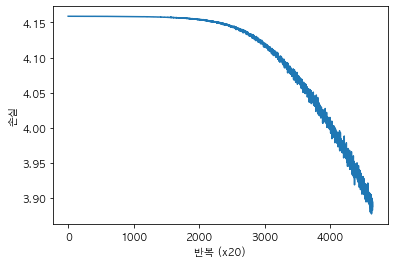

In [32]:
### 개선된 CBOW 모델 학습 코드
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = SGD()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 61 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 81 / 9295 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 101 / 9295 | 시간 3[s] | 손실 4.16
| 에폭 1 |  반복 121 / 9295 | 시간 3[s] | 손실 4.16
| 에폭 1 |  반복 141 / 9295 | 시간 4[s] | 손실 4.16
| 에폭 1 |  반복 161 / 9295 | 시간 4[s] | 손실 4.16
| 에폭 1 |  반복 181 / 9295 | 시간 5[s] | 손실 4.16
| 에폭 1 |  반복 201 / 9295 | 시간 5[s] | 손실 4.16
| 에폭 1 |  반복 221 / 9295 | 시간 6[s] | 손실 4.16
| 에폭 1 |  반복 241 / 9295 | 시간 7[s] | 손실 4.16
| 에폭 1 |  반복 261 / 9295 | 시간 7[s] | 손실 4.16
| 에폭 1 |  반복 281 / 9295 | 시간 8[s] | 손실 4.16
| 에폭 1 |  반복 301 / 9295 | 시간 8[s] | 손실 4.16
| 에폭 1 |  반복 321 / 9295 | 시간 9[s] | 손실 4.16
| 에폭 1 |  반복 341 / 9295 | 시간 9[s] | 손실 4.16
| 에폭 1 |  반복 361 / 9295 | 시간 10[s] | 손실 4.16
| 에폭 1 |  반복 381 / 9295 | 시간 11[s] | 손실 4.16
| 에폭 1 |  반복 401 / 9295 | 시간 11[s] | 손실 4.16
| 에폭 1 |  반복 421 / 9295 | 시간 12[s] | 손실 4.16
| 에폭 1 |  반복 441 / 9295 | 시간 12[s]

| 에폭 1 |  반복 3601 / 9295 | 시간 103[s] | 손실 4.16
| 에폭 1 |  반복 3621 / 9295 | 시간 104[s] | 손실 4.16
| 에폭 1 |  반복 3641 / 9295 | 시간 104[s] | 손실 4.16
| 에폭 1 |  반복 3661 / 9295 | 시간 105[s] | 손실 4.16
| 에폭 1 |  반복 3681 / 9295 | 시간 106[s] | 손실 4.16
| 에폭 1 |  반복 3701 / 9295 | 시간 106[s] | 손실 4.16
| 에폭 1 |  반복 3721 / 9295 | 시간 107[s] | 손실 4.16
| 에폭 1 |  반복 3741 / 9295 | 시간 107[s] | 손실 4.16
| 에폭 1 |  반복 3761 / 9295 | 시간 108[s] | 손실 4.16
| 에폭 1 |  반복 3781 / 9295 | 시간 108[s] | 손실 4.16
| 에폭 1 |  반복 3801 / 9295 | 시간 109[s] | 손실 4.16
| 에폭 1 |  반복 3821 / 9295 | 시간 110[s] | 손실 4.16
| 에폭 1 |  반복 3841 / 9295 | 시간 110[s] | 손실 4.16
| 에폭 1 |  반복 3861 / 9295 | 시간 111[s] | 손실 4.15
| 에폭 1 |  반복 3881 / 9295 | 시간 111[s] | 손실 4.16
| 에폭 1 |  반복 3901 / 9295 | 시간 112[s] | 손실 4.15
| 에폭 1 |  반복 3921 / 9295 | 시간 112[s] | 손실 4.16
| 에폭 1 |  반복 3941 / 9295 | 시간 113[s] | 손실 4.15
| 에폭 1 |  반복 3961 / 9295 | 시간 114[s] | 손실 4.15
| 에폭 1 |  반복 3981 / 9295 | 시간 114[s] | 손실 4.15
| 에폭 1 |  반복 4001 / 9295 | 시간 115[s] | 손실 4.15
| 에폭 1 |  반복 

| 에폭 1 |  반복 7101 / 9295 | 시간 205[s] | 손실 4.07
| 에폭 1 |  반복 7121 / 9295 | 시간 205[s] | 손실 4.07
| 에폭 1 |  반복 7141 / 9295 | 시간 206[s] | 손실 4.06
| 에폭 1 |  반복 7161 / 9295 | 시간 206[s] | 손실 4.06
| 에폭 1 |  반복 7181 / 9295 | 시간 207[s] | 손실 4.07
| 에폭 1 |  반복 7201 / 9295 | 시간 207[s] | 손실 4.06
| 에폭 1 |  반복 7221 / 9295 | 시간 208[s] | 손실 4.06
| 에폭 1 |  반복 7241 / 9295 | 시간 209[s] | 손실 4.06
| 에폭 1 |  반복 7261 / 9295 | 시간 209[s] | 손실 4.06
| 에폭 1 |  반복 7281 / 9295 | 시간 210[s] | 손실 4.06
| 에폭 1 |  반복 7301 / 9295 | 시간 210[s] | 손실 4.06
| 에폭 1 |  반복 7321 / 9295 | 시간 211[s] | 손실 4.04
| 에폭 1 |  반복 7341 / 9295 | 시간 211[s] | 손실 4.06
| 에폭 1 |  반복 7361 / 9295 | 시간 212[s] | 손실 4.05
| 에폭 1 |  반복 7381 / 9295 | 시간 213[s] | 손실 4.05
| 에폭 1 |  반복 7401 / 9295 | 시간 213[s] | 손실 4.05
| 에폭 1 |  반복 7421 / 9295 | 시간 214[s] | 손실 4.05
| 에폭 1 |  반복 7441 / 9295 | 시간 214[s] | 손실 4.04
| 에폭 1 |  반복 7461 / 9295 | 시간 215[s] | 손실 4.04
| 에폭 1 |  반복 7481 / 9295 | 시간 216[s] | 손실 4.04
| 에폭 1 |  반복 7501 / 9295 | 시간 216[s] | 손실 4.04
| 에폭 1 |  반복 

| 에폭 2 |  반복 1321 / 9295 | 시간 307[s] | 손실 3.74
| 에폭 2 |  반복 1341 / 9295 | 시간 307[s] | 손실 3.75
| 에폭 2 |  반복 1361 / 9295 | 시간 308[s] | 손실 3.74
| 에폭 2 |  반복 1381 / 9295 | 시간 308[s] | 손실 3.75
| 에폭 2 |  반복 1401 / 9295 | 시간 309[s] | 손실 3.74
| 에폭 2 |  반복 1421 / 9295 | 시간 309[s] | 손실 3.76
| 에폭 2 |  반복 1441 / 9295 | 시간 310[s] | 손실 3.74
| 에폭 2 |  반복 1461 / 9295 | 시간 311[s] | 손실 3.73
| 에폭 2 |  반복 1481 / 9295 | 시간 311[s] | 손실 3.76
| 에폭 2 |  반복 1501 / 9295 | 시간 312[s] | 손실 3.74
| 에폭 2 |  반복 1521 / 9295 | 시간 312[s] | 손실 3.74
| 에폭 2 |  반복 1541 / 9295 | 시간 313[s] | 손실 3.73
| 에폭 2 |  반복 1561 / 9295 | 시간 314[s] | 손실 3.74
| 에폭 2 |  반복 1581 / 9295 | 시간 314[s] | 손실 3.72
| 에폭 2 |  반복 1601 / 9295 | 시간 315[s] | 손실 3.73
| 에폭 2 |  반복 1621 / 9295 | 시간 315[s] | 손실 3.73
| 에폭 2 |  반복 1641 / 9295 | 시간 316[s] | 손실 3.74
| 에폭 2 |  반복 1661 / 9295 | 시간 316[s] | 손실 3.71
| 에폭 2 |  반복 1681 / 9295 | 시간 317[s] | 손실 3.73
| 에폭 2 |  반복 1701 / 9295 | 시간 318[s] | 손실 3.73
| 에폭 2 |  반복 1721 / 9295 | 시간 318[s] | 손실 3.72
| 에폭 2 |  반복 

| 에폭 2 |  반복 4821 / 9295 | 시간 408[s] | 손실 3.39
| 에폭 2 |  반복 4841 / 9295 | 시간 409[s] | 손실 3.39
| 에폭 2 |  반복 4861 / 9295 | 시간 409[s] | 손실 3.39
| 에폭 2 |  반복 4881 / 9295 | 시간 410[s] | 손실 3.37
| 에폭 2 |  반복 4901 / 9295 | 시간 410[s] | 손실 3.39
| 에폭 2 |  반복 4921 / 9295 | 시간 411[s] | 손실 3.37
| 에폭 2 |  반복 4941 / 9295 | 시간 412[s] | 손실 3.37
| 에폭 2 |  반복 4961 / 9295 | 시간 412[s] | 손실 3.38
| 에폭 2 |  반복 4981 / 9295 | 시간 413[s] | 손실 3.36
| 에폭 2 |  반복 5001 / 9295 | 시간 413[s] | 손실 3.35
| 에폭 2 |  반복 5021 / 9295 | 시간 414[s] | 손실 3.36
| 에폭 2 |  반복 5041 / 9295 | 시간 415[s] | 손실 3.37
| 에폭 2 |  반복 5061 / 9295 | 시간 415[s] | 손실 3.35
| 에폭 2 |  반복 5081 / 9295 | 시간 416[s] | 손실 3.37
| 에폭 2 |  반복 5101 / 9295 | 시간 416[s] | 손실 3.36
| 에폭 2 |  반복 5121 / 9295 | 시간 417[s] | 손실 3.37
| 에폭 2 |  반복 5141 / 9295 | 시간 417[s] | 손실 3.35
| 에폭 2 |  반복 5161 / 9295 | 시간 418[s] | 손실 3.35
| 에폭 2 |  반복 5181 / 9295 | 시간 419[s] | 손실 3.34
| 에폭 2 |  반복 5201 / 9295 | 시간 419[s] | 손실 3.37
| 에폭 2 |  반복 5221 / 9295 | 시간 420[s] | 손실 3.34
| 에폭 2 |  반복 

| 에폭 2 |  반복 8321 / 9295 | 시간 510[s] | 손실 3.10
| 에폭 2 |  반복 8341 / 9295 | 시간 510[s] | 손실 3.12
| 에폭 2 |  반복 8361 / 9295 | 시간 511[s] | 손실 3.11
| 에폭 2 |  반복 8381 / 9295 | 시간 512[s] | 손실 3.10
| 에폭 2 |  반복 8401 / 9295 | 시간 512[s] | 손실 3.11
| 에폭 2 |  반복 8421 / 9295 | 시간 513[s] | 손실 3.09
| 에폭 2 |  반복 8441 / 9295 | 시간 513[s] | 손실 3.10
| 에폭 2 |  반복 8461 / 9295 | 시간 514[s] | 손실 3.12
| 에폭 2 |  반복 8481 / 9295 | 시간 514[s] | 손실 3.11
| 에폭 2 |  반복 8501 / 9295 | 시간 515[s] | 손실 3.08
| 에폭 2 |  반복 8521 / 9295 | 시간 516[s] | 손실 3.11
| 에폭 2 |  반복 8541 / 9295 | 시간 516[s] | 손실 3.10
| 에폭 2 |  반복 8561 / 9295 | 시간 517[s] | 손실 3.11
| 에폭 2 |  반복 8581 / 9295 | 시간 517[s] | 손실 3.11
| 에폭 2 |  반복 8601 / 9295 | 시간 518[s] | 손실 3.10
| 에폭 2 |  반복 8621 / 9295 | 시간 519[s] | 손실 3.10
| 에폭 2 |  반복 8641 / 9295 | 시간 519[s] | 손실 3.09
| 에폭 2 |  반복 8661 / 9295 | 시간 520[s] | 손실 3.07
| 에폭 2 |  반복 8681 / 9295 | 시간 520[s] | 손실 3.08
| 에폭 2 |  반복 8701 / 9295 | 시간 521[s] | 손실 3.09
| 에폭 2 |  반복 8721 / 9295 | 시간 521[s] | 손실 3.08
| 에폭 2 |  반복 

| 에폭 3 |  반복 2541 / 9295 | 시간 611[s] | 손실 2.96
| 에폭 3 |  반복 2561 / 9295 | 시간 612[s] | 손실 2.95
| 에폭 3 |  반복 2581 / 9295 | 시간 612[s] | 손실 2.93
| 에폭 3 |  반복 2601 / 9295 | 시간 613[s] | 손실 2.95
| 에폭 3 |  반복 2621 / 9295 | 시간 614[s] | 손실 2.96
| 에폭 3 |  반복 2641 / 9295 | 시간 614[s] | 손실 2.92
| 에폭 3 |  반복 2661 / 9295 | 시간 615[s] | 손실 2.96
| 에폭 3 |  반복 2681 / 9295 | 시간 615[s] | 손실 2.93
| 에폭 3 |  반복 2701 / 9295 | 시간 616[s] | 손실 2.94
| 에폭 3 |  반복 2721 / 9295 | 시간 616[s] | 손실 2.93
| 에폭 3 |  반복 2741 / 9295 | 시간 617[s] | 손실 2.92
| 에폭 3 |  반복 2761 / 9295 | 시간 618[s] | 손실 2.93
| 에폭 3 |  반복 2781 / 9295 | 시간 618[s] | 손실 2.92
| 에폭 3 |  반복 2801 / 9295 | 시간 619[s] | 손실 2.92
| 에폭 3 |  반복 2821 / 9295 | 시간 619[s] | 손실 2.91
| 에폭 3 |  반복 2841 / 9295 | 시간 620[s] | 손실 2.95
| 에폭 3 |  반복 2861 / 9295 | 시간 620[s] | 손실 2.93
| 에폭 3 |  반복 2881 / 9295 | 시간 621[s] | 손실 2.93
| 에폭 3 |  반복 2901 / 9295 | 시간 622[s] | 손실 2.94
| 에폭 3 |  반복 2921 / 9295 | 시간 622[s] | 손실 2.92
| 에폭 3 |  반복 2941 / 9295 | 시간 623[s] | 손실 2.92
| 에폭 3 |  반복 

| 에폭 3 |  반복 6041 / 9295 | 시간 712[s] | 손실 2.80
| 에폭 3 |  반복 6061 / 9295 | 시간 713[s] | 손실 2.83
| 에폭 3 |  반복 6081 / 9295 | 시간 713[s] | 손실 2.84
| 에폭 3 |  반복 6101 / 9295 | 시간 714[s] | 손실 2.84
| 에폭 3 |  반복 6121 / 9295 | 시간 714[s] | 손실 2.82
| 에폭 3 |  반복 6141 / 9295 | 시간 715[s] | 손실 2.85
| 에폭 3 |  반복 6161 / 9295 | 시간 715[s] | 손실 2.83
| 에폭 3 |  반복 6181 / 9295 | 시간 716[s] | 손실 2.83
| 에폭 3 |  반복 6201 / 9295 | 시간 717[s] | 손실 2.84
| 에폭 3 |  반복 6221 / 9295 | 시간 717[s] | 손실 2.81
| 에폭 3 |  반복 6241 / 9295 | 시간 718[s] | 손실 2.84
| 에폭 3 |  반복 6261 / 9295 | 시간 718[s] | 손실 2.81
| 에폭 3 |  반복 6281 / 9295 | 시간 719[s] | 손실 2.82
| 에폭 3 |  반복 6301 / 9295 | 시간 719[s] | 손실 2.82
| 에폭 3 |  반복 6321 / 9295 | 시간 720[s] | 손실 2.81
| 에폭 3 |  반복 6341 / 9295 | 시간 721[s] | 손실 2.85
| 에폭 3 |  반복 6361 / 9295 | 시간 721[s] | 손실 2.82
| 에폭 3 |  반복 6381 / 9295 | 시간 722[s] | 손실 2.83
| 에폭 3 |  반복 6401 / 9295 | 시간 722[s] | 손실 2.83
| 에폭 3 |  반복 6421 / 9295 | 시간 723[s] | 손실 2.83
| 에폭 3 |  반복 6441 / 9295 | 시간 723[s] | 손실 2.82
| 에폭 3 |  반복 

| 에폭 4 |  반복 241 / 9295 | 시간 813[s] | 손실 2.77
| 에폭 4 |  반복 261 / 9295 | 시간 813[s] | 손실 2.73
| 에폭 4 |  반복 281 / 9295 | 시간 814[s] | 손실 2.75
| 에폭 4 |  반복 301 / 9295 | 시간 814[s] | 손실 2.74
| 에폭 4 |  반복 321 / 9295 | 시간 815[s] | 손실 2.77
| 에폭 4 |  반복 341 / 9295 | 시간 815[s] | 손실 2.77
| 에폭 4 |  반복 361 / 9295 | 시간 816[s] | 손실 2.76
| 에폭 4 |  반복 381 / 9295 | 시간 817[s] | 손실 2.74
| 에폭 4 |  반복 401 / 9295 | 시간 817[s] | 손실 2.72
| 에폭 4 |  반복 421 / 9295 | 시간 818[s] | 손실 2.76
| 에폭 4 |  반복 441 / 9295 | 시간 818[s] | 손실 2.76
| 에폭 4 |  반복 461 / 9295 | 시간 819[s] | 손실 2.78
| 에폭 4 |  반복 481 / 9295 | 시간 819[s] | 손실 2.73
| 에폭 4 |  반복 501 / 9295 | 시간 820[s] | 손실 2.75
| 에폭 4 |  반복 521 / 9295 | 시간 821[s] | 손실 2.78
| 에폭 4 |  반복 541 / 9295 | 시간 821[s] | 손실 2.77
| 에폭 4 |  반복 561 / 9295 | 시간 822[s] | 손실 2.78
| 에폭 4 |  반복 581 / 9295 | 시간 822[s] | 손실 2.74
| 에폭 4 |  반복 601 / 9295 | 시간 823[s] | 손실 2.76
| 에폭 4 |  반복 621 / 9295 | 시간 823[s] | 손실 2.76
| 에폭 4 |  반복 641 / 9295 | 시간 824[s] | 손실 2.75
| 에폭 4 |  반복 661 / 9295 | 시간 825[s

| 에폭 4 |  반복 3761 / 9295 | 시간 914[s] | 손실 2.71
| 에폭 4 |  반복 3781 / 9295 | 시간 914[s] | 손실 2.68
| 에폭 4 |  반복 3801 / 9295 | 시간 915[s] | 손실 2.70
| 에폭 4 |  반복 3821 / 9295 | 시간 915[s] | 손실 2.72
| 에폭 4 |  반복 3841 / 9295 | 시간 916[s] | 손실 2.73
| 에폭 4 |  반복 3861 / 9295 | 시간 917[s] | 손실 2.71
| 에폭 4 |  반복 3881 / 9295 | 시간 917[s] | 손실 2.69
| 에폭 4 |  반복 3901 / 9295 | 시간 918[s] | 손실 2.71
| 에폭 4 |  반복 3921 / 9295 | 시간 918[s] | 손실 2.72
| 에폭 4 |  반복 3941 / 9295 | 시간 919[s] | 손실 2.70
| 에폭 4 |  반복 3961 / 9295 | 시간 919[s] | 손실 2.73
| 에폭 4 |  반복 3981 / 9295 | 시간 920[s] | 손실 2.73
| 에폭 4 |  반복 4001 / 9295 | 시간 921[s] | 손실 2.70
| 에폭 4 |  반복 4021 / 9295 | 시간 921[s] | 손실 2.69
| 에폭 4 |  반복 4041 / 9295 | 시간 922[s] | 손실 2.71
| 에폭 4 |  반복 4061 / 9295 | 시간 922[s] | 손실 2.71
| 에폭 4 |  반복 4081 / 9295 | 시간 923[s] | 손실 2.70
| 에폭 4 |  반복 4101 / 9295 | 시간 923[s] | 손실 2.68
| 에폭 4 |  반복 4121 / 9295 | 시간 924[s] | 손실 2.71
| 에폭 4 |  반복 4141 / 9295 | 시간 925[s] | 손실 2.74
| 에폭 4 |  반복 4161 / 9295 | 시간 925[s] | 손실 2.70
| 에폭 4 |  반복 

| 에폭 4 |  반복 7241 / 9295 | 시간 1014[s] | 손실 2.68
| 에폭 4 |  반복 7261 / 9295 | 시간 1014[s] | 손실 2.68
| 에폭 4 |  반복 7281 / 9295 | 시간 1015[s] | 손실 2.69
| 에폭 4 |  반복 7301 / 9295 | 시간 1015[s] | 손실 2.65
| 에폭 4 |  반복 7321 / 9295 | 시간 1016[s] | 손실 2.69
| 에폭 4 |  반복 7341 / 9295 | 시간 1017[s] | 손실 2.67
| 에폭 4 |  반복 7361 / 9295 | 시간 1017[s] | 손실 2.69
| 에폭 4 |  반복 7381 / 9295 | 시간 1018[s] | 손실 2.63
| 에폭 4 |  반복 7401 / 9295 | 시간 1018[s] | 손실 2.69
| 에폭 4 |  반복 7421 / 9295 | 시간 1019[s] | 손실 2.66
| 에폭 4 |  반복 7441 / 9295 | 시간 1019[s] | 손실 2.69
| 에폭 4 |  반복 7461 / 9295 | 시간 1020[s] | 손실 2.67
| 에폭 4 |  반복 7481 / 9295 | 시간 1021[s] | 손실 2.67
| 에폭 4 |  반복 7501 / 9295 | 시간 1021[s] | 손실 2.67
| 에폭 4 |  반복 7521 / 9295 | 시간 1022[s] | 손실 2.69
| 에폭 4 |  반복 7541 / 9295 | 시간 1022[s] | 손실 2.66
| 에폭 4 |  반복 7561 / 9295 | 시간 1023[s] | 손실 2.65
| 에폭 4 |  반복 7581 / 9295 | 시간 1023[s] | 손실 2.66
| 에폭 4 |  반복 7601 / 9295 | 시간 1024[s] | 손실 2.70
| 에폭 4 |  반복 7621 / 9295 | 시간 1025[s] | 손실 2.65
| 에폭 4 |  반복 7641 / 9295 | 시간 1025[s] | 

| 에폭 5 |  반복 1381 / 9295 | 시간 1112[s] | 손실 2.67
| 에폭 5 |  반복 1401 / 9295 | 시간 1113[s] | 손실 2.65
| 에폭 5 |  반복 1421 / 9295 | 시간 1114[s] | 손실 2.64
| 에폭 5 |  반복 1441 / 9295 | 시간 1114[s] | 손실 2.64
| 에폭 5 |  반복 1461 / 9295 | 시간 1115[s] | 손실 2.65
| 에폭 5 |  반복 1481 / 9295 | 시간 1115[s] | 손실 2.62
| 에폭 5 |  반복 1501 / 9295 | 시간 1116[s] | 손실 2.66
| 에폭 5 |  반복 1521 / 9295 | 시간 1116[s] | 손실 2.63
| 에폭 5 |  반복 1541 / 9295 | 시간 1117[s] | 손실 2.64
| 에폭 5 |  반복 1561 / 9295 | 시간 1118[s] | 손실 2.64
| 에폭 5 |  반복 1581 / 9295 | 시간 1118[s] | 손실 2.64
| 에폭 5 |  반복 1601 / 9295 | 시간 1119[s] | 손실 2.66
| 에폭 5 |  반복 1621 / 9295 | 시간 1119[s] | 손실 2.64
| 에폭 5 |  반복 1641 / 9295 | 시간 1120[s] | 손실 2.64
| 에폭 5 |  반복 1661 / 9295 | 시간 1121[s] | 손실 2.66
| 에폭 5 |  반복 1681 / 9295 | 시간 1121[s] | 손실 2.64
| 에폭 5 |  반복 1701 / 9295 | 시간 1122[s] | 손실 2.64
| 에폭 5 |  반복 1721 / 9295 | 시간 1122[s] | 손실 2.63
| 에폭 5 |  반복 1741 / 9295 | 시간 1123[s] | 손실 2.66
| 에폭 5 |  반복 1761 / 9295 | 시간 1123[s] | 손실 2.66
| 에폭 5 |  반복 1781 / 9295 | 시간 1124[s] | 

| 에폭 5 |  반복 4801 / 9295 | 시간 1211[s] | 손실 2.63
| 에폭 5 |  반복 4821 / 9295 | 시간 1211[s] | 손실 2.64
| 에폭 5 |  반복 4841 / 9295 | 시간 1212[s] | 손실 2.60
| 에폭 5 |  반복 4861 / 9295 | 시간 1212[s] | 손실 2.63
| 에폭 5 |  반복 4881 / 9295 | 시간 1213[s] | 손실 2.62
| 에폭 5 |  반복 4901 / 9295 | 시간 1214[s] | 손실 2.61
| 에폭 5 |  반복 4921 / 9295 | 시간 1214[s] | 손실 2.61
| 에폭 5 |  반복 4941 / 9295 | 시간 1215[s] | 손실 2.64
| 에폭 5 |  반복 4961 / 9295 | 시간 1215[s] | 손실 2.64
| 에폭 5 |  반복 4981 / 9295 | 시간 1216[s] | 손실 2.61
| 에폭 5 |  반복 5001 / 9295 | 시간 1216[s] | 손실 2.63
| 에폭 5 |  반복 5021 / 9295 | 시간 1217[s] | 손실 2.62
| 에폭 5 |  반복 5041 / 9295 | 시간 1218[s] | 손실 2.63
| 에폭 5 |  반복 5061 / 9295 | 시간 1218[s] | 손실 2.62
| 에폭 5 |  반복 5081 / 9295 | 시간 1219[s] | 손실 2.63
| 에폭 5 |  반복 5101 / 9295 | 시간 1219[s] | 손실 2.61
| 에폭 5 |  반복 5121 / 9295 | 시간 1220[s] | 손실 2.61
| 에폭 5 |  반복 5141 / 9295 | 시간 1221[s] | 손실 2.63
| 에폭 5 |  반복 5161 / 9295 | 시간 1221[s] | 손실 2.61
| 에폭 5 |  반복 5181 / 9295 | 시간 1222[s] | 손실 2.60
| 에폭 5 |  반복 5201 / 9295 | 시간 1222[s] | 

| 에폭 5 |  반복 8221 / 9295 | 시간 1309[s] | 손실 2.60
| 에폭 5 |  반복 8241 / 9295 | 시간 1310[s] | 손실 2.62
| 에폭 5 |  반복 8261 / 9295 | 시간 1310[s] | 손실 2.64
| 에폭 5 |  반복 8281 / 9295 | 시간 1311[s] | 손실 2.59
| 에폭 5 |  반복 8301 / 9295 | 시간 1311[s] | 손실 2.61
| 에폭 5 |  반복 8321 / 9295 | 시간 1312[s] | 손실 2.61
| 에폭 5 |  반복 8341 / 9295 | 시간 1313[s] | 손실 2.64
| 에폭 5 |  반복 8361 / 9295 | 시간 1313[s] | 손실 2.61
| 에폭 5 |  반복 8381 / 9295 | 시간 1314[s] | 손실 2.59
| 에폭 5 |  반복 8401 / 9295 | 시간 1314[s] | 손실 2.59
| 에폭 5 |  반복 8421 / 9295 | 시간 1315[s] | 손실 2.61
| 에폭 5 |  반복 8441 / 9295 | 시간 1315[s] | 손실 2.60
| 에폭 5 |  반복 8461 / 9295 | 시간 1316[s] | 손실 2.63
| 에폭 5 |  반복 8481 / 9295 | 시간 1317[s] | 손실 2.60
| 에폭 5 |  반복 8501 / 9295 | 시간 1317[s] | 손실 2.61
| 에폭 5 |  반복 8521 / 9295 | 시간 1318[s] | 손실 2.61
| 에폭 5 |  반복 8541 / 9295 | 시간 1318[s] | 손실 2.61
| 에폭 5 |  반복 8561 / 9295 | 시간 1319[s] | 손실 2.60
| 에폭 5 |  반복 8581 / 9295 | 시간 1319[s] | 손실 2.58
| 에폭 5 |  반복 8601 / 9295 | 시간 1320[s] | 손실 2.63
| 에폭 5 |  반복 8621 / 9295 | 시간 1321[s] | 

| 에폭 6 |  반복 2361 / 9295 | 시간 1408[s] | 손실 2.61
| 에폭 6 |  반복 2381 / 9295 | 시간 1409[s] | 손실 2.61
| 에폭 6 |  반복 2401 / 9295 | 시간 1409[s] | 손실 2.59
| 에폭 6 |  반복 2421 / 9295 | 시간 1410[s] | 손실 2.61
| 에폭 6 |  반복 2441 / 9295 | 시간 1410[s] | 손실 2.59
| 에폭 6 |  반복 2461 / 9295 | 시간 1411[s] | 손실 2.60
| 에폭 6 |  반복 2481 / 9295 | 시간 1411[s] | 손실 2.60
| 에폭 6 |  반복 2501 / 9295 | 시간 1412[s] | 손실 2.59
| 에폭 6 |  반복 2521 / 9295 | 시간 1413[s] | 손실 2.60
| 에폭 6 |  반복 2541 / 9295 | 시간 1413[s] | 손실 2.61
| 에폭 6 |  반복 2561 / 9295 | 시간 1414[s] | 손실 2.59
| 에폭 6 |  반복 2581 / 9295 | 시간 1414[s] | 손실 2.60
| 에폭 6 |  반복 2601 / 9295 | 시간 1415[s] | 손실 2.61
| 에폭 6 |  반복 2621 / 9295 | 시간 1416[s] | 손실 2.56
| 에폭 6 |  반복 2641 / 9295 | 시간 1416[s] | 손실 2.57
| 에폭 6 |  반복 2661 / 9295 | 시간 1417[s] | 손실 2.56
| 에폭 6 |  반복 2681 / 9295 | 시간 1417[s] | 손실 2.57
| 에폭 6 |  반복 2701 / 9295 | 시간 1418[s] | 손실 2.61
| 에폭 6 |  반복 2721 / 9295 | 시간 1418[s] | 손실 2.59
| 에폭 6 |  반복 2741 / 9295 | 시간 1419[s] | 손실 2.60
| 에폭 6 |  반복 2761 / 9295 | 시간 1420[s] | 

| 에폭 6 |  반복 5781 / 9295 | 시간 1507[s] | 손실 2.58
| 에폭 6 |  반복 5801 / 9295 | 시간 1508[s] | 손실 2.61
| 에폭 6 |  반복 5821 / 9295 | 시간 1508[s] | 손실 2.58
| 에폭 6 |  반복 5841 / 9295 | 시간 1509[s] | 손실 2.58
| 에폭 6 |  반복 5861 / 9295 | 시간 1509[s] | 손실 2.59
| 에폭 6 |  반복 5881 / 9295 | 시간 1510[s] | 손실 2.59
| 에폭 6 |  반복 5901 / 9295 | 시간 1510[s] | 손실 2.57
| 에폭 6 |  반복 5921 / 9295 | 시간 1511[s] | 손실 2.57
| 에폭 6 |  반복 5941 / 9295 | 시간 1512[s] | 손실 2.56
| 에폭 6 |  반복 5961 / 9295 | 시간 1512[s] | 손실 2.56
| 에폭 6 |  반복 5981 / 9295 | 시간 1513[s] | 손실 2.55
| 에폭 6 |  반복 6001 / 9295 | 시간 1513[s] | 손실 2.59
| 에폭 6 |  반복 6021 / 9295 | 시간 1514[s] | 손실 2.54
| 에폭 6 |  반복 6041 / 9295 | 시간 1515[s] | 손실 2.57
| 에폭 6 |  반복 6061 / 9295 | 시간 1515[s] | 손실 2.58
| 에폭 6 |  반복 6081 / 9295 | 시간 1516[s] | 손실 2.58
| 에폭 6 |  반복 6101 / 9295 | 시간 1516[s] | 손실 2.59
| 에폭 6 |  반복 6121 / 9295 | 시간 1517[s] | 손실 2.59
| 에폭 6 |  반복 6141 / 9295 | 시간 1517[s] | 손실 2.56
| 에폭 6 |  반복 6161 / 9295 | 시간 1518[s] | 손실 2.55
| 에폭 6 |  반복 6181 / 9295 | 시간 1519[s] | 

| 에폭 6 |  반복 9201 / 9295 | 시간 1606[s] | 손실 2.58
| 에폭 6 |  반복 9221 / 9295 | 시간 1607[s] | 손실 2.61
| 에폭 6 |  반복 9241 / 9295 | 시간 1607[s] | 손실 2.57
| 에폭 6 |  반복 9261 / 9295 | 시간 1608[s] | 손실 2.55
| 에폭 6 |  반복 9281 / 9295 | 시간 1608[s] | 손실 2.59
| 에폭 7 |  반복 1 / 9295 | 시간 1609[s] | 손실 2.58
| 에폭 7 |  반복 21 / 9295 | 시간 1610[s] | 손실 2.54
| 에폭 7 |  반복 41 / 9295 | 시간 1610[s] | 손실 2.54
| 에폭 7 |  반복 61 / 9295 | 시간 1611[s] | 손실 2.57
| 에폭 7 |  반복 81 / 9295 | 시간 1611[s] | 손실 2.57
| 에폭 7 |  반복 101 / 9295 | 시간 1612[s] | 손실 2.56
| 에폭 7 |  반복 121 / 9295 | 시간 1612[s] | 손실 2.57
| 에폭 7 |  반복 141 / 9295 | 시간 1613[s] | 손실 2.58
| 에폭 7 |  반복 161 / 9295 | 시간 1614[s] | 손실 2.56
| 에폭 7 |  반복 181 / 9295 | 시간 1614[s] | 손실 2.56
| 에폭 7 |  반복 201 / 9295 | 시간 1615[s] | 손실 2.59
| 에폭 7 |  반복 221 / 9295 | 시간 1615[s] | 손실 2.57
| 에폭 7 |  반복 241 / 9295 | 시간 1616[s] | 손실 2.57
| 에폭 7 |  반복 261 / 9295 | 시간 1616[s] | 손실 2.55
| 에폭 7 |  반복 281 / 9295 | 시간 1617[s] | 손실 2.55
| 에폭 7 |  반복 301 / 9295 | 시간 1618[s] | 손실 2.54
| 에폭 7 |  반복 3

| 에폭 7 |  반복 3341 / 9295 | 시간 1706[s] | 손실 2.55
| 에폭 7 |  반복 3361 / 9295 | 시간 1706[s] | 손실 2.55
| 에폭 7 |  반복 3381 / 9295 | 시간 1707[s] | 손실 2.57
| 에폭 7 |  반복 3401 / 9295 | 시간 1708[s] | 손실 2.58
| 에폭 7 |  반복 3421 / 9295 | 시간 1708[s] | 손실 2.57
| 에폭 7 |  반복 3441 / 9295 | 시간 1709[s] | 손실 2.55
| 에폭 7 |  반복 3461 / 9295 | 시간 1709[s] | 손실 2.58
| 에폭 7 |  반복 3481 / 9295 | 시간 1710[s] | 손실 2.57
| 에폭 7 |  반복 3501 / 9295 | 시간 1710[s] | 손실 2.57
| 에폭 7 |  반복 3521 / 9295 | 시간 1711[s] | 손실 2.56
| 에폭 7 |  반복 3541 / 9295 | 시간 1712[s] | 손실 2.56
| 에폭 7 |  반복 3561 / 9295 | 시간 1712[s] | 손실 2.57
| 에폭 7 |  반복 3581 / 9295 | 시간 1713[s] | 손실 2.56
| 에폭 7 |  반복 3601 / 9295 | 시간 1713[s] | 손실 2.55
| 에폭 7 |  반복 3621 / 9295 | 시간 1714[s] | 손실 2.54
| 에폭 7 |  반복 3641 / 9295 | 시간 1715[s] | 손실 2.58
| 에폭 7 |  반복 3661 / 9295 | 시간 1715[s] | 손실 2.57
| 에폭 7 |  반복 3681 / 9295 | 시간 1716[s] | 손실 2.57
| 에폭 7 |  반복 3701 / 9295 | 시간 1716[s] | 손실 2.59
| 에폭 7 |  반복 3721 / 9295 | 시간 1717[s] | 손실 2.58
| 에폭 7 |  반복 3741 / 9295 | 시간 1717[s] | 

| 에폭 7 |  반복 6761 / 9295 | 시간 1805[s] | 손실 2.56
| 에폭 7 |  반복 6781 / 9295 | 시간 1806[s] | 손실 2.56
| 에폭 7 |  반복 6801 / 9295 | 시간 1806[s] | 손실 2.55
| 에폭 7 |  반복 6821 / 9295 | 시간 1807[s] | 손실 2.58
| 에폭 7 |  반복 6841 / 9295 | 시간 1807[s] | 손실 2.54
| 에폭 7 |  반복 6861 / 9295 | 시간 1808[s] | 손실 2.54
| 에폭 7 |  반복 6881 / 9295 | 시간 1809[s] | 손실 2.53
| 에폭 7 |  반복 6901 / 9295 | 시간 1809[s] | 손실 2.56
| 에폭 7 |  반복 6921 / 9295 | 시간 1810[s] | 손실 2.54
| 에폭 7 |  반복 6941 / 9295 | 시간 1810[s] | 손실 2.54
| 에폭 7 |  반복 6961 / 9295 | 시간 1811[s] | 손실 2.55
| 에폭 7 |  반복 6981 / 9295 | 시간 1811[s] | 손실 2.57
| 에폭 7 |  반복 7001 / 9295 | 시간 1812[s] | 손실 2.55
| 에폭 7 |  반복 7021 / 9295 | 시간 1813[s] | 손실 2.58
| 에폭 7 |  반복 7041 / 9295 | 시간 1813[s] | 손실 2.54
| 에폭 7 |  반복 7061 / 9295 | 시간 1814[s] | 손실 2.54
| 에폭 7 |  반복 7081 / 9295 | 시간 1814[s] | 손실 2.54
| 에폭 7 |  반복 7101 / 9295 | 시간 1815[s] | 손실 2.55
| 에폭 7 |  반복 7121 / 9295 | 시간 1816[s] | 손실 2.57
| 에폭 7 |  반복 7141 / 9295 | 시간 1816[s] | 손실 2.57
| 에폭 7 |  반복 7161 / 9295 | 시간 1817[s] | 

| 에폭 8 |  반복 901 / 9295 | 시간 1905[s] | 손실 2.54
| 에폭 8 |  반복 921 / 9295 | 시간 1906[s] | 손실 2.52
| 에폭 8 |  반복 941 / 9295 | 시간 1906[s] | 손실 2.54
| 에폭 8 |  반복 961 / 9295 | 시간 1907[s] | 손실 2.55
| 에폭 8 |  반복 981 / 9295 | 시간 1907[s] | 손실 2.56
| 에폭 8 |  반복 1001 / 9295 | 시간 1908[s] | 손실 2.55
| 에폭 8 |  반복 1021 / 9295 | 시간 1908[s] | 손실 2.52
| 에폭 8 |  반복 1041 / 9295 | 시간 1909[s] | 손실 2.53
| 에폭 8 |  반복 1061 / 9295 | 시간 1910[s] | 손실 2.56
| 에폭 8 |  반복 1081 / 9295 | 시간 1910[s] | 손실 2.56
| 에폭 8 |  반복 1101 / 9295 | 시간 1911[s] | 손실 2.56
| 에폭 8 |  반복 1121 / 9295 | 시간 1911[s] | 손실 2.54
| 에폭 8 |  반복 1141 / 9295 | 시간 1912[s] | 손실 2.55
| 에폭 8 |  반복 1161 / 9295 | 시간 1912[s] | 손실 2.56
| 에폭 8 |  반복 1181 / 9295 | 시간 1913[s] | 손실 2.55
| 에폭 8 |  반복 1201 / 9295 | 시간 1914[s] | 손실 2.56
| 에폭 8 |  반복 1221 / 9295 | 시간 1914[s] | 손실 2.51
| 에폭 8 |  반복 1241 / 9295 | 시간 1915[s] | 손실 2.56
| 에폭 8 |  반복 1261 / 9295 | 시간 1915[s] | 손실 2.57
| 에폭 8 |  반복 1281 / 9295 | 시간 1916[s] | 손실 2.55
| 에폭 8 |  반복 1301 / 9295 | 시간 1917[s] | 손실 2.

| 에폭 8 |  반복 4321 / 9295 | 시간 2004[s] | 손실 2.54
| 에폭 8 |  반복 4341 / 9295 | 시간 2005[s] | 손실 2.53
| 에폭 8 |  반복 4361 / 9295 | 시간 2005[s] | 손실 2.51
| 에폭 8 |  반복 4381 / 9295 | 시간 2006[s] | 손실 2.53
| 에폭 8 |  반복 4401 / 9295 | 시간 2007[s] | 손실 2.52
| 에폭 8 |  반복 4421 / 9295 | 시간 2007[s] | 손실 2.52
| 에폭 8 |  반복 4441 / 9295 | 시간 2008[s] | 손실 2.53
| 에폭 8 |  반복 4461 / 9295 | 시간 2008[s] | 손실 2.54
| 에폭 8 |  반복 4481 / 9295 | 시간 2009[s] | 손실 2.56
| 에폭 8 |  반복 4501 / 9295 | 시간 2009[s] | 손실 2.54
| 에폭 8 |  반복 4521 / 9295 | 시간 2010[s] | 손실 2.53
| 에폭 8 |  반복 4541 / 9295 | 시간 2011[s] | 손실 2.56
| 에폭 8 |  반복 4561 / 9295 | 시간 2011[s] | 손실 2.55
| 에폭 8 |  반복 4581 / 9295 | 시간 2012[s] | 손실 2.55
| 에폭 8 |  반복 4601 / 9295 | 시간 2012[s] | 손실 2.55
| 에폭 8 |  반복 4621 / 9295 | 시간 2013[s] | 손실 2.57
| 에폭 8 |  반복 4641 / 9295 | 시간 2014[s] | 손실 2.55
| 에폭 8 |  반복 4661 / 9295 | 시간 2014[s] | 손실 2.55
| 에폭 8 |  반복 4681 / 9295 | 시간 2015[s] | 손실 2.56
| 에폭 8 |  반복 4701 / 9295 | 시간 2015[s] | 손실 2.54
| 에폭 8 |  반복 4721 / 9295 | 시간 2016[s] | 

| 에폭 8 |  반복 7741 / 9295 | 시간 2104[s] | 손실 2.54
| 에폭 8 |  반복 7761 / 9295 | 시간 2104[s] | 손실 2.52
| 에폭 8 |  반복 7781 / 9295 | 시간 2105[s] | 손실 2.54
| 에폭 8 |  반복 7801 / 9295 | 시간 2105[s] | 손실 2.52
| 에폭 8 |  반복 7821 / 9295 | 시간 2106[s] | 손실 2.55
| 에폭 8 |  반복 7841 / 9295 | 시간 2106[s] | 손실 2.56
| 에폭 8 |  반복 7861 / 9295 | 시간 2107[s] | 손실 2.53
| 에폭 8 |  반복 7881 / 9295 | 시간 2108[s] | 손실 2.51
| 에폭 8 |  반복 7901 / 9295 | 시간 2108[s] | 손실 2.52
| 에폭 8 |  반복 7921 / 9295 | 시간 2109[s] | 손실 2.56
| 에폭 8 |  반복 7941 / 9295 | 시간 2109[s] | 손실 2.54
| 에폭 8 |  반복 7961 / 9295 | 시간 2110[s] | 손실 2.54
| 에폭 8 |  반복 7981 / 9295 | 시간 2111[s] | 손실 2.51
| 에폭 8 |  반복 8001 / 9295 | 시간 2111[s] | 손실 2.52
| 에폭 8 |  반복 8021 / 9295 | 시간 2112[s] | 손실 2.56
| 에폭 8 |  반복 8041 / 9295 | 시간 2112[s] | 손실 2.55
| 에폭 8 |  반복 8061 / 9295 | 시간 2113[s] | 손실 2.54
| 에폭 8 |  반복 8081 / 9295 | 시간 2113[s] | 손실 2.55
| 에폭 8 |  반복 8101 / 9295 | 시간 2114[s] | 손실 2.54
| 에폭 8 |  반복 8121 / 9295 | 시간 2115[s] | 손실 2.55
| 에폭 8 |  반복 8141 / 9295 | 시간 2115[s] | 

| 에폭 9 |  반복 1881 / 9295 | 시간 2204[s] | 손실 2.52
| 에폭 9 |  반복 1901 / 9295 | 시간 2204[s] | 손실 2.50
| 에폭 9 |  반복 1921 / 9295 | 시간 2205[s] | 손실 2.51
| 에폭 9 |  반복 1941 / 9295 | 시간 2205[s] | 손실 2.53
| 에폭 9 |  반복 1961 / 9295 | 시간 2206[s] | 손실 2.54
| 에폭 9 |  반복 1981 / 9295 | 시간 2206[s] | 손실 2.54
| 에폭 9 |  반복 2001 / 9295 | 시간 2207[s] | 손실 2.51
| 에폭 9 |  반복 2021 / 9295 | 시간 2208[s] | 손실 2.50
| 에폭 9 |  반복 2041 / 9295 | 시간 2208[s] | 손실 2.52
| 에폭 9 |  반복 2061 / 9295 | 시간 2209[s] | 손실 2.55
| 에폭 9 |  반복 2081 / 9295 | 시간 2209[s] | 손실 2.51
| 에폭 9 |  반복 2101 / 9295 | 시간 2210[s] | 손실 2.51
| 에폭 9 |  반복 2121 / 9295 | 시간 2211[s] | 손실 2.51
| 에폭 9 |  반복 2141 / 9295 | 시간 2211[s] | 손실 2.51
| 에폭 9 |  반복 2161 / 9295 | 시간 2212[s] | 손실 2.53
| 에폭 9 |  반복 2181 / 9295 | 시간 2212[s] | 손실 2.53
| 에폭 9 |  반복 2201 / 9295 | 시간 2213[s] | 손실 2.52
| 에폭 9 |  반복 2221 / 9295 | 시간 2213[s] | 손실 2.55
| 에폭 9 |  반복 2241 / 9295 | 시간 2214[s] | 손실 2.54
| 에폭 9 |  반복 2261 / 9295 | 시간 2215[s] | 손실 2.52
| 에폭 9 |  반복 2281 / 9295 | 시간 2215[s] | 

| 에폭 9 |  반복 5301 / 9295 | 시간 2303[s] | 손실 2.53
| 에폭 9 |  반복 5321 / 9295 | 시간 2303[s] | 손실 2.54
| 에폭 9 |  반복 5341 / 9295 | 시간 2304[s] | 손실 2.52
| 에폭 9 |  반복 5361 / 9295 | 시간 2304[s] | 손실 2.52
| 에폭 9 |  반복 5381 / 9295 | 시간 2305[s] | 손실 2.54
| 에폭 9 |  반복 5401 / 9295 | 시간 2305[s] | 손실 2.53
| 에폭 9 |  반복 5421 / 9295 | 시간 2306[s] | 손실 2.53
| 에폭 9 |  반복 5441 / 9295 | 시간 2307[s] | 손실 2.53
| 에폭 9 |  반복 5461 / 9295 | 시간 2307[s] | 손실 2.51
| 에폭 9 |  반복 5481 / 9295 | 시간 2308[s] | 손실 2.54
| 에폭 9 |  반복 5501 / 9295 | 시간 2308[s] | 손실 2.55
| 에폭 9 |  반복 5521 / 9295 | 시간 2309[s] | 손실 2.51
| 에폭 9 |  반복 5541 / 9295 | 시간 2309[s] | 손실 2.53
| 에폭 9 |  반복 5561 / 9295 | 시간 2310[s] | 손실 2.52
| 에폭 9 |  반복 5581 / 9295 | 시간 2311[s] | 손실 2.49
| 에폭 9 |  반복 5601 / 9295 | 시간 2311[s] | 손실 2.49
| 에폭 9 |  반복 5621 / 9295 | 시간 2312[s] | 손실 2.55
| 에폭 9 |  반복 5641 / 9295 | 시간 2312[s] | 손실 2.49
| 에폭 9 |  반복 5661 / 9295 | 시간 2313[s] | 손실 2.51
| 에폭 9 |  반복 5681 / 9295 | 시간 2314[s] | 손실 2.48
| 에폭 9 |  반복 5701 / 9295 | 시간 2314[s] | 

| 에폭 9 |  반복 8721 / 9295 | 시간 2401[s] | 손실 2.55
| 에폭 9 |  반복 8741 / 9295 | 시간 2402[s] | 손실 2.51
| 에폭 9 |  반복 8761 / 9295 | 시간 2402[s] | 손실 2.49
| 에폭 9 |  반복 8781 / 9295 | 시간 2403[s] | 손실 2.53
| 에폭 9 |  반복 8801 / 9295 | 시간 2403[s] | 손실 2.55
| 에폭 9 |  반복 8821 / 9295 | 시간 2404[s] | 손실 2.51
| 에폭 9 |  반복 8841 / 9295 | 시간 2404[s] | 손실 2.52
| 에폭 9 |  반복 8861 / 9295 | 시간 2405[s] | 손실 2.53
| 에폭 9 |  반복 8881 / 9295 | 시간 2406[s] | 손실 2.52
| 에폭 9 |  반복 8901 / 9295 | 시간 2406[s] | 손실 2.53
| 에폭 9 |  반복 8921 / 9295 | 시간 2407[s] | 손실 2.51
| 에폭 9 |  반복 8941 / 9295 | 시간 2407[s] | 손실 2.53
| 에폭 9 |  반복 8961 / 9295 | 시간 2408[s] | 손실 2.51
| 에폭 9 |  반복 8981 / 9295 | 시간 2408[s] | 손실 2.52
| 에폭 9 |  반복 9001 / 9295 | 시간 2409[s] | 손실 2.54
| 에폭 9 |  반복 9021 / 9295 | 시간 2410[s] | 손실 2.53
| 에폭 9 |  반복 9041 / 9295 | 시간 2410[s] | 손실 2.51
| 에폭 9 |  반복 9061 / 9295 | 시간 2411[s] | 손실 2.52
| 에폭 9 |  반복 9081 / 9295 | 시간 2411[s] | 손실 2.54
| 에폭 9 |  반복 9101 / 9295 | 시간 2412[s] | 손실 2.52
| 에폭 9 |  반복 9121 / 9295 | 시간 2412[s] | 

| 에폭 10 |  반복 2801 / 9295 | 시간 2498[s] | 손실 2.49
| 에폭 10 |  반복 2821 / 9295 | 시간 2499[s] | 손실 2.50
| 에폭 10 |  반복 2841 / 9295 | 시간 2499[s] | 손실 2.48
| 에폭 10 |  반복 2861 / 9295 | 시간 2500[s] | 손실 2.51
| 에폭 10 |  반복 2881 / 9295 | 시간 2500[s] | 손실 2.52
| 에폭 10 |  반복 2901 / 9295 | 시간 2501[s] | 손실 2.52
| 에폭 10 |  반복 2921 / 9295 | 시간 2502[s] | 손실 2.51
| 에폭 10 |  반복 2941 / 9295 | 시간 2502[s] | 손실 2.52
| 에폭 10 |  반복 2961 / 9295 | 시간 2503[s] | 손실 2.52
| 에폭 10 |  반복 2981 / 9295 | 시간 2503[s] | 손실 2.54
| 에폭 10 |  반복 3001 / 9295 | 시간 2504[s] | 손실 2.53
| 에폭 10 |  반복 3021 / 9295 | 시간 2504[s] | 손실 2.55
| 에폭 10 |  반복 3041 / 9295 | 시간 2505[s] | 손실 2.51
| 에폭 10 |  반복 3061 / 9295 | 시간 2506[s] | 손실 2.50
| 에폭 10 |  반복 3081 / 9295 | 시간 2506[s] | 손실 2.50
| 에폭 10 |  반복 3101 / 9295 | 시간 2507[s] | 손실 2.51
| 에폭 10 |  반복 3121 / 9295 | 시간 2508[s] | 손실 2.52
| 에폭 10 |  반복 3141 / 9295 | 시간 2508[s] | 손실 2.50
| 에폭 10 |  반복 3161 / 9295 | 시간 2509[s] | 손실 2.50
| 에폭 10 |  반복 3181 / 9295 | 시간 2509[s] | 손실 2.48
| 에폭 10 |  반복 3201 /

| 에폭 10 |  반복 6161 / 9295 | 시간 2595[s] | 손실 2.52
| 에폭 10 |  반복 6181 / 9295 | 시간 2596[s] | 손실 2.51
| 에폭 10 |  반복 6201 / 9295 | 시간 2596[s] | 손실 2.49
| 에폭 10 |  반복 6221 / 9295 | 시간 2597[s] | 손실 2.52
| 에폭 10 |  반복 6241 / 9295 | 시간 2597[s] | 손실 2.50
| 에폭 10 |  반복 6261 / 9295 | 시간 2598[s] | 손실 2.54
| 에폭 10 |  반복 6281 / 9295 | 시간 2598[s] | 손실 2.49
| 에폭 10 |  반복 6301 / 9295 | 시간 2599[s] | 손실 2.49
| 에폭 10 |  반복 6321 / 9295 | 시간 2600[s] | 손실 2.52
| 에폭 10 |  반복 6341 / 9295 | 시간 2600[s] | 손실 2.53
| 에폭 10 |  반복 6361 / 9295 | 시간 2601[s] | 손실 2.54
| 에폭 10 |  반복 6381 / 9295 | 시간 2601[s] | 손실 2.53
| 에폭 10 |  반복 6401 / 9295 | 시간 2602[s] | 손실 2.53
| 에폭 10 |  반복 6421 / 9295 | 시간 2602[s] | 손실 2.51
| 에폭 10 |  반복 6441 / 9295 | 시간 2603[s] | 손실 2.52
| 에폭 10 |  반복 6461 / 9295 | 시간 2604[s] | 손실 2.51
| 에폭 10 |  반복 6481 / 9295 | 시간 2604[s] | 손실 2.50
| 에폭 10 |  반복 6501 / 9295 | 시간 2605[s] | 손실 2.51
| 에폭 10 |  반복 6521 / 9295 | 시간 2605[s] | 손실 2.51
| 에폭 10 |  반복 6541 / 9295 | 시간 2606[s] | 손실 2.52
| 에폭 10 |  반복 6561 /

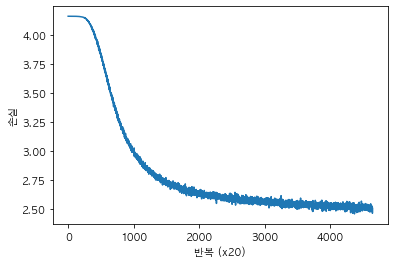

In [34]:
### 개선된 CBOW 모델 학습 코드
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Momentum()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.12
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 손실 3.94
| 에폭 1 |  반복 61 / 9295 | 시간 1[s] | 손실 3.75
| 에폭 1 |  반복 81 / 9295 | 시간 2[s] | 손실 3.58
| 에폭 1 |  반복 101 / 9295 | 시간 3[s] | 손실 3.47
| 에폭 1 |  반복 121 / 9295 | 시간 3[s] | 손실 3.37
| 에폭 1 |  반복 141 / 9295 | 시간 4[s] | 손실 3.29
| 에폭 1 |  반복 161 / 9295 | 시간 4[s] | 손실 3.21
| 에폭 1 |  반복 181 / 9295 | 시간 5[s] | 손실 3.16
| 에폭 1 |  반복 201 / 9295 | 시간 6[s] | 손실 3.12
| 에폭 1 |  반복 221 / 9295 | 시간 6[s] | 손실 3.05
| 에폭 1 |  반복 241 / 9295 | 시간 7[s] | 손실 3.02
| 에폭 1 |  반복 261 / 9295 | 시간 7[s] | 손실 3.01
| 에폭 1 |  반복 281 / 9295 | 시간 8[s] | 손실 2.95
| 에폭 1 |  반복 301 / 9295 | 시간 9[s] | 손실 2.95
| 에폭 1 |  반복 321 / 9295 | 시간 9[s] | 손실 2.90
| 에폭 1 |  반복 341 / 9295 | 시간 10[s] | 손실 2.89
| 에폭 1 |  반복 361 / 9295 | 시간 10[s] | 손실 2.88
| 에폭 1 |  반복 381 / 9295 | 시간 11[s] | 손실 2.84
| 에폭 1 |  반복 401 / 9295 | 시간 12[s] | 손실 2.84
| 에폭 1 |  반복 421 / 9295 | 시간 12[s] | 손실 2.83
| 에폭 1 |  반복 441 / 9295 | 시간 13[s

| 에폭 1 |  반복 3601 / 9295 | 시간 107[s] | 손실 2.54
| 에폭 1 |  반복 3621 / 9295 | 시간 108[s] | 손실 2.53
| 에폭 1 |  반복 3641 / 9295 | 시간 109[s] | 손실 2.53
| 에폭 1 |  반복 3661 / 9295 | 시간 109[s] | 손실 2.51
| 에폭 1 |  반복 3681 / 9295 | 시간 110[s] | 손실 2.51
| 에폭 1 |  반복 3701 / 9295 | 시간 110[s] | 손실 2.51
| 에폭 1 |  반복 3721 / 9295 | 시간 111[s] | 손실 2.52
| 에폭 1 |  반복 3741 / 9295 | 시간 112[s] | 손실 2.53
| 에폭 1 |  반복 3761 / 9295 | 시간 112[s] | 손실 2.50
| 에폭 1 |  반복 3781 / 9295 | 시간 113[s] | 손실 2.52
| 에폭 1 |  반복 3801 / 9295 | 시간 113[s] | 손실 2.52
| 에폭 1 |  반복 3821 / 9295 | 시간 114[s] | 손실 2.51
| 에폭 1 |  반복 3841 / 9295 | 시간 115[s] | 손실 2.52
| 에폭 1 |  반복 3861 / 9295 | 시간 115[s] | 손실 2.50
| 에폭 1 |  반복 3881 / 9295 | 시간 116[s] | 손실 2.53
| 에폭 1 |  반복 3901 / 9295 | 시간 116[s] | 손실 2.51
| 에폭 1 |  반복 3921 / 9295 | 시간 117[s] | 손실 2.53
| 에폭 1 |  반복 3941 / 9295 | 시간 118[s] | 손실 2.52
| 에폭 1 |  반복 3961 / 9295 | 시간 118[s] | 손실 2.50
| 에폭 1 |  반복 3981 / 9295 | 시간 119[s] | 손실 2.51
| 에폭 1 |  반복 4001 / 9295 | 시간 119[s] | 손실 2.48
| 에폭 1 |  반복 

| 에폭 1 |  반복 7101 / 9295 | 시간 211[s] | 손실 2.48
| 에폭 1 |  반복 7121 / 9295 | 시간 212[s] | 손실 2.47
| 에폭 1 |  반복 7141 / 9295 | 시간 212[s] | 손실 2.48
| 에폭 1 |  반복 7161 / 9295 | 시간 213[s] | 손실 2.48
| 에폭 1 |  반복 7181 / 9295 | 시간 214[s] | 손실 2.48
| 에폭 1 |  반복 7201 / 9295 | 시간 214[s] | 손실 2.48
| 에폭 1 |  반복 7221 / 9295 | 시간 215[s] | 손실 2.46
| 에폭 1 |  반복 7241 / 9295 | 시간 215[s] | 손실 2.47
| 에폭 1 |  반복 7261 / 9295 | 시간 216[s] | 손실 2.47
| 에폭 1 |  반복 7281 / 9295 | 시간 217[s] | 손실 2.48
| 에폭 1 |  반복 7301 / 9295 | 시간 217[s] | 손실 2.46
| 에폭 1 |  반복 7321 / 9295 | 시간 218[s] | 손실 2.46
| 에폭 1 |  반복 7341 / 9295 | 시간 218[s] | 손실 2.49
| 에폭 1 |  반복 7361 / 9295 | 시간 219[s] | 손실 2.45
| 에폭 1 |  반복 7381 / 9295 | 시간 220[s] | 손실 2.48
| 에폭 1 |  반복 7401 / 9295 | 시간 220[s] | 손실 2.47
| 에폭 1 |  반복 7421 / 9295 | 시간 221[s] | 손실 2.45
| 에폭 1 |  반복 7441 / 9295 | 시간 221[s] | 손실 2.50
| 에폭 1 |  반복 7461 / 9295 | 시간 222[s] | 손실 2.50
| 에폭 1 |  반복 7481 / 9295 | 시간 223[s] | 손실 2.49
| 에폭 1 |  반복 7501 / 9295 | 시간 223[s] | 손실 2.47
| 에폭 1 |  반복 

| 에폭 2 |  반복 1321 / 9295 | 시간 316[s] | 손실 2.44
| 에폭 2 |  반복 1341 / 9295 | 시간 316[s] | 손실 2.48
| 에폭 2 |  반복 1361 / 9295 | 시간 317[s] | 손실 2.45
| 에폭 2 |  반복 1381 / 9295 | 시간 317[s] | 손실 2.42
| 에폭 2 |  반복 1401 / 9295 | 시간 318[s] | 손실 2.45
| 에폭 2 |  반복 1421 / 9295 | 시간 319[s] | 손실 2.46
| 에폭 2 |  반복 1441 / 9295 | 시간 319[s] | 손실 2.47
| 에폭 2 |  반복 1461 / 9295 | 시간 320[s] | 손실 2.46
| 에폭 2 |  반복 1481 / 9295 | 시간 320[s] | 손실 2.47
| 에폭 2 |  반복 1501 / 9295 | 시간 321[s] | 손실 2.44
| 에폭 2 |  반복 1521 / 9295 | 시간 321[s] | 손실 2.45
| 에폭 2 |  반복 1541 / 9295 | 시간 322[s] | 손실 2.47
| 에폭 2 |  반복 1561 / 9295 | 시간 323[s] | 손실 2.45
| 에폭 2 |  반복 1581 / 9295 | 시간 323[s] | 손실 2.48
| 에폭 2 |  반복 1601 / 9295 | 시간 324[s] | 손실 2.44
| 에폭 2 |  반복 1621 / 9295 | 시간 324[s] | 손실 2.47
| 에폭 2 |  반복 1641 / 9295 | 시간 325[s] | 손실 2.46
| 에폭 2 |  반복 1661 / 9295 | 시간 326[s] | 손실 2.46
| 에폭 2 |  반복 1681 / 9295 | 시간 326[s] | 손실 2.48
| 에폭 2 |  반복 1701 / 9295 | 시간 327[s] | 손실 2.46
| 에폭 2 |  반복 1721 / 9295 | 시간 327[s] | 손실 2.45
| 에폭 2 |  반복 

| 에폭 2 |  반복 4821 / 9295 | 시간 418[s] | 손실 2.44
| 에폭 2 |  반복 4841 / 9295 | 시간 419[s] | 손실 2.47
| 에폭 2 |  반복 4861 / 9295 | 시간 420[s] | 손실 2.45
| 에폭 2 |  반복 4881 / 9295 | 시간 420[s] | 손실 2.45
| 에폭 2 |  반복 4901 / 9295 | 시간 421[s] | 손실 2.42
| 에폭 2 |  반복 4921 / 9295 | 시간 421[s] | 손실 2.46
| 에폭 2 |  반복 4941 / 9295 | 시간 422[s] | 손실 2.44
| 에폭 2 |  반복 4961 / 9295 | 시간 423[s] | 손실 2.45
| 에폭 2 |  반복 4981 / 9295 | 시간 423[s] | 손실 2.44
| 에폭 2 |  반복 5001 / 9295 | 시간 424[s] | 손실 2.45
| 에폭 2 |  반복 5021 / 9295 | 시간 424[s] | 손실 2.44
| 에폭 2 |  반복 5041 / 9295 | 시간 425[s] | 손실 2.46
| 에폭 2 |  반복 5061 / 9295 | 시간 425[s] | 손실 2.42
| 에폭 2 |  반복 5081 / 9295 | 시간 426[s] | 손실 2.45
| 에폭 2 |  반복 5101 / 9295 | 시간 427[s] | 손실 2.46
| 에폭 2 |  반복 5121 / 9295 | 시간 427[s] | 손실 2.47
| 에폭 2 |  반복 5141 / 9295 | 시간 428[s] | 손실 2.45
| 에폭 2 |  반복 5161 / 9295 | 시간 428[s] | 손실 2.43
| 에폭 2 |  반복 5181 / 9295 | 시간 429[s] | 손실 2.45
| 에폭 2 |  반복 5201 / 9295 | 시간 430[s] | 손실 2.44
| 에폭 2 |  반복 5221 / 9295 | 시간 430[s] | 손실 2.46
| 에폭 2 |  반복 

| 에폭 2 |  반복 8321 / 9295 | 시간 521[s] | 손실 2.46
| 에폭 2 |  반복 8341 / 9295 | 시간 522[s] | 손실 2.44
| 에폭 2 |  반복 8361 / 9295 | 시간 522[s] | 손실 2.41
| 에폭 2 |  반복 8381 / 9295 | 시간 523[s] | 손실 2.44
| 에폭 2 |  반복 8401 / 9295 | 시간 523[s] | 손실 2.42
| 에폭 2 |  반복 8421 / 9295 | 시간 524[s] | 손실 2.44
| 에폭 2 |  반복 8441 / 9295 | 시간 525[s] | 손실 2.43
| 에폭 2 |  반복 8461 / 9295 | 시간 525[s] | 손실 2.41
| 에폭 2 |  반복 8481 / 9295 | 시간 526[s] | 손실 2.43
| 에폭 2 |  반복 8501 / 9295 | 시간 526[s] | 손실 2.43
| 에폭 2 |  반복 8521 / 9295 | 시간 527[s] | 손실 2.45
| 에폭 2 |  반복 8541 / 9295 | 시간 528[s] | 손실 2.46
| 에폭 2 |  반복 8561 / 9295 | 시간 528[s] | 손실 2.46
| 에폭 2 |  반복 8581 / 9295 | 시간 529[s] | 손실 2.43
| 에폭 2 |  반복 8601 / 9295 | 시간 529[s] | 손실 2.43
| 에폭 2 |  반복 8621 / 9295 | 시간 530[s] | 손실 2.44
| 에폭 2 |  반복 8641 / 9295 | 시간 531[s] | 손실 2.42
| 에폭 2 |  반복 8661 / 9295 | 시간 531[s] | 손실 2.43
| 에폭 2 |  반복 8681 / 9295 | 시간 532[s] | 손실 2.42
| 에폭 2 |  반복 8701 / 9295 | 시간 532[s] | 손실 2.43
| 에폭 2 |  반복 8721 / 9295 | 시간 533[s] | 손실 2.41
| 에폭 2 |  반복 

| 에폭 3 |  반복 2541 / 9295 | 시간 624[s] | 손실 2.45
| 에폭 3 |  반복 2561 / 9295 | 시간 625[s] | 손실 2.41
| 에폭 3 |  반복 2581 / 9295 | 시간 626[s] | 손실 2.42
| 에폭 3 |  반복 2601 / 9295 | 시간 626[s] | 손실 2.43
| 에폭 3 |  반복 2621 / 9295 | 시간 627[s] | 손실 2.40
| 에폭 3 |  반복 2641 / 9295 | 시간 627[s] | 손실 2.40
| 에폭 3 |  반복 2661 / 9295 | 시간 628[s] | 손실 2.39
| 에폭 3 |  반복 2681 / 9295 | 시간 629[s] | 손실 2.42
| 에폭 3 |  반복 2701 / 9295 | 시간 629[s] | 손실 2.42
| 에폭 3 |  반복 2721 / 9295 | 시간 630[s] | 손실 2.43
| 에폭 3 |  반복 2741 / 9295 | 시간 630[s] | 손실 2.43
| 에폭 3 |  반복 2761 / 9295 | 시간 631[s] | 손실 2.39
| 에폭 3 |  반복 2781 / 9295 | 시간 632[s] | 손실 2.44
| 에폭 3 |  반복 2801 / 9295 | 시간 632[s] | 손실 2.43
| 에폭 3 |  반복 2821 / 9295 | 시간 633[s] | 손실 2.43
| 에폭 3 |  반복 2841 / 9295 | 시간 633[s] | 손실 2.42
| 에폭 3 |  반복 2861 / 9295 | 시간 634[s] | 손실 2.41
| 에폭 3 |  반복 2881 / 9295 | 시간 634[s] | 손실 2.41
| 에폭 3 |  반복 2901 / 9295 | 시간 635[s] | 손실 2.43
| 에폭 3 |  반복 2921 / 9295 | 시간 636[s] | 손실 2.39
| 에폭 3 |  반복 2941 / 9295 | 시간 636[s] | 손실 2.43
| 에폭 3 |  반복 

| 에폭 3 |  반복 6041 / 9295 | 시간 727[s] | 손실 2.41
| 에폭 3 |  반복 6061 / 9295 | 시간 728[s] | 손실 2.41
| 에폭 3 |  반복 6081 / 9295 | 시간 728[s] | 손실 2.39
| 에폭 3 |  반복 6101 / 9295 | 시간 729[s] | 손실 2.39
| 에폭 3 |  반복 6121 / 9295 | 시간 730[s] | 손실 2.42
| 에폭 3 |  반복 6141 / 9295 | 시간 730[s] | 손실 2.41
| 에폭 3 |  반복 6161 / 9295 | 시간 731[s] | 손실 2.37
| 에폭 3 |  반복 6181 / 9295 | 시간 731[s] | 손실 2.42
| 에폭 3 |  반복 6201 / 9295 | 시간 732[s] | 손실 2.41
| 에폭 3 |  반복 6221 / 9295 | 시간 732[s] | 손실 2.38
| 에폭 3 |  반복 6241 / 9295 | 시간 733[s] | 손실 2.43
| 에폭 3 |  반복 6261 / 9295 | 시간 734[s] | 손실 2.40
| 에폭 3 |  반복 6281 / 9295 | 시간 734[s] | 손실 2.39
| 에폭 3 |  반복 6301 / 9295 | 시간 735[s] | 손실 2.39
| 에폭 3 |  반복 6321 / 9295 | 시간 735[s] | 손실 2.43
| 에폭 3 |  반복 6341 / 9295 | 시간 736[s] | 손실 2.41
| 에폭 3 |  반복 6361 / 9295 | 시간 737[s] | 손실 2.40
| 에폭 3 |  반복 6381 / 9295 | 시간 737[s] | 손실 2.43
| 에폭 3 |  반복 6401 / 9295 | 시간 738[s] | 손실 2.43
| 에폭 3 |  반복 6421 / 9295 | 시간 738[s] | 손실 2.41
| 에폭 3 |  반복 6441 / 9295 | 시간 739[s] | 손실 2.41
| 에폭 3 |  반복 

| 에폭 4 |  반복 241 / 9295 | 시간 830[s] | 손실 2.40
| 에폭 4 |  반복 261 / 9295 | 시간 831[s] | 손실 2.38
| 에폭 4 |  반복 281 / 9295 | 시간 831[s] | 손실 2.41
| 에폭 4 |  반복 301 / 9295 | 시간 832[s] | 손실 2.38
| 에폭 4 |  반복 321 / 9295 | 시간 832[s] | 손실 2.37
| 에폭 4 |  반복 341 / 9295 | 시간 833[s] | 손실 2.41
| 에폭 4 |  반복 361 / 9295 | 시간 833[s] | 손실 2.39
| 에폭 4 |  반복 381 / 9295 | 시간 834[s] | 손실 2.41
| 에폭 4 |  반복 401 / 9295 | 시간 835[s] | 손실 2.37
| 에폭 4 |  반복 421 / 9295 | 시간 835[s] | 손실 2.38
| 에폭 4 |  반복 441 / 9295 | 시간 836[s] | 손실 2.39
| 에폭 4 |  반복 461 / 9295 | 시간 836[s] | 손실 2.39
| 에폭 4 |  반복 481 / 9295 | 시간 837[s] | 손실 2.38
| 에폭 4 |  반복 501 / 9295 | 시간 838[s] | 손실 2.39
| 에폭 4 |  반복 521 / 9295 | 시간 838[s] | 손실 2.40
| 에폭 4 |  반복 541 / 9295 | 시간 839[s] | 손실 2.37
| 에폭 4 |  반복 561 / 9295 | 시간 839[s] | 손실 2.38
| 에폭 4 |  반복 581 / 9295 | 시간 840[s] | 손실 2.38
| 에폭 4 |  반복 601 / 9295 | 시간 840[s] | 손실 2.39
| 에폭 4 |  반복 621 / 9295 | 시간 841[s] | 손실 2.38
| 에폭 4 |  반복 641 / 9295 | 시간 842[s] | 손실 2.35
| 에폭 4 |  반복 661 / 9295 | 시간 842[s

| 에폭 4 |  반복 3761 / 9295 | 시간 933[s] | 손실 2.37
| 에폭 4 |  반복 3781 / 9295 | 시간 934[s] | 손실 2.39
| 에폭 4 |  반복 3801 / 9295 | 시간 934[s] | 손실 2.38
| 에폭 4 |  반복 3821 / 9295 | 시간 935[s] | 손실 2.39
| 에폭 4 |  반복 3841 / 9295 | 시간 936[s] | 손실 2.39
| 에폭 4 |  반복 3861 / 9295 | 시간 936[s] | 손실 2.37
| 에폭 4 |  반복 3881 / 9295 | 시간 937[s] | 손실 2.39
| 에폭 4 |  반복 3901 / 9295 | 시간 937[s] | 손실 2.37
| 에폭 4 |  반복 3921 / 9295 | 시간 938[s] | 손실 2.39
| 에폭 4 |  반복 3941 / 9295 | 시간 938[s] | 손실 2.37
| 에폭 4 |  반복 3961 / 9295 | 시간 939[s] | 손실 2.39
| 에폭 4 |  반복 3981 / 9295 | 시간 940[s] | 손실 2.39
| 에폭 4 |  반복 4001 / 9295 | 시간 940[s] | 손실 2.36
| 에폭 4 |  반복 4021 / 9295 | 시간 941[s] | 손실 2.37
| 에폭 4 |  반복 4041 / 9295 | 시간 941[s] | 손실 2.39
| 에폭 4 |  반복 4061 / 9295 | 시간 942[s] | 손실 2.38
| 에폭 4 |  반복 4081 / 9295 | 시간 943[s] | 손실 2.37
| 에폭 4 |  반복 4101 / 9295 | 시간 943[s] | 손실 2.40
| 에폭 4 |  반복 4121 / 9295 | 시간 944[s] | 손실 2.38
| 에폭 4 |  반복 4141 / 9295 | 시간 944[s] | 손실 2.37
| 에폭 4 |  반복 4161 / 9295 | 시간 945[s] | 손실 2.38
| 에폭 4 |  반복 

| 에폭 4 |  반복 7241 / 9295 | 시간 1035[s] | 손실 2.37
| 에폭 4 |  반복 7261 / 9295 | 시간 1036[s] | 손실 2.38
| 에폭 4 |  반복 7281 / 9295 | 시간 1036[s] | 손실 2.38
| 에폭 4 |  반복 7301 / 9295 | 시간 1037[s] | 손실 2.37
| 에폭 4 |  반복 7321 / 9295 | 시간 1038[s] | 손실 2.37
| 에폭 4 |  반복 7341 / 9295 | 시간 1038[s] | 손실 2.39
| 에폭 4 |  반복 7361 / 9295 | 시간 1039[s] | 손실 2.37
| 에폭 4 |  반복 7381 / 9295 | 시간 1039[s] | 손실 2.38
| 에폭 4 |  반복 7401 / 9295 | 시간 1040[s] | 손실 2.36
| 에폭 4 |  반복 7421 / 9295 | 시간 1041[s] | 손실 2.35
| 에폭 4 |  반복 7441 / 9295 | 시간 1041[s] | 손실 2.37
| 에폭 4 |  반복 7461 / 9295 | 시간 1042[s] | 손실 2.38
| 에폭 4 |  반복 7481 / 9295 | 시간 1042[s] | 손실 2.39
| 에폭 4 |  반복 7501 / 9295 | 시간 1043[s] | 손실 2.39
| 에폭 4 |  반복 7521 / 9295 | 시간 1043[s] | 손실 2.38
| 에폭 4 |  반복 7541 / 9295 | 시간 1044[s] | 손실 2.37
| 에폭 4 |  반복 7561 / 9295 | 시간 1045[s] | 손실 2.38
| 에폭 4 |  반복 7581 / 9295 | 시간 1045[s] | 손실 2.34
| 에폭 4 |  반복 7601 / 9295 | 시간 1046[s] | 손실 2.34
| 에폭 4 |  반복 7621 / 9295 | 시간 1046[s] | 손실 2.40
| 에폭 4 |  반복 7641 / 9295 | 시간 1047[s] | 

| 에폭 5 |  반복 1381 / 9295 | 시간 1136[s] | 손실 2.34
| 에폭 5 |  반복 1401 / 9295 | 시간 1137[s] | 손실 2.37
| 에폭 5 |  반복 1421 / 9295 | 시간 1138[s] | 손실 2.36
| 에폭 5 |  반복 1441 / 9295 | 시간 1138[s] | 손실 2.38
| 에폭 5 |  반복 1461 / 9295 | 시간 1139[s] | 손실 2.35
| 에폭 5 |  반복 1481 / 9295 | 시간 1139[s] | 손실 2.34
| 에폭 5 |  반복 1501 / 9295 | 시간 1140[s] | 손실 2.36
| 에폭 5 |  반복 1521 / 9295 | 시간 1141[s] | 손실 2.38
| 에폭 5 |  반복 1541 / 9295 | 시간 1141[s] | 손실 2.38
| 에폭 5 |  반복 1561 / 9295 | 시간 1142[s] | 손실 2.38
| 에폭 5 |  반복 1581 / 9295 | 시간 1142[s] | 손실 2.34
| 에폭 5 |  반복 1601 / 9295 | 시간 1143[s] | 손실 2.37
| 에폭 5 |  반복 1621 / 9295 | 시간 1144[s] | 손실 2.36
| 에폭 5 |  반복 1641 / 9295 | 시간 1144[s] | 손실 2.37
| 에폭 5 |  반복 1661 / 9295 | 시간 1145[s] | 손실 2.37
| 에폭 5 |  반복 1681 / 9295 | 시간 1145[s] | 손실 2.34
| 에폭 5 |  반복 1701 / 9295 | 시간 1146[s] | 손실 2.39
| 에폭 5 |  반복 1721 / 9295 | 시간 1147[s] | 손실 2.36
| 에폭 5 |  반복 1741 / 9295 | 시간 1147[s] | 손실 2.34
| 에폭 5 |  반복 1761 / 9295 | 시간 1148[s] | 손실 2.37
| 에폭 5 |  반복 1781 / 9295 | 시간 1148[s] | 

| 에폭 5 |  반복 4801 / 9295 | 시간 1238[s] | 손실 2.36
| 에폭 5 |  반복 4821 / 9295 | 시간 1238[s] | 손실 2.37
| 에폭 5 |  반복 4841 / 9295 | 시간 1239[s] | 손실 2.36
| 에폭 5 |  반복 4861 / 9295 | 시간 1239[s] | 손실 2.35
| 에폭 5 |  반복 4881 / 9295 | 시간 1240[s] | 손실 2.33
| 에폭 5 |  반복 4901 / 9295 | 시간 1241[s] | 손실 2.36
| 에폭 5 |  반복 4921 / 9295 | 시간 1241[s] | 손실 2.36
| 에폭 5 |  반복 4941 / 9295 | 시간 1242[s] | 손실 2.37
| 에폭 5 |  반복 4961 / 9295 | 시간 1242[s] | 손실 2.37
| 에폭 5 |  반복 4981 / 9295 | 시간 1243[s] | 손실 2.35
| 에폭 5 |  반복 5001 / 9295 | 시간 1244[s] | 손실 2.36
| 에폭 5 |  반복 5021 / 9295 | 시간 1244[s] | 손실 2.35
| 에폭 5 |  반복 5041 / 9295 | 시간 1245[s] | 손실 2.36
| 에폭 5 |  반복 5061 / 9295 | 시간 1245[s] | 손실 2.36
| 에폭 5 |  반복 5081 / 9295 | 시간 1246[s] | 손실 2.38
| 에폭 5 |  반복 5101 / 9295 | 시간 1247[s] | 손실 2.37
| 에폭 5 |  반복 5121 / 9295 | 시간 1247[s] | 손실 2.36
| 에폭 5 |  반복 5141 / 9295 | 시간 1248[s] | 손실 2.33
| 에폭 5 |  반복 5161 / 9295 | 시간 1248[s] | 손실 2.36
| 에폭 5 |  반복 5181 / 9295 | 시간 1249[s] | 손실 2.38
| 에폭 5 |  반복 5201 / 9295 | 시간 1250[s] | 

| 에폭 5 |  반복 8221 / 9295 | 시간 1339[s] | 손실 2.35
| 에폭 5 |  반복 8241 / 9295 | 시간 1340[s] | 손실 2.37
| 에폭 5 |  반복 8261 / 9295 | 시간 1340[s] | 손실 2.33
| 에폭 5 |  반복 8281 / 9295 | 시간 1341[s] | 손실 2.39
| 에폭 5 |  반복 8301 / 9295 | 시간 1342[s] | 손실 2.38
| 에폭 5 |  반복 8321 / 9295 | 시간 1342[s] | 손실 2.35
| 에폭 5 |  반복 8341 / 9295 | 시간 1343[s] | 손실 2.36
| 에폭 5 |  반복 8361 / 9295 | 시간 1343[s] | 손실 2.32
| 에폭 5 |  반복 8381 / 9295 | 시간 1344[s] | 손실 2.33
| 에폭 5 |  반복 8401 / 9295 | 시간 1345[s] | 손실 2.36
| 에폭 5 |  반복 8421 / 9295 | 시간 1345[s] | 손실 2.32
| 에폭 5 |  반복 8441 / 9295 | 시간 1346[s] | 손실 2.34
| 에폭 5 |  반복 8461 / 9295 | 시간 1346[s] | 손실 2.35
| 에폭 5 |  반복 8481 / 9295 | 시간 1347[s] | 손실 2.32
| 에폭 5 |  반복 8501 / 9295 | 시간 1347[s] | 손실 2.35
| 에폭 5 |  반복 8521 / 9295 | 시간 1348[s] | 손실 2.34
| 에폭 5 |  반복 8541 / 9295 | 시간 1349[s] | 손실 2.33
| 에폭 5 |  반복 8561 / 9295 | 시간 1349[s] | 손실 2.34
| 에폭 5 |  반복 8581 / 9295 | 시간 1350[s] | 손실 2.37
| 에폭 5 |  반복 8601 / 9295 | 시간 1350[s] | 손실 2.33
| 에폭 5 |  반복 8621 / 9295 | 시간 1351[s] | 

| 에폭 6 |  반복 2361 / 9295 | 시간 1441[s] | 손실 2.34
| 에폭 6 |  반복 2381 / 9295 | 시간 1442[s] | 손실 2.34
| 에폭 6 |  반복 2401 / 9295 | 시간 1443[s] | 손실 2.37
| 에폭 6 |  반복 2421 / 9295 | 시간 1443[s] | 손실 2.33
| 에폭 6 |  반복 2441 / 9295 | 시간 1444[s] | 손실 2.35
| 에폭 6 |  반복 2461 / 9295 | 시간 1444[s] | 손실 2.34
| 에폭 6 |  반복 2481 / 9295 | 시간 1445[s] | 손실 2.32
| 에폭 6 |  반복 2501 / 9295 | 시간 1446[s] | 손실 2.34
| 에폭 6 |  반복 2521 / 9295 | 시간 1446[s] | 손실 2.33
| 에폭 6 |  반복 2541 / 9295 | 시간 1447[s] | 손실 2.33
| 에폭 6 |  반복 2561 / 9295 | 시간 1447[s] | 손실 2.32
| 에폭 6 |  반복 2581 / 9295 | 시간 1448[s] | 손실 2.36
| 에폭 6 |  반복 2601 / 9295 | 시간 1449[s] | 손실 2.33
| 에폭 6 |  반복 2621 / 9295 | 시간 1449[s] | 손실 2.32
| 에폭 6 |  반복 2641 / 9295 | 시간 1450[s] | 손실 2.37
| 에폭 6 |  반복 2661 / 9295 | 시간 1450[s] | 손실 2.29
| 에폭 6 |  반복 2681 / 9295 | 시간 1451[s] | 손실 2.35
| 에폭 6 |  반복 2701 / 9295 | 시간 1452[s] | 손실 2.35
| 에폭 6 |  반복 2721 / 9295 | 시간 1452[s] | 손실 2.34
| 에폭 6 |  반복 2741 / 9295 | 시간 1453[s] | 손실 2.34
| 에폭 6 |  반복 2761 / 9295 | 시간 1453[s] | 

| 에폭 6 |  반복 5781 / 9295 | 시간 1543[s] | 손실 2.31
| 에폭 6 |  반복 5801 / 9295 | 시간 1543[s] | 손실 2.34
| 에폭 6 |  반복 5821 / 9295 | 시간 1544[s] | 손실 2.32
| 에폭 6 |  반복 5841 / 9295 | 시간 1545[s] | 손실 2.35
| 에폭 6 |  반복 5861 / 9295 | 시간 1545[s] | 손실 2.31
| 에폭 6 |  반복 5881 / 9295 | 시간 1546[s] | 손실 2.34
| 에폭 6 |  반복 5901 / 9295 | 시간 1546[s] | 손실 2.34
| 에폭 6 |  반복 5921 / 9295 | 시간 1547[s] | 손실 2.33
| 에폭 6 |  반복 5941 / 9295 | 시간 1548[s] | 손실 2.34
| 에폭 6 |  반복 5961 / 9295 | 시간 1548[s] | 손실 2.31
| 에폭 6 |  반복 5981 / 9295 | 시간 1549[s] | 손실 2.33
| 에폭 6 |  반복 6001 / 9295 | 시간 1549[s] | 손실 2.34
| 에폭 6 |  반복 6021 / 9295 | 시간 1550[s] | 손실 2.32
| 에폭 6 |  반복 6041 / 9295 | 시간 1550[s] | 손실 2.34
| 에폭 6 |  반복 6061 / 9295 | 시간 1551[s] | 손실 2.34
| 에폭 6 |  반복 6081 / 9295 | 시간 1552[s] | 손실 2.33
| 에폭 6 |  반복 6101 / 9295 | 시간 1552[s] | 손실 2.37
| 에폭 6 |  반복 6121 / 9295 | 시간 1553[s] | 손실 2.35
| 에폭 6 |  반복 6141 / 9295 | 시간 1553[s] | 손실 2.33
| 에폭 6 |  반복 6161 / 9295 | 시간 1554[s] | 손실 2.35
| 에폭 6 |  반복 6181 / 9295 | 시간 1555[s] | 

| 에폭 6 |  반복 9201 / 9295 | 시간 1643[s] | 손실 2.32
| 에폭 6 |  반복 9221 / 9295 | 시간 1644[s] | 손실 2.32
| 에폭 6 |  반복 9241 / 9295 | 시간 1645[s] | 손실 2.33
| 에폭 6 |  반복 9261 / 9295 | 시간 1645[s] | 손실 2.32
| 에폭 6 |  반복 9281 / 9295 | 시간 1646[s] | 손실 2.30
| 에폭 7 |  반복 1 / 9295 | 시간 1646[s] | 손실 2.32
| 에폭 7 |  반복 21 / 9295 | 시간 1647[s] | 손실 2.34
| 에폭 7 |  반복 41 / 9295 | 시간 1647[s] | 손실 2.33
| 에폭 7 |  반복 61 / 9295 | 시간 1648[s] | 손실 2.34
| 에폭 7 |  반복 81 / 9295 | 시간 1649[s] | 손실 2.31
| 에폭 7 |  반복 101 / 9295 | 시간 1649[s] | 손실 2.33
| 에폭 7 |  반복 121 / 9295 | 시간 1650[s] | 손실 2.33
| 에폭 7 |  반복 141 / 9295 | 시간 1650[s] | 손실 2.33
| 에폭 7 |  반복 161 / 9295 | 시간 1651[s] | 손실 2.33
| 에폭 7 |  반복 181 / 9295 | 시간 1652[s] | 손실 2.37
| 에폭 7 |  반복 201 / 9295 | 시간 1652[s] | 손실 2.33
| 에폭 7 |  반복 221 / 9295 | 시간 1653[s] | 손실 2.30
| 에폭 7 |  반복 241 / 9295 | 시간 1653[s] | 손실 2.28
| 에폭 7 |  반복 261 / 9295 | 시간 1654[s] | 손실 2.32
| 에폭 7 |  반복 281 / 9295 | 시간 1655[s] | 손실 2.31
| 에폭 7 |  반복 301 / 9295 | 시간 1655[s] | 손실 2.35
| 에폭 7 |  반복 3

| 에폭 7 |  반복 3341 / 9295 | 시간 1744[s] | 손실 2.32
| 에폭 7 |  반복 3361 / 9295 | 시간 1745[s] | 손실 2.33
| 에폭 7 |  반복 3381 / 9295 | 시간 1745[s] | 손실 2.30
| 에폭 7 |  반복 3401 / 9295 | 시간 1746[s] | 손실 2.33
| 에폭 7 |  반복 3421 / 9295 | 시간 1747[s] | 손실 2.30
| 에폭 7 |  반복 3441 / 9295 | 시간 1747[s] | 손실 2.32
| 에폭 7 |  반복 3461 / 9295 | 시간 1748[s] | 손실 2.33
| 에폭 7 |  반복 3481 / 9295 | 시간 1748[s] | 손실 2.33
| 에폭 7 |  반복 3501 / 9295 | 시간 1749[s] | 손실 2.31
| 에폭 7 |  반복 3521 / 9295 | 시간 1750[s] | 손실 2.31
| 에폭 7 |  반복 3541 / 9295 | 시간 1750[s] | 손실 2.32
| 에폭 7 |  반복 3561 / 9295 | 시간 1751[s] | 손실 2.32
| 에폭 7 |  반복 3581 / 9295 | 시간 1751[s] | 손실 2.32
| 에폭 7 |  반복 3601 / 9295 | 시간 1752[s] | 손실 2.33
| 에폭 7 |  반복 3621 / 9295 | 시간 1753[s] | 손실 2.32
| 에폭 7 |  반복 3641 / 9295 | 시간 1753[s] | 손실 2.31
| 에폭 7 |  반복 3661 / 9295 | 시간 1754[s] | 손실 2.32
| 에폭 7 |  반복 3681 / 9295 | 시간 1754[s] | 손실 2.33
| 에폭 7 |  반복 3701 / 9295 | 시간 1755[s] | 손실 2.31
| 에폭 7 |  반복 3721 / 9295 | 시간 1755[s] | 손실 2.33
| 에폭 7 |  반복 3741 / 9295 | 시간 1756[s] | 

| 에폭 7 |  반복 6761 / 9295 | 시간 1845[s] | 손실 2.33
| 에폭 7 |  반복 6781 / 9295 | 시간 1845[s] | 손실 2.30
| 에폭 7 |  반복 6801 / 9295 | 시간 1846[s] | 손실 2.31
| 에폭 7 |  반복 6821 / 9295 | 시간 1846[s] | 손실 2.35
| 에폭 7 |  반복 6841 / 9295 | 시간 1847[s] | 손실 2.32
| 에폭 7 |  반복 6861 / 9295 | 시간 1848[s] | 손실 2.30
| 에폭 7 |  반복 6881 / 9295 | 시간 1848[s] | 손실 2.32
| 에폭 7 |  반복 6901 / 9295 | 시간 1849[s] | 손실 2.31
| 에폭 7 |  반복 6921 / 9295 | 시간 1849[s] | 손실 2.32
| 에폭 7 |  반복 6941 / 9295 | 시간 1850[s] | 손실 2.29
| 에폭 7 |  반복 6961 / 9295 | 시간 1851[s] | 손실 2.30
| 에폭 7 |  반복 6981 / 9295 | 시간 1851[s] | 손실 2.30
| 에폭 7 |  반복 7001 / 9295 | 시간 1852[s] | 손실 2.30
| 에폭 7 |  반복 7021 / 9295 | 시간 1852[s] | 손실 2.30
| 에폭 7 |  반복 7041 / 9295 | 시간 1853[s] | 손실 2.31
| 에폭 7 |  반복 7061 / 9295 | 시간 1854[s] | 손실 2.30
| 에폭 7 |  반복 7081 / 9295 | 시간 1854[s] | 손실 2.31
| 에폭 7 |  반복 7101 / 9295 | 시간 1855[s] | 손실 2.32
| 에폭 7 |  반복 7121 / 9295 | 시간 1855[s] | 손실 2.31
| 에폭 7 |  반복 7141 / 9295 | 시간 1856[s] | 손실 2.30
| 에폭 7 |  반복 7161 / 9295 | 시간 1856[s] | 

| 에폭 8 |  반복 901 / 9295 | 시간 1946[s] | 손실 2.32
| 에폭 8 |  반복 921 / 9295 | 시간 1946[s] | 손실 2.32
| 에폭 8 |  반복 941 / 9295 | 시간 1947[s] | 손실 2.29
| 에폭 8 |  반복 961 / 9295 | 시간 1947[s] | 손실 2.32
| 에폭 8 |  반복 981 / 9295 | 시간 1948[s] | 손실 2.31
| 에폭 8 |  반복 1001 / 9295 | 시간 1949[s] | 손실 2.31
| 에폭 8 |  반복 1021 / 9295 | 시간 1949[s] | 손실 2.29
| 에폭 8 |  반복 1041 / 9295 | 시간 1950[s] | 손실 2.33
| 에폭 8 |  반복 1061 / 9295 | 시간 1950[s] | 손실 2.31
| 에폭 8 |  반복 1081 / 9295 | 시간 1951[s] | 손실 2.33
| 에폭 8 |  반복 1101 / 9295 | 시간 1952[s] | 손실 2.29
| 에폭 8 |  반복 1121 / 9295 | 시간 1952[s] | 손실 2.28
| 에폭 8 |  반복 1141 / 9295 | 시간 1953[s] | 손실 2.29
| 에폭 8 |  반복 1161 / 9295 | 시간 1953[s] | 손실 2.29
| 에폭 8 |  반복 1181 / 9295 | 시간 1954[s] | 손실 2.31
| 에폭 8 |  반복 1201 / 9295 | 시간 1954[s] | 손실 2.32
| 에폭 8 |  반복 1221 / 9295 | 시간 1955[s] | 손실 2.32
| 에폭 8 |  반복 1241 / 9295 | 시간 1956[s] | 손실 2.29
| 에폭 8 |  반복 1261 / 9295 | 시간 1956[s] | 손실 2.34
| 에폭 8 |  반복 1281 / 9295 | 시간 1957[s] | 손실 2.31
| 에폭 8 |  반복 1301 / 9295 | 시간 1957[s] | 손실 2.

| 에폭 8 |  반복 4321 / 9295 | 시간 2046[s] | 손실 2.31
| 에폭 8 |  반복 4341 / 9295 | 시간 2047[s] | 손실 2.31
| 에폭 8 |  반복 4361 / 9295 | 시간 2047[s] | 손실 2.32
| 에폭 8 |  반복 4381 / 9295 | 시간 2048[s] | 손실 2.28
| 에폭 8 |  반복 4401 / 9295 | 시간 2048[s] | 손실 2.30
| 에폭 8 |  반복 4421 / 9295 | 시간 2049[s] | 손실 2.28
| 에폭 8 |  반복 4441 / 9295 | 시간 2050[s] | 손실 2.25
| 에폭 8 |  반복 4461 / 9295 | 시간 2050[s] | 손실 2.26
| 에폭 8 |  반복 4481 / 9295 | 시간 2051[s] | 손실 2.29
| 에폭 8 |  반복 4501 / 9295 | 시간 2051[s] | 손실 2.31
| 에폭 8 |  반복 4521 / 9295 | 시간 2052[s] | 손실 2.30
| 에폭 8 |  반복 4541 / 9295 | 시간 2053[s] | 손실 2.29
| 에폭 8 |  반복 4561 / 9295 | 시간 2053[s] | 손실 2.29
| 에폭 8 |  반복 4581 / 9295 | 시간 2054[s] | 손실 2.33
| 에폭 8 |  반복 4601 / 9295 | 시간 2054[s] | 손실 2.29
| 에폭 8 |  반복 4621 / 9295 | 시간 2055[s] | 손실 2.28
| 에폭 8 |  반복 4641 / 9295 | 시간 2055[s] | 손실 2.31
| 에폭 8 |  반복 4661 / 9295 | 시간 2056[s] | 손실 2.30
| 에폭 8 |  반복 4681 / 9295 | 시간 2057[s] | 손실 2.30
| 에폭 8 |  반복 4701 / 9295 | 시간 2057[s] | 손실 2.30
| 에폭 8 |  반복 4721 / 9295 | 시간 2058[s] | 

| 에폭 8 |  반복 7741 / 9295 | 시간 2147[s] | 손실 2.33
| 에폭 8 |  반복 7761 / 9295 | 시간 2147[s] | 손실 2.29
| 에폭 8 |  반복 7781 / 9295 | 시간 2148[s] | 손실 2.31
| 에폭 8 |  반복 7801 / 9295 | 시간 2148[s] | 손실 2.30
| 에폭 8 |  반복 7821 / 9295 | 시간 2149[s] | 손실 2.27
| 에폭 8 |  반복 7841 / 9295 | 시간 2149[s] | 손실 2.29
| 에폭 8 |  반복 7861 / 9295 | 시간 2150[s] | 손실 2.28
| 에폭 8 |  반복 7881 / 9295 | 시간 2151[s] | 손실 2.31
| 에폭 8 |  반복 7901 / 9295 | 시간 2151[s] | 손실 2.29
| 에폭 8 |  반복 7921 / 9295 | 시간 2152[s] | 손실 2.34
| 에폭 8 |  반복 7941 / 9295 | 시간 2152[s] | 손실 2.30
| 에폭 8 |  반복 7961 / 9295 | 시간 2153[s] | 손실 2.28
| 에폭 8 |  반복 7981 / 9295 | 시간 2154[s] | 손실 2.32
| 에폭 8 |  반복 8001 / 9295 | 시간 2154[s] | 손실 2.31
| 에폭 8 |  반복 8021 / 9295 | 시간 2155[s] | 손실 2.27
| 에폭 8 |  반복 8041 / 9295 | 시간 2155[s] | 손실 2.29
| 에폭 8 |  반복 8061 / 9295 | 시간 2156[s] | 손실 2.29
| 에폭 8 |  반복 8081 / 9295 | 시간 2156[s] | 손실 2.28
| 에폭 8 |  반복 8101 / 9295 | 시간 2157[s] | 손실 2.30
| 에폭 8 |  반복 8121 / 9295 | 시간 2158[s] | 손실 2.27
| 에폭 8 |  반복 8141 / 9295 | 시간 2158[s] | 

| 에폭 9 |  반복 1881 / 9295 | 시간 2247[s] | 손실 2.28
| 에폭 9 |  반복 1901 / 9295 | 시간 2248[s] | 손실 2.27
| 에폭 9 |  반복 1921 / 9295 | 시간 2249[s] | 손실 2.27
| 에폭 9 |  반복 1941 / 9295 | 시간 2249[s] | 손실 2.30
| 에폭 9 |  반복 1961 / 9295 | 시간 2250[s] | 손실 2.29
| 에폭 9 |  반복 1981 / 9295 | 시간 2250[s] | 손실 2.30
| 에폭 9 |  반복 2001 / 9295 | 시간 2251[s] | 손실 2.27
| 에폭 9 |  반복 2021 / 9295 | 시간 2252[s] | 손실 2.31
| 에폭 9 |  반복 2041 / 9295 | 시간 2252[s] | 손실 2.31
| 에폭 9 |  반복 2061 / 9295 | 시간 2253[s] | 손실 2.31
| 에폭 9 |  반복 2081 / 9295 | 시간 2253[s] | 손실 2.25
| 에폭 9 |  반복 2101 / 9295 | 시간 2254[s] | 손실 2.30
| 에폭 9 |  반복 2121 / 9295 | 시간 2255[s] | 손실 2.30
| 에폭 9 |  반복 2141 / 9295 | 시간 2255[s] | 손실 2.27
| 에폭 9 |  반복 2161 / 9295 | 시간 2256[s] | 손실 2.26
| 에폭 9 |  반복 2181 / 9295 | 시간 2256[s] | 손실 2.30
| 에폭 9 |  반복 2201 / 9295 | 시간 2257[s] | 손실 2.26
| 에폭 9 |  반복 2221 / 9295 | 시간 2257[s] | 손실 2.30
| 에폭 9 |  반복 2241 / 9295 | 시간 2258[s] | 손실 2.29
| 에폭 9 |  반복 2261 / 9295 | 시간 2259[s] | 손실 2.28
| 에폭 9 |  반복 2281 / 9295 | 시간 2259[s] | 

| 에폭 9 |  반복 5301 / 9295 | 시간 2348[s] | 손실 2.24
| 에폭 9 |  반복 5321 / 9295 | 시간 2349[s] | 손실 2.27
| 에폭 9 |  반복 5341 / 9295 | 시간 2349[s] | 손실 2.31
| 에폭 9 |  반복 5361 / 9295 | 시간 2350[s] | 손실 2.27
| 에폭 9 |  반복 5381 / 9295 | 시간 2350[s] | 손실 2.31
| 에폭 9 |  반복 5401 / 9295 | 시간 2351[s] | 손실 2.28
| 에폭 9 |  반복 5421 / 9295 | 시간 2351[s] | 손실 2.28
| 에폭 9 |  반복 5441 / 9295 | 시간 2352[s] | 손실 2.33
| 에폭 9 |  반복 5461 / 9295 | 시간 2353[s] | 손실 2.30
| 에폭 9 |  반복 5481 / 9295 | 시간 2353[s] | 손실 2.30
| 에폭 9 |  반복 5501 / 9295 | 시간 2354[s] | 손실 2.27
| 에폭 9 |  반복 5521 / 9295 | 시간 2354[s] | 손실 2.29
| 에폭 9 |  반복 5541 / 9295 | 시간 2355[s] | 손실 2.29
| 에폭 9 |  반복 5561 / 9295 | 시간 2356[s] | 손실 2.28
| 에폭 9 |  반복 5581 / 9295 | 시간 2356[s] | 손실 2.29
| 에폭 9 |  반복 5601 / 9295 | 시간 2357[s] | 손실 2.26
| 에폭 9 |  반복 5621 / 9295 | 시간 2357[s] | 손실 2.28
| 에폭 9 |  반복 5641 / 9295 | 시간 2358[s] | 손실 2.31
| 에폭 9 |  반복 5661 / 9295 | 시간 2359[s] | 손실 2.29
| 에폭 9 |  반복 5681 / 9295 | 시간 2359[s] | 손실 2.31
| 에폭 9 |  반복 5701 / 9295 | 시간 2360[s] | 

| 에폭 9 |  반복 8721 / 9295 | 시간 2448[s] | 손실 2.27
| 에폭 9 |  반복 8741 / 9295 | 시간 2449[s] | 손실 2.32
| 에폭 9 |  반복 8761 / 9295 | 시간 2450[s] | 손실 2.29
| 에폭 9 |  반복 8781 / 9295 | 시간 2450[s] | 손실 2.27
| 에폭 9 |  반복 8801 / 9295 | 시간 2451[s] | 손실 2.30
| 에폭 9 |  반복 8821 / 9295 | 시간 2451[s] | 손실 2.28
| 에폭 9 |  반복 8841 / 9295 | 시간 2452[s] | 손실 2.26
| 에폭 9 |  반복 8861 / 9295 | 시간 2452[s] | 손실 2.29
| 에폭 9 |  반복 8881 / 9295 | 시간 2453[s] | 손실 2.26
| 에폭 9 |  반복 8901 / 9295 | 시간 2454[s] | 손실 2.27
| 에폭 9 |  반복 8921 / 9295 | 시간 2454[s] | 손실 2.26
| 에폭 9 |  반복 8941 / 9295 | 시간 2455[s] | 손실 2.28
| 에폭 9 |  반복 8961 / 9295 | 시간 2455[s] | 손실 2.27
| 에폭 9 |  반복 8981 / 9295 | 시간 2456[s] | 손실 2.32
| 에폭 9 |  반복 9001 / 9295 | 시간 2457[s] | 손실 2.30
| 에폭 9 |  반복 9021 / 9295 | 시간 2457[s] | 손실 2.28
| 에폭 9 |  반복 9041 / 9295 | 시간 2458[s] | 손실 2.30
| 에폭 9 |  반복 9061 / 9295 | 시간 2458[s] | 손실 2.29
| 에폭 9 |  반복 9081 / 9295 | 시간 2459[s] | 손실 2.30
| 에폭 9 |  반복 9101 / 9295 | 시간 2459[s] | 손실 2.30
| 에폭 9 |  반복 9121 / 9295 | 시간 2460[s] | 

| 에폭 10 |  반복 2801 / 9295 | 시간 2548[s] | 손실 2.29
| 에폭 10 |  반복 2821 / 9295 | 시간 2548[s] | 손실 2.23
| 에폭 10 |  반복 2841 / 9295 | 시간 2549[s] | 손실 2.29
| 에폭 10 |  반복 2861 / 9295 | 시간 2549[s] | 손실 2.24
| 에폭 10 |  반복 2881 / 9295 | 시간 2550[s] | 손실 2.29
| 에폭 10 |  반복 2901 / 9295 | 시간 2551[s] | 손실 2.26
| 에폭 10 |  반복 2921 / 9295 | 시간 2551[s] | 손실 2.29
| 에폭 10 |  반복 2941 / 9295 | 시간 2552[s] | 손실 2.28
| 에폭 10 |  반복 2961 / 9295 | 시간 2552[s] | 손실 2.27
| 에폭 10 |  반복 2981 / 9295 | 시간 2553[s] | 손실 2.29
| 에폭 10 |  반복 3001 / 9295 | 시간 2553[s] | 손실 2.28
| 에폭 10 |  반복 3021 / 9295 | 시간 2554[s] | 손실 2.29
| 에폭 10 |  반복 3041 / 9295 | 시간 2555[s] | 손실 2.29
| 에폭 10 |  반복 3061 / 9295 | 시간 2555[s] | 손실 2.29
| 에폭 10 |  반복 3081 / 9295 | 시간 2556[s] | 손실 2.29
| 에폭 10 |  반복 3101 / 9295 | 시간 2556[s] | 손실 2.28
| 에폭 10 |  반복 3121 / 9295 | 시간 2557[s] | 손실 2.26
| 에폭 10 |  반복 3141 / 9295 | 시간 2558[s] | 손실 2.29
| 에폭 10 |  반복 3161 / 9295 | 시간 2558[s] | 손실 2.29
| 에폭 10 |  반복 3181 / 9295 | 시간 2559[s] | 손실 2.29
| 에폭 10 |  반복 3201 /

| 에폭 10 |  반복 6161 / 9295 | 시간 2646[s] | 손실 2.27
| 에폭 10 |  반복 6181 / 9295 | 시간 2647[s] | 손실 2.27
| 에폭 10 |  반복 6201 / 9295 | 시간 2647[s] | 손실 2.30
| 에폭 10 |  반복 6221 / 9295 | 시간 2648[s] | 손실 2.27
| 에폭 10 |  반복 6241 / 9295 | 시간 2649[s] | 손실 2.26
| 에폭 10 |  반복 6261 / 9295 | 시간 2649[s] | 손실 2.26
| 에폭 10 |  반복 6281 / 9295 | 시간 2650[s] | 손실 2.29
| 에폭 10 |  반복 6301 / 9295 | 시간 2650[s] | 손실 2.27
| 에폭 10 |  반복 6321 / 9295 | 시간 2651[s] | 손실 2.24
| 에폭 10 |  반복 6341 / 9295 | 시간 2652[s] | 손실 2.25
| 에폭 10 |  반복 6361 / 9295 | 시간 2652[s] | 손실 2.29
| 에폭 10 |  반복 6381 / 9295 | 시간 2653[s] | 손실 2.28
| 에폭 10 |  반복 6401 / 9295 | 시간 2653[s] | 손실 2.27
| 에폭 10 |  반복 6421 / 9295 | 시간 2654[s] | 손실 2.29
| 에폭 10 |  반복 6441 / 9295 | 시간 2654[s] | 손실 2.30
| 에폭 10 |  반복 6461 / 9295 | 시간 2655[s] | 손실 2.30
| 에폭 10 |  반복 6481 / 9295 | 시간 2656[s] | 손실 2.24
| 에폭 10 |  반복 6501 / 9295 | 시간 2656[s] | 손실 2.30
| 에폭 10 |  반복 6521 / 9295 | 시간 2657[s] | 손실 2.28
| 에폭 10 |  반복 6541 / 9295 | 시간 2657[s] | 손실 2.28
| 에폭 10 |  반복 6561 /

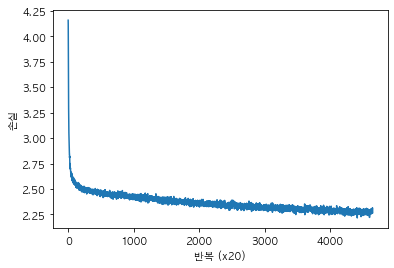

In [33]:
### 개선된 CBOW 모델 학습 코드
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = AdaGrad()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [283]:
word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word

In [284]:
from common.util import most_similar

In [286]:
### CBOW 모델 평가
word_vecs = params['word_vecs']
word_to_id = params['word_to_id']
id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.74951171875
 i: 0.7177734375
 they: 0.62548828125
 anybody: 0.59521484375
 nobody: 0.580078125

[query] year
 month: 0.86083984375
 summer: 0.76611328125
 week: 0.76513671875
 spring: 0.7578125
 decade: 0.71826171875

[query] car
 window: 0.60302734375
 cars: 0.5849609375
 auto: 0.5791015625
 luxury: 0.5537109375
 truck: 0.5537109375

[query] toyota
 engines: 0.6572265625
 mazda: 0.654296875
 honda: 0.646484375
 seita: 0.63720703125
 nec: 0.6162109375


In [291]:
from common.util import *

In [294]:
### analogy 함수 구현
def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a,b,c):
        if word not in word_to_id:
            print(f'{word}(을)/를 찾을 수 없습니다.)')
            
    print(f'\n[analogy] {a}:{b} = {c}:?')
    a_vec = word_vecs[word_to_id[a]]
    b_vec = word_vecs[word_to_id[b]]
    c_vec = word_vecs[word_to_id[c]]
    
    query_vec = b_vec + c_vec - a_vec
    query_vec = normalize(query_vec)
    
    similarlity = np.dot(word_matrix, query_vec)
    
    if answer is not None:
        print(f'==> {answer}: {np.dot(word_matrix[word_to_id[answer]], query_vec)}')
        
    count = 0
    for i in (-1 * similarlity).argsort():
        if np.isnan(similarlity[i]):
            continue
        if id_to_word[i] in (a,b,c):
            continue
        print(f'{id_to_word[i]}: {similarlity[i]}')
        
        count += 1
        if count >= top:
            return

In [290]:
word_vecs[word_to_id['apple']]

array([-0.4841  ,  0.1726  ,  0.1421  , -0.1593  ,  0.443   ,  1.006   ,
       -0.594   ,  1.512   , -1.155   ,  0.5063  ,  0.2188  , -0.003523,
        1.087   , -0.8154  , -0.0934  , -0.5225  ,  0.03748 , -0.3442  ,
       -0.11346 , -0.0281  ,  0.4556  , -0.9917  , -0.3618  , -0.04056 ,
       -0.2646  ,  0.521   , -0.1103  ,  0.41    , -0.4133  ,  0.1272  ,
        0.4075  , -1.004   , -0.3306  ,  1.388   , -0.535   ,  0.71    ,
       -0.1353  ,  0.904   , -0.329   ,  0.533   ,  0.5693  , -0.4646  ,
        0.2062  , -0.08453 ,  1.075   ,  0.69    ,  0.368   , -0.03275 ,
       -0.2349  ,  0.0545  ,  0.4128  , -0.4492  ,  0.3525  ,  0.4612  ,
        0.1715  , -0.0806  ,  0.7026  , -0.731   , -0.8594  ,  1.291   ,
       -0.292   , -0.3306  ,  0.1761  , -0.4631  ,  0.733   , -0.0983  ,
        0.733   ,  0.6416  , -0.0554  ,  0.4133  ,  0.2502  ,  0.03796 ,
       -0.601   ,  0.7227  , -0.0955  ,  0.724   ,  0.264   , -0.3262  ,
       -1.125   ,  0.6865  ,  1.281   ,  0.2717  , 

In [295]:
### 유추 문제 풀기
analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
woman: 5.375
cubans: 4.703125
lady: 4.66796875
kid: 4.609375
hacker: 4.5234375


In [296]:
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)


[analogy] take:took = go:?
eurodollars: 4.60546875
went: 4.546875
were: 4.46875
came: 4.359375
're: 4.29296875


In [297]:
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)


[analogy] car:cars = child:?
a.m: 6.83203125
rape: 5.5546875
daffynition: 5.32421875
children: 5.11328125
bond-equivalent: 4.97265625


In [298]:
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs)


[analogy] good:better = bad:?
rather: 5.703125
more: 5.5078125
less: 5.41015625
greater: 4.3671875
faster: 3.537109375
